✅ CELL 1: SETUP

In [4]:
import subprocess, sys, os, importlib
import torch

print('🚀 SETUP ENVIRONMENT...')

# 1. Remove all conflicting NumPy, Mamba, and SciPy packages
pkgs_to_remove = ['mamba-ssm', 'causal-conv1d', 'tsai', 'fastai', 'numpy', 'scipy']
print(f"   🗑️ Uninstalling all conflicting packages...")
subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y'] + pkgs_to_remove,
               stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# 2. INSTALL STANDARD NUMPY AND SCIENTIFIC PACKAGES (KEEP ORIGINAL)
print('   🔄 Installing CRITICAL NumPy 1.26.4 + Scientific Stack...')
subprocess.run([sys.executable, '-m', 'pip', 'install',
                'numpy==1.26.4', 'scipy==1.11.4',
                'ninja', 'packaging', '-q'], check=True)

# 3. Reinstall Core Dependencies (UPDATED WITH WFDB AND THOP)
print('   🔄 Installing wfdb, thop and other dependencies...')
pip_cmds = [
    # Added wfdb and thop to this line
    "pip install neurokit2 iterative-stratification wfdb thop -q",
    "pip install flatten-dict scikit-learn pandas tqdm seaborn matplotlib -q"
]
for cmd in pip_cmds:
    subprocess.run(cmd.split(), check=True)


# 4. INSTALL MAMBA FROM PRE-BUILT WHEEL (FIX MAIN ERROR)
WHEEL_DIR = '/content/drive/MyDrive/mamba_wheels_py312'
print(f'\n📦 Installing Mamba from pre-built wheels in: {WHEEL_DIR}')

# Find and install causal-conv1d
try:
    cc1d_file = [f for f in os.listdir(WHEEL_DIR) if 'causal_conv1d' in f and f.endswith('.whl')][0]
    print(f'   🔄 Installing {cc1d_file}...')
    subprocess.run([sys.executable, '-m', 'pip', 'install', os.path.join(WHEEL_DIR, cc1d_file), '-q'], check=True)
    print('   ✅ causal-conv1d installed')
except IndexError:
    print('   ⚠️ Causal-conv1d wheel not found. Please ensure it is in the directory.')
except subprocess.CalledProcessError as e:
    print(f'   ❌ Causal-Conv1d Install Failed! Error: {e}')


# Find and install mamba-ssm
try:
    mamba_file = [f for f in os.listdir(WHEEL_DIR) if 'mamba_ssm' in f and f.endswith('.whl')][0]
    print(f'   🔄 Installing {mamba_file}...')
    subprocess.run([sys.executable, '-m', 'pip', 'install', os.path.join(WHEEL_DIR, mamba_file), '-q'], check=True)
    print('   ✅ mamba-ssm installed')
except IndexError:
    print('   ⚠️ Mamba-ssm wheel not found. Please ensure it is in the directory.')
except subprocess.CalledProcessError as e:
    print(f'   ❌ Mamba-SSM Install Failed! Error: {e}')


print('\n==================================================')
print(f'✅ Setup complete. CUDA available: {torch.cuda.is_available()}')

🚀 SETUP ENVIRONMENT...
   🗑️ Uninstalling all conflicting packages...
   🔄 Installing CRITICAL NumPy 1.26.4 + Scientific Stack...
   🔄 Installing wfdb, thop and other dependencies...

📦 Installing Mamba from pre-built wheels in: /content/drive/MyDrive/mamba_wheels_py312
   🔄 Installing causal_conv1d-1.5.3.post1-cp312-cp312-linux_x86_64.whl...
   ✅ causal-conv1d installed
   🔄 Installing mamba_ssm-2.2.6.post3-cp312-cp312-linux_x86_64.whl...
   ✅ mamba-ssm installed

✅ Setup complete. CUDA available: True


✅ CELL 2: Config, GPU auto-scaling

In [ ]:
%%writefile config.py
# ==================================================================================
# ⚙️ GLOBAL CONFIGURATION
# ==================================================================================

import os
import json
import hashlib
import torch

# ============================================================
# DEVICE & SIGNAL SETUP
# ============================================================
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEQ_LEN = 5000        # Chapman–Shaoxing ECG length
FS = 500              # Sampling rate (Hz)

# ============================================================
# CORE CONFIGURATION (CLEAN CORE ONLY)
# ============================================================
BASE_CONFIG = {
    # ================= MODEL CAPACITY =================
    'd_model': 384,
    'n_layers': 16,
    'hydra_dim': 3072,
    'n_latents': 64,
    'hrv_dim': 36,
    'drop_path_rate': 0.3,

    # ================= ARCHITECTURE ==================
    'use_cross_attention_fusion': True,
    'fusion_heads': 8,
    'use_spatial_attention': True,
    'use_hrv': True,
    'use_final_perceiver': True,

    # ============== EVENT-CENTRIC SLICING =============
    'use_event_slicing': True,
    'slice_length': 2500,
    'slice_stride': 1250,
    'max_slices_per_record': 6,
    'aggregation_method': 'mean',

    # ================= TRAINING ======================
    'batch_size': 192,
    'accum_iter': 1,
    'epochs': 20,
    'lr_max': 9e-4,
    'lr_min': 1e-6,
    'weight_decay': 0.05,
    'grad_clip': 1.0,
    'num_workers': 8,

    # ================= WARMUP ========================
    'warmup_epochs': 8,
    'warmup_lr_scale': 1.0,

    # ================= LOSS STRATEGY =================

    'loss_type': 'bce_then_asymmetric',
    'asym_start_epoch': 8,
    'asym_gamma_neg': 2.5,
    'asym_gamma_pos': 0.0,
    'asym_clip': 0.05,
    'use_negative_reweighting': False,

    # ================= OPTIMIZATION ==================
    'use_gradient_centralization': False,

    # ================= WEIGHT AVERAGING ===============
    # EMA allowed for evaluation only
    'use_ema': True,
    'ema_decay': 0.999,

    # SWA
    'use_swa': False,

    # ================= CALIBRATION ===================
    'use_calibration': False,
    'default_threshold': 0.5,

    # ================= CLEAN GUARANTEES ===============
    'optimize_thresholds': False,
    'label_smoothing': 0.0,
    'use_soft_clinical_constraints': False,

    # ================= EVALUATION =====================
    'training_mode': 'kfold',
    'cv_strategy': 'StratifiedGroupKFold',
    'group_key': 'subject_id',
    'n_folds': 5,
    'seeds': [42],

    # ================= FEATURE LEARNING ===============
    'hydra_pca_mode': 'fold_aware',
    'seq_len_after_tokenizer': 625,
}

CONFIG = BASE_CONFIG
CONFIG['_profile'] = ''

# ============================================================
# ABLATION CONFIG (MODEL COMPATIBILITY)
# ============================================================
ABLATION_CONFIG = {
    'use_multiscale': True,
    'use_rocket': True,
    'use_hrv': True,
}

# ============================================================
# FIXED TAXONOMY (CHAPMAN–SHAOXING / SNOMED CT)
# ============================================================
CLASSES = [
    'AF', 'AFL', 'Brady', 'CRBBB', 'IAVB', 'IRBBB', 'LAD', 'LBBB',
    'LAnFB', 'LQT', 'LQRSV', 'NSIVCB', 'PR', 'PAC', 'PVC', 'QAb',
    'RAD', 'RBBB', 'SA', 'SB', 'SNR', 'STach', 'SVPB', 'TAb',
    'TInv', 'VPB', 'LPR'
]

NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {c: i for i, c in enumerate(CLASSES)}

# Required by data.py (metadata only, not used in training)
SNOMED_MAPPING = {
    '164889003': 0, '164890007': 1, '426627000': 2, '713427006': 3,
    '270492004': 4, '713426002': 5, '39732003': 6, '164909002': 7,
    '445118002': 8, '111975006': 9, '251146004': 10, '698252002': 11,
    '10370003': 12, '284470004': 13, '427172004': 14, '164917005': 15,
    '47665007': 16, '59118001': 17, '427393009': 18, '426177001': 19,
    '426783006': 20, '427084000': 21, '63593006': 22, '164934002': 23,
    '59931005': 24, '17338001': 25, '164947007': 26
}

# ============================================================
# CONFIG HASH & PATHS
# ============================================================
CONFIG_HASH = hashlib.md5(
    json.dumps(CONFIG, sort_keys=True).encode()
).hexdigest()[:8]

def setup_paths(num_classes: int, hydra_dim: int, cfg_hash: str, drive_mounted: bool = True) -> dict:
    cache_dir = '/content/drive/MyDrive/ECG' if drive_mounted else './ecg_cache'
    paths = {
        'cache_dir': cache_dir,
        'zip_path': f'{cache_dir}/archive.zip',
        'extract_dir': './ecg_data_chapman',
        'data_cache': f'{cache_dir}/ecg_data_{num_classes}c_subject.npz',
        'model_dir': f'{cache_dir}/models_ramba_{cfg_hash}',
    }
    os.makedirs(cache_dir, exist_ok=True)
    os.makedirs(paths['model_dir'], exist_ok=True)
    return paths

PATHS = setup_paths(NUM_CLASSES, CONFIG['hydra_dim'], CONFIG_HASH, drive_mounted=True)

# ============================================================
# LOG EFFECTIVE CONFIG (REVIEWER AUDIT)
# ============================================================
with open(os.path.join(PATHS['model_dir'], 'effective_config.json'), 'w') as f:
    json.dump({
        'CONFIG_HASH': CONFIG_HASH,
        'PROFILE': CONFIG['_profile'],
        'DEVICE': DEVICE,
        'NUM_CLASSES': NUM_CLASSES,
        'CONFIG': CONFIG,
        'PATHS': PATHS,
    }, f, indent=2)

print("🔧 ECG RAMBA")
print(f"   Profile        : {CONFIG['_profile']}")
print(f"   Config Hash    : {CONFIG_HASH}")
print(f"   Gamma (fixed)  : {CONFIG['asym_gamma_neg']}")
print(f"   Warmup Epochs  : {CONFIG['warmup_epochs']}")
print(f"   EMA Enabled    : {CONFIG['use_ema']}")
print(f"   Calibration    : DISABLED")
print(f"   Workers        : {CONFIG['num_workers']}")

Overwriting config.py


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ CELL 3: UTILS

In [2]:
%%writefile utils.py
# ==================================================================================
# 🧰 ECG RAMBA - Utilities Module
# ----------------------------------------------------------------------------------
# Design principles:
# - NO clinical heuristics
# - NO threshold optimization
# - NO validation peeking
# - NO label leakage
# - NO optimization tricks (GC, SWA, calibration)
# - Deterministic & reproducible
#
# Provided utilities:
# - Fixed-gamma FN-aware Asymmetric Loss
# - Honest evaluation metrics (fixed threshold)
# - EMA (evaluation-only)
# - Seed control
# ==================================================================================

import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    average_precision_score,
)

# ============================================================
# 🔢 PER-CLASS NEGATIVE WEIGHT (TRAIN-ONLY)
# ============================================================

def compute_negative_class_weights(y_train: np.ndarray) -> torch.Tensor:
    """
    Compute per-class negative weights using TRAIN labels only.
    Data-driven, normalized, no priors.

    NOTE:
    - Optional in Clean Core (can be disabled via config)
    - Never computed on val / test
    """
    assert y_train.ndim == 2, "y_train must be (N, C)"

    freq = y_train.mean(axis=0)
    neg_weight = 1.0 / (freq + 1e-6)
    neg_weight = neg_weight / neg_weight.mean()

    return torch.tensor(neg_weight, dtype=torch.float32)


# ============================================================
# 📉 ASYMMETRIC LOSS
# ============================================================

class AsymmetricLossMultiLabel(nn.Module):
    """
    Asymmetric Loss for Multi-Label Classification (.

    Properties:
    ✔ FN-aware
    ✔ FIXED gamma (no annealing)
    ✔ No thresholding
    ✔ TRAIN-only statistics

    IMPORTANT:
    - Gamma MUST be fixed from config
    - No dynamic updates allowed
    """

    def __init__(
        self,
        gamma_neg: float,
        gamma_pos: float = 0.0,
        clip: float = 0.05,
        eps: float = 1e-8,
        neg_weight: torch.Tensor | None = None,
    ):
        super().__init__()
        self.gamma_neg = float(gamma_neg)
        self.gamma_pos = float(gamma_pos)
        self.clip = clip
        self.eps = eps

        if neg_weight is not None:
            self.register_buffer("neg_weight", neg_weight)
        else:
            self.neg_weight = None

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        probs = torch.sigmoid(logits)

        # Positive term
        loss_pos = -targets * ((1.0 - probs) ** self.gamma_pos) * \
                   torch.log(probs + self.eps)

        # Negative term (FN-aware)
        probs_neg = (probs - self.clip).clamp(min=0.0)

        if self.neg_weight is None:
            neg_w = 1.0
        else:
            neg_w = self.neg_weight.view(1, -1)

        loss_neg = -(1.0 - targets) * neg_w * \
                   (probs_neg ** self.gamma_neg) * \
                   torch.log(1.0 - probs_neg + self.eps)

        loss = loss_pos + loss_neg
        return loss.sum() / logits.size(0)


# ============================================================
# 📊 METRICS
# ============================================================

def compute_metrics(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    threshold: float = 0.5,
) -> dict:
    """
    Honest record-level metrics.

    Rules:
    - Fixed threshold ONLY (default = 0.5)
    - No per-class thresholds
    - No optimization
    """
    assert y_true.shape == y_prob.shape

    y_pred = (y_prob > threshold).astype(np.float32)

    metrics = {
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_micro": f1_score(y_true, y_pred, average="micro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

    auprcs = []
    for c in range(y_true.shape[1]):
        if y_true[:, c].sum() > 0:
            auprcs.append(
                average_precision_score(y_true[:, c], y_prob[:, c])
            )

    metrics["auprc_macro"] = float(np.mean(auprcs)) if len(auprcs) > 0 else 0.0
    return metrics


# ============================================================
# 🔁 EMA
# ============================================================

class EMA:
    """
    Exponential Moving Average (Clean Core).

    Rules:
    - Evaluation-only
    - NEVER mixed with SWA (SWA not allowed here)
    - Applied & restored explicitly in validation
    """

    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay = decay
        self.shadow = {
            n: p.data.clone()
            for n, p in model.named_parameters()
            if p.requires_grad
        }
        self.backup = {}

    def update(self, model: nn.Module):
        for n, p in model.named_parameters():
            if p.requires_grad and n in self.shadow:
                self.shadow[n].mul_(self.decay).add_(p.data, alpha=1.0 - self.decay)

    def apply_shadow(self, model: nn.Module):
        self.backup = {}
        for n, p in model.named_parameters():
            if n in self.shadow:
                self.backup[n] = p.data.clone()
                p.data.copy_(self.shadow[n])

    def restore(self, model: nn.Module):
        for n, p in model.named_parameters():
            if n in self.backup:
                p.data.copy_(self.backup[n])
        self.backup = {}


# ============================================================
# 🎲 SEED CONTROL (DETERMINISTIC)
# ============================================================

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


print("✅ Utils module loaded")

Overwriting utils.py


✅ CELL 4: Features (PyTorch MiniRocket ⭐)

In [3]:
%%writefile features.py
"""
ECG RAMBA - Feature Engineering Module
====================================================================
Design principles (STRICT):
- Deterministic & reproducible
- Label-agnostic (NO leakage)
- Fold-safe preprocessing (NO global PCA)
- Cache-stable across config changes
- Architecture-supportive only (NO clinical heuristics)

Guarantees:
- NEVER fits PCA on full dataset
- RAW MiniRocket features ONLY
- PCA fitted strictly inside CV folds
- HRV + amplitude + global record stats (fixed dim = 36)
"""

import os
import numpy as np
import torch
import torch.nn as nn
from scipy.signal import find_peaks
import scipy.stats as stats
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

try:
    import neurokit2 as nk
    HAS_NEUROKIT = True
except ImportError:
    HAS_NEUROKIT = False

from config import CONFIG, PATHS, SEQ_LEN, FS


# ============================================================
# MINI-ROCKET (DETERMINISTIC, CPU-ONLY, PAPER-SAFE)
# ============================================================

class MiniRocketNative(nn.Module):
    """
    Deterministic MiniRocket transform (Dempster et al.).

    Properties:
    - Non-trainable
    - Fully deterministic (seeded)
    - Fixed output dimensionality
    - CPU-only for reproducibility
    """

    def __init__(
        self,
        c_in: int = 12,
        seq_len: int = SEQ_LEN,
        num_kernels: int = 10000,
        seed: int = 42,
    ):
        super().__init__()

        kernel_length = 9
        dilations = self._get_dilations(seq_len, kernel_length)

        kernels_per_dilation = num_kernels // len(dilations)
        num_kernels = kernels_per_dilation * len(dilations)

        self.convs = nn.ModuleList()
        self.biases = nn.ParameterList()

        g = torch.Generator(device="cpu").manual_seed(seed)

        for d in dilations:
            conv = nn.Conv1d(
                c_in,
                kernels_per_dilation,
                kernel_size=kernel_length,
                dilation=d,
                padding="same",
                bias=False,
            )
            with torch.no_grad():
                w = torch.randint(-1, 2, conv.weight.shape, generator=g)
                conv.weight.copy_(w.float())
            conv.weight.requires_grad = False
            self.convs.append(conv)

            bias = nn.Parameter(
                torch.randn(kernels_per_dilation, generator=g) * 0.1,
                requires_grad=False,
            )
            self.biases.append(bias)

        # Each kernel → (MAX, PPV)
        self.num_features = num_kernels * 2

    @staticmethod
    def _get_dilations(seq_len, kernel_length):
        max_d = (seq_len - 1) // (kernel_length - 1)
        d, out = 1, []
        while d <= max_d:
            out.append(d)
            d *= 2
        return out if out else [1]

    def forward(self, x):
        feats = []
        for conv, bias in zip(self.convs, self.biases):
            out = conv(x)
            maxv, _ = out.max(dim=-1)
            ppv = (out > bias.view(1, -1, 1)).float().mean(dim=-1)
            feats.extend([maxv, ppv])
        return torch.cat(feats, dim=1)


# ============================================================
# RAW MINI-ROCKET CACHE (STABLE, CONFIG-INDEPENDENT)
# ============================================================

def generate_raw_rocket_cache(X: np.ndarray) -> np.ndarray:
    """
    RAW MiniRocket features.

    Cache properties:
    - Depends ONLY on dataset shape + kernel definition
    - Independent of training config / folds / model
    - Deterministic across machines
    """

    assert X.ndim == 3, "X must be (N, C, T)"

    rocket_cache_name = (
        f"rocket_raw_"
        f"N{len(X)}_"
        f"C{X.shape[1]}_"
        f"L{X.shape[-1]}_"
        f"K10000_"
        f"S42.npz"
    )

    cache_path = os.path.join(PATHS["cache_dir"], rocket_cache_name)

    if os.path.exists(cache_path):
        cached = np.load(cache_path)["X"]
        if cached.shape[0] == len(X):
            print(f"✅ Loaded RAW MiniRocket cache: {cached.shape}")
            return cached.astype(np.float32)
        else:
            print("⚠️ Rocket cache exists but size mismatch → regenerating")

    print("🚀 Generating RAW MiniRocket features (CPU, deterministic)...")

    model = MiniRocketNative(
        c_in=X.shape[1],
        seq_len=X.shape[-1],
        num_kernels=10000,
        seed=42,
    ).cpu().eval()

    feats = []
    bs = 64

    with torch.no_grad():
        for i in range(0, len(X), bs):
            xb = torch.tensor(X[i:i+bs], dtype=torch.float32, device="cpu")
            feats.append(model(xb).numpy())

    X_rocket = np.vstack(feats).astype(np.float32)

    np.savez_compressed(cache_path, X=X_rocket.astype(np.float16))
    print(f"✅ Saved RAW MiniRocket cache: {X_rocket.shape}")
    print(f"📦 Cache path: {cache_path}")

    return X_rocket


# ============================================================
# FOLD-AWARE PCA (STRICT ANTI-LEAKAGE)
# ============================================================

def fit_pca_on_train(X_train: np.ndarray, n_components: int) -> PCA:
    """
    PCA MUST be fitted on TRAIN fold only.
    """
    pca = PCA(
        n_components=n_components,
        svd_solver="randomized",
        random_state=42,
    )
    pca.fit(X_train)
    return pca


def apply_pca(pca: PCA, X: np.ndarray) -> np.ndarray:
    return pca.transform(X).astype(np.float32)


# ============================================================
# HRV FEATURES (25)
# ============================================================

def extract_hrv_features(signal: np.ndarray, fs: int = FS) -> np.ndarray:
    feats = np.zeros(25, dtype=np.float32)
    lead = signal[1]

    try:
        peaks = None

        if HAS_NEUROKIT:
            try:
                _, r = nk.ecg_peaks(lead, sampling_rate=fs)
                peaks = r.get("ECG_R_Peaks", None)
            except Exception:
                pass

        if peaks is None or len(peaks) < 3:
            z = (lead - lead.mean()) / (lead.std() + 1e-8)
            peaks, _ = find_peaks(
                z,
                height=1.5,
                distance=int(0.25 * fs),
            )

        if len(peaks) > 2:
            rr = np.diff(peaks) / fs * 1000.0
            rr = rr[(rr > 300) & (rr < 2000)]
            if len(rr) > 1:
                feats[:5] = [
                    rr.mean(),
                    rr.std(),
                    np.median(rr),
                    rr.min(),
                    rr.max(),
                ]
    except Exception:
        pass

    return np.nan_to_num(feats)


# ============================================================
# AMPLITUDE FEATURES (5)
# ============================================================

def extract_amplitude_features(signal_raw: np.ndarray) -> np.ndarray:
    feats = np.zeros(5, dtype=np.float32)
    try:
        amps = np.ptp(signal_raw, axis=-1)
        feats[:] = [
            amps.mean(),
            amps.min(),
            amps.max(),
            amps[:3].mean(),
            amps[6:12].mean(),
        ]
    except Exception:
        pass
    return feats


# ============================================================
# GLOBAL RECORD STATS (6)
# ============================================================

def extract_global_record_stats(signal: np.ndarray) -> np.ndarray:
    z = (signal - signal.mean()) / (signal.std() + 1e-8)
    return np.array(
        [
            z.mean(),
            z.std(),
            np.mean(z ** 2),
            stats.kurtosis(z.flatten()),
            stats.skew(z.flatten()),
            np.percentile(z, 95),
        ],
        dtype=np.float32,
    )


# ============================================================
# HRV + AMP + GLOBAL CACHE (FIXED DIM = 36)
# ============================================================

def generate_hrv_cache(X: np.ndarray, X_raw_amp: np.ndarray) -> np.ndarray:
    """
    HRV + amplitude + global record stats.

    Fixed dimensionality = 36
    """

    cache_path = os.path.join(
        PATHS["cache_dir"],
        f"hrv36_N{len(X)}_C{X.shape[1]}_L{X.shape[-1]}.npz",
    )

    if os.path.exists(cache_path):
        cached = np.load(cache_path)["X"]
        if cached.shape[0] == len(X):
            print(f"✅ Loaded HRV36 cache: {cached.shape}")
            return cached.astype(np.float32)

    print("💓 Extracting HRV + amplitude + global stats (CPU)...")

    feats = np.zeros((len(X), 36), dtype=np.float32)

    for i, sig in enumerate(tqdm(X, desc="HRV36")):
        hrv = extract_hrv_features(sig)
        amp = extract_amplitude_features(X_raw_amp[i])
        gstat = extract_global_record_stats(sig)
        feats[i] = np.concatenate([hrv, amp, gstat])

    assert feats.shape[1] == CONFIG["hrv_dim"], \
        f"HRV dim mismatch: got {feats.shape[1]}, expected {CONFIG['hrv_dim']}"

    np.savez_compressed(cache_path, X=feats.astype(np.float16))
    print(f"✅ Saved HRV36 cache: {feats.shape}")
    print(f"📦 Cache path: {cache_path}")

    return feats


print("✅ Features module loaded (MiniRocket + HRV36)")

Overwriting features.py


✅ CELL 5: Data (loading, augmentation) & SUBJECT-AWARE SPLIT (GroupKFold)

In [4]:
%%writefile data.py
"""
ECG RAMBA – Data Pipeline
==============================================================
Design goals:
- Always count RAW records from filesystem (~45k)
- Never silently load stale / partial cache
- Robust to corrupt .mat files
- Subject-aware (record-id based)
- Reviewer-safe logging
"""

import os
import zipfile
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt
from scipy.io import loadmat
from tqdm.auto import tqdm
import shutil

from config import (
    CONFIG, PATHS, SEQ_LEN, FS, NUM_CLASSES,
    SNOMED_MAPPING
)
from features import extract_amplitude_features


# ============================================================
# SUBJECT / RECORD ID
# ============================================================
def extract_record_id(hea_path: str) -> str:
    # Chapman–Shaoxing: 1 record = 1 subject
    return os.path.basename(hea_path).replace('.hea', '')


# ============================================================
# SIGNAL PROCESSING
# ============================================================
def bandpass_filter(signal: np.ndarray, lowcut=0.5, highcut=40, fs=FS, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal, axis=-1)


def normalize_signal(signal: np.ndarray):
    mean = signal.mean(axis=-1, keepdims=True)
    std = signal.std(axis=-1, keepdims=True) + 1e-8
    return (signal - mean) / std


def pad_or_truncate(signal: np.ndarray, target_len=SEQ_LEN):
    if signal.shape[-1] >= target_len:
        return signal[..., :target_len]
    return np.pad(
        signal,
        ((0, 0), (0, target_len - signal.shape[-1])),
        mode='constant'
    )


# ============================================================
# LABEL PARSING (SNOMED)
# ============================================================
def get_labels_from_header(header_path: str) -> np.ndarray:
    labels = np.zeros(NUM_CLASSES, dtype=np.float32)
    try:
        with open(header_path, 'r') as f:
            for line in f:
                if line.startswith('#Dx:'):
                    codes = line.replace('#Dx:', '').strip().split(',')
                    for c in codes:
                        c = c.strip()
                        if c in SNOMED_MAPPING:
                            labels[SNOMED_MAPPING[c]] = 1.0
                    break
    except Exception:
        pass
    return labels


# ============================================================
# MAT FILE LOADING (ROBUST)
# ============================================================
def load_mat_signal(mat_path: str) -> np.ndarray | None:
    try:
        mat = loadmat(mat_path)
        if 'val' in mat:
            sig = mat['val'].astype(np.float32)
            # Ensure shape = (12, T)
            if sig.shape[0] != 12 and sig.shape[1] == 12:
                sig = sig.T
            return sig
    except Exception:
        return None
    return None


# ============================================================
# MAIN DATA LOADER
# ============================================================
def load_chapman_multilabel(paths: dict = None):
    if paths is None:
        paths = PATHS

    print("\n🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)")
    print("=" * 80)

    cache_path = paths['data_cache']

    # --------------------------------------------------------
    # 1️⃣ LOAD CACHE (ONLY IF VALID & COMPLETE)
    # --------------------------------------------------------
    if os.path.exists(cache_path):
        print(f"⚠️  Loading cached data: {cache_path}")
        d = np.load(cache_path, allow_pickle=True)
        return d['X'], d['y'], d['X_raw_amp'], d['subjects']

    extract_dir = paths['extract_dir']
    zip_path = paths['zip_path']

    # --------------------------------------------------------
    # 2️⃣ EXTRACTION SAFETY CHECK
    # --------------------------------------------------------
    should_extract = True
    if os.path.exists(extract_dir):
        num_files = sum(
            1 for _, _, files in os.walk(extract_dir) for f in files
            if f.endswith('.hea')
        )
        if num_files > 40000:
            should_extract = False
            print(f"📂 Raw directory looks complete ({num_files} records).")
        else:
            print(f"⚠️  Raw directory incomplete ({num_files} records). Re-extracting...")
            shutil.rmtree(extract_dir)

    if should_extract:
        print(f"📦 Extracting dataset from ZIP: {zip_path}")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)

    # --------------------------------------------------------
    # 3️⃣ SCAN RAW RECORDS (TRUTH SOURCE)
    # --------------------------------------------------------
    hea_files = []
    for root, _, files in os.walk(extract_dir):
        hea_files.extend(
            os.path.join(root, f) for f in files if f.endswith('.hea')
        )

    print(f"🔎 Found {len(hea_files)} RAW records")

    # --------------------------------------------------------
    # 4️⃣ LOAD & CLEAN
    # --------------------------------------------------------
    X_list, y_list, amp_list, subject_list = [], [], [], []
    skipped = {
        'no_label': 0,
        'no_mat': 0,
        'bad_signal': 0,
        'corrupt_file': 0
    }

    # Known corrupted record (documented)
    BLACKLIST = {'JS27567'}

    for hea_path in tqdm(hea_files, desc="Loading ECG"):
        rid = extract_record_id(hea_path)

        if rid in BLACKLIST:
            skipped['corrupt_file'] += 1
            continue

        labels = get_labels_from_header(hea_path)
        if labels.sum() == 0:
            skipped['no_label'] += 1
            continue

        mat_path = hea_path.replace('.hea', '.mat')
        if not os.path.exists(mat_path):
            skipped['no_mat'] += 1
            continue

        signal = load_mat_signal(mat_path)
        if signal is None or signal.shape[0] != 12:
            skipped['bad_signal'] += 1
            continue

        try:
            signal = bandpass_filter(signal)
            amp_feats = extract_amplitude_features(signal)
            signal = normalize_signal(signal)
            signal = pad_or_truncate(signal)

            X_list.append(signal)
            y_list.append(labels)
            amp_list.append(amp_feats)
            subject_list.append(rid)

        except Exception:
            skipped['bad_signal'] += 1

    if len(X_list) == 0:
        raise RuntimeError("❌ No valid ECG samples loaded.")

    X = np.stack(X_list).astype(np.float32)
    y = np.stack(y_list).astype(np.float32)
    X_raw_amp = np.stack(amp_list).astype(np.float32)
    subjects = np.array(subject_list)

    print(f"\n📊 Loaded {len(X)} usable samples")
    print(f"🚫 Skipped records: {skipped}")

    # --------------------------------------------------------
    # 5️⃣ SAVE CACHE (CONFIG-HASH SAFE)
    # --------------------------------------------------------
    np.savez_compressed(
        cache_path,
        X=X,
        y=y,
        X_raw_amp=X_raw_amp,
        subjects=subjects
    )

    print(f"💾 Cached cleaned dataset to: {cache_path}")
    print("✅ DATA LOADING COMPLETE")
    print("=" * 80)

    return X, y, X_raw_amp, subjects


# ============================================================
# DATASET WRAPPER (OPTIONAL)
# ============================================================
class ECGDatasetMultiLabel(Dataset):
    def __init__(self, X, X_hydra, X_hrv, y):
        self.X = X
        self.X_hydra = X_hydra
        self.X_hrv = X_hrv
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.X_hydra[idx], dtype=torch.float32),
            torch.tensor(self.X_hrv[idx], dtype=torch.float32),
            self.y[idx]
        )


print("✅ data.py loaded")

Overwriting data.py


✅ CELL 6: Layers (Model building blocks)

In [5]:
%%writefile layers.py
"""
ECG RAMBA - Model Building Blocks
=============================================================
Key guarantees:
- No data leakage
- No clinical heuristics
- Parameter-efficient
- Deterministic & reproducible
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

from config import CONFIG, NUM_CLASSES # NUM_CLASSES imported for downstream head compatibility


# ============================================================
# MAMBA IMPORT
# ============================================================

try:
    from mamba_ssm import Mamba2
    MAMBA_CLS = Mamba2
    print("✅ Using Mamba2")
except ImportError:
    try:
        from mamba_ssm import Mamba
        MAMBA_CLS = Mamba
        print("✅ Using Mamba (v1)")
    except ImportError:
        raise ImportError("❌ CRITICAL: mamba_ssm not installed")

BIMAMBA_BWD_OFFSET = 1000 # Offset to ensure unique parameter namespace for backward Mamba


# ============================================================
# LAYER NORM 1D (CHANNEL-WISE)
# ============================================================

class LayerNorm1d(nn.Module):
    """
    Channel-wise normalization for (B, C, L) tensors.
    Note: Normalizes across channel dimension for ECG morphology stability.
    """
    def __init__(self, num_channels, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, num_channels, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channels, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = x.std(dim=1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


# ============================================================
# CONVNEXT BLOCK
# ============================================================

class ConvNeXtBlock(nn.Module):
    """ConvNeXt-style block for local ECG morphology."""
    def __init__(self, dim, drop=0.):
        super().__init__()
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm1d(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.drop = nn.Dropout(drop) if drop > 0 else nn.Identity()

    def forward(self, x):
        res = x
        x = self.norm(self.dwconv(x))
        x = x.transpose(1, 2)
        x = self.pwconv2(F.gelu(self.pwconv1(x)))
        return res + self.drop(x.transpose(1, 2))


# ============================================================
# CHANNEL MIX GLU
# ============================================================

class ChannelMixGLU(nn.Module):
    """Channel-wise gated FFN."""
    def __init__(self, d, exp=4):
        super().__init__()
        self.w1 = nn.Linear(d, d * exp)
        self.w2 = nn.Linear(d, d * exp)
        self.w3 = nn.Linear(d * exp, d)

    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))


# ============================================================
# SPATIAL LEAD ATTENTION (FIXED for PTB-XL)
# ============================================================

class SpatialLeadAttention(nn.Module):
    """
    Learned spatial attention across ECG leads.
    Applied strictly in signal space: (B, 12, T)
    """

    def __init__(self, d_temp=64, n_leads=12, n_heads=4):
        super().__init__()

        self.temporal_pool = nn.Sequential(
            nn.Conv1d(1, d_temp // 2, kernel_size=50, stride=25),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(d_temp // 2, d_temp, kernel_size=3, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool1d(4)
        )

        self.lead_embed = nn.Embedding(n_leads, d_temp * 4)
        self.attn = nn.MultiheadAttention(
            embed_dim=d_temp * 4,
            num_heads=n_heads,
            batch_first=True
        )

        self.scale_proj = nn.Linear(d_temp * 4, 1)

    def forward(self, x):
        """
        x: (B, 12, T)
        return: (B, 12, T)
        """
        B, L, T = x.shape
        assert L == self.lead_embed.num_embeddings, \
            f"Expected {self.lead_embed.num_embeddings} leads, got {L}"

        # ---- temporal summarization per lead ----
        # FIX: Use .reshape() instead of .view() to handle non-contiguous memory
        # This is critical for zero-shot inference on PTB-XL
        xt = x.reshape(B * L, 1, T)
        feats = self.temporal_pool(xt).reshape(B, L, -1)  # (B, L, d_temp*4)

        # ---- add learned lead identity ----
        lead_ids = torch.arange(L, device=x.device)
        feats = feats + self.lead_embed(lead_ids)[None, :, :]

        # ---- self-attention across leads ----
        attn_out, _ = self.attn(feats, feats, feats)

        # ---- produce gating scalars per lead ----
        scales = torch.sigmoid(self.scale_proj(attn_out))  # (B, L, 1)

        # ---- multiplicative gating ONLY ----
        return x * scales


# ============================================================
# CROSS-ATTENTION FUSION
# ============================================================

class CrossAttentionFusion(nn.Module):
    """Bidirectional cross-attention between Mamba & Rocket tokens."""
    def __init__(self, d_model, n_heads=8, dropout=0.1):
        super().__init__()
        self.m2r = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=dropout)
        self.r2m = nn.MultiheadAttention(d_model, n_heads, batch_first=True, dropout=dropout)

        self.n1 = nn.LayerNorm(d_model)
        self.n2 = nn.LayerNorm(d_model)
        self.n3 = nn.LayerNorm(d_model)
        self.n4 = nn.LayerNorm(d_model)

        self.gate = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.Sigmoid()
        )

    def forward(self, mamba, rocket):
        m_enr = mamba + self.m2r(self.n1(mamba), self.n2(rocket), self.n2(rocket), need_weights=False)[0]
        r_enr = rocket + self.r2m(self.n3(rocket), self.n4(mamba), self.n4(mamba), need_weights=False)[0]

        m_pool = m_enr.mean(1)
        r_pool = r_enr.mean(1)
        g = self.gate(torch.cat([m_pool, r_pool], -1))

        fused_pool = g * m_pool + (1 - g) * r_pool
        fused_seq = torch.cat([m_enr, r_enr], dim=1)

        return fused_seq, fused_pool


# ============================================================
# MULTI-SCALE TOKENIZER
# ============================================================

class MultiScaleTokenizer(nn.Module):
    """Multi-scale convolutional tokenizer for ECG."""
    def __init__(self, c_in=12, d_model=384):
        super().__init__()
        d = d_model // 3

        self.fine = nn.Sequential(
            nn.Conv1d(c_in, d, 3, 2, 1), nn.BatchNorm1d(d), nn.GELU(),
            nn.Conv1d(d, d, 3, 2, 1), nn.BatchNorm1d(d), nn.GELU()
        )
        self.medium = nn.Sequential(
            nn.Conv1d(c_in, d, 7, 4, 3), nn.BatchNorm1d(d), nn.GELU(),
            nn.Conv1d(d, d, 5, 2, 2), nn.BatchNorm1d(d), nn.GELU()
        )
        self.coarse = nn.Sequential(
            nn.Conv1d(c_in, d, 15, 8, 7), nn.BatchNorm1d(d), nn.GELU(),
            nn.Conv1d(d, d, 7, 2, 3), nn.BatchNorm1d(d), nn.GELU()
        )

        self.proj = nn.Conv1d(d * 3, d_model, 1)
        self.blocks = nn.Sequential(
            ConvNeXtBlock(d_model, 0.1),
            ConvNeXtBlock(d_model, 0.1)
        )
        self.target_len = CONFIG["seq_len_after_tokenizer"]

    def forward(self, x):
        f = F.adaptive_avg_pool1d(self.fine(x), self.target_len)
        m = F.adaptive_avg_pool1d(self.medium(x), self.target_len)
        c = F.adaptive_avg_pool1d(self.coarse(x), self.target_len)
        x = self.proj(torch.cat([f, m, c], dim=1))
        return self.blocks(x).transpose(1, 2)


# ============================================================
# PERCEIVER
# ============================================================

class Perceiver(nn.Module):
    """
    Parameter-efficient Perceiver IO.
    Latents attend to a SET input (Hydra features).
    """

    def __init__(self, hydra_dim, d_model, n_latents=128):
        super().__init__()
        self.input_proj = nn.Linear(hydra_dim, d_model)
        self.latents = nn.Parameter(torch.randn(1, n_latents, d_model) * 0.02)

        self.cross_attn = nn.MultiheadAttention(d_model, 8, batch_first=True)
        self.norm_q = nn.LayerNorm(d_model)
        self.norm_kv = nn.LayerNorm(d_model)

        self.self_attn = nn.MultiheadAttention(d_model, 8, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Linear(d_model * 2, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, x):
        B = x.size(0)
        kv = self.input_proj(x).unsqueeze(1)  # (B, 1, D) set input
        latents = self.latents.expand(B, -1, -1)

        latents = latents + self.cross_attn(
            self.norm_q(latents),
            self.norm_kv(kv),
            self.norm_kv(kv),
            need_weights=False
        )[0]

        latents = latents + self.self_attn(
            self.norm2(latents),
            self.norm2(latents),
            self.norm2(latents),
            need_weights=False
        )[0]

        return latents + self.ffn(self.norm3(latents))


# ============================================================
# BIMAMBA BLOCK
# ============================================================

class BiMambaBlockV3(nn.Module):
    """
    Bidirectional Mamba block with learnable gating.
    Gate is applied BEFORE FFN to stabilize bidirectional fusion.
    """
    def __init__(self, d, layer_idx, drop=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(d)
        self.norm2 = nn.LayerNorm(d)

        try:
            self.fwd = MAMBA_CLS(d_model=d, d_state=64, d_conv=4, expand=2, layer_idx=layer_idx)
            self.bwd = MAMBA_CLS(d_model=d, d_state=64, d_conv=4, expand=2,
                                 layer_idx=layer_idx + BIMAMBA_BWD_OFFSET)
        except TypeError:
            self.fwd = MAMBA_CLS(d_model=d, d_state=64, d_conv=4, expand=2)
            self.bwd = MAMBA_CLS(d_model=d, d_state=64, d_conv=4, expand=2)

        self.gate = nn.Sequential(nn.Linear(d * 2, d), nn.Sigmoid())
        self.ffn = ChannelMixGLU(d)
        self.drop = nn.Dropout(drop) if drop > 0 else nn.Identity()

    def forward(self, x):
        h = self.norm1(x)
        fwd = self.fwd(h)
        bwd = self.bwd(h.flip(1)).flip(1)

        z = self.gate(torch.cat([fwd, bwd], dim=-1))
        x = x + self.drop(z * fwd + (1 - z) * bwd)

        return x + self.drop(self.ffn(self.norm2(x)))


print("✅ layers.py loaded")

Overwriting layers.py


✅ CELL 7: Model (ECGRambaV7Advanced)

In [6]:
%%writefile model.py
"""
ECG RAMBA - Main Model (Scientific Grade)
==================================================
Status: FINAL LOCKED VERSION
Features:
  - Clean Core Compatible
  - Structural Ablation (True Pruning)
  - Inference Ablation (Dynamic Flags)
  - Token Count Fairness (Adaptive Pooling in Fallback)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

from config import CONFIG, ABLATION_CONFIG, NUM_CLASSES, DEVICE

from layers import (
    SpatialLeadAttention,
    CrossAttentionFusion,
    MultiScaleTokenizer,
    Perceiver,
    BiMambaBlockV3
)


# ============================================================
# MAIN MODEL
# ============================================================

class ECGRambaV7Advanced(nn.Module):
    """
    ECG RAMBA - Morphable Architecture.
    Designed for rigorous component ablation and zero-shot robustness.
    """

    def __init__(self, cfg: dict = None, ablation: dict = None):
        super().__init__()
        # --- BACKWARD COMPATIBILITY & DEFAULTS ---
        cfg = cfg or CONFIG
        ablation = ablation or {} # Empty dict = Full Model

        self.cfg = cfg
        self.ablation = ablation
        d = cfg["d_model"]
        target_len = cfg.get("seq_len_after_tokenizer", 256) # Default safe fallback

        # --------------------------------------------------------
        # 1. SPATIAL ATTENTION ABLATION
        # --------------------------------------------------------
        # Logic: Only enabled if Config says YES AND Ablation doesn't say NO
        use_spatial = cfg.get("use_spatial_attention", False) and not ablation.get("no_spatial", False)
        self.use_spatial = use_spatial

        if self.use_spatial:
            self.spatial_attn = SpatialLeadAttention(
                d_temp=64,
                n_leads=12,
                n_heads=4
            )
        else:
            self.spatial_attn = None

        # --------------------------------------------------------
        # 2. TOKENIZER ABLATION (FAIRNESS FIX APPLIED)
        # --------------------------------------------------------
        if not ablation.get("no_multiscale", False):
            self.tok = MultiScaleTokenizer(12, d)
        else:
            # Fallback: Single-scale Conv (Standard Patch Embedding)
            # CRITICAL FIX: Added AdaptiveAvgPool1d to ensure fair comparison
            # regarding token count. Both variants now produce exactly 'target_len' tokens.
            self.tok = nn.Sequential(
                nn.Conv1d(12, d, kernel_size=15, stride=4, padding=7),
                nn.BatchNorm1d(d),
                nn.GELU(),
                nn.AdaptiveAvgPool1d(target_len) # <-- FAIRNESS LAYER
            )

        # --------------------------------------------------------
        # 3. ROCKET & HRV (STRUCTURAL PRUNING)
        # --------------------------------------------------------
        # Structural Pruning: actually prevents module initialization to save VRAM
        self.rocket_perceiver = (
            Perceiver(cfg["hydra_dim"], d, cfg["n_latents"])
            if not ablation.get("no_rocket", False) else None
        )

        self.hrv_proj = (
            nn.Sequential(
                nn.Linear(cfg["hrv_dim"], d),
                nn.GELU(),
                nn.Dropout(0.1)
            ) if not ablation.get("no_hrv", False) else None
        )

        # --------------------------------------------------------
        # 4. FUSION ABLATION (Cross-Attn vs Concat)
        # --------------------------------------------------------
        # Logic: Use Cross Attn only if streams exist AND not ablated
        self.use_cross_attn = (
            cfg.get("use_cross_attention_fusion", False)
            and self.tok is not None
            and self.rocket_perceiver is not None
            and not ablation.get("no_fusion", False)
        )

        if self.use_cross_attn:
            self.cross_fusion = CrossAttentionFusion(d, cfg.get("fusion_heads", 8))

        # If fusion is off (Concat), we might need projection if dim doubles
        # But we concat along time dim for sequence safety, so input dim stays 'd'
        # Optional: Add projection if concatenating along channel.
        # Here we stick to Time-Concat for Mamba safety, so no projection needed.
        self.fusion_proj = None

        # --------------------------------------------------------
        # 5. COMMON COMPONENTS
        # --------------------------------------------------------
        self.feature_proj = nn.Sequential(
            nn.LayerNorm(d),
            nn.Linear(d, d),
            nn.GELU()
        )

        # === FINAL PERCEIVER (Fixed Anchor) ===
        self.use_final_perceiver = cfg.get("use_final_perceiver", True)
        if self.use_final_perceiver:
            n_lat = cfg.get("n_latents", 64)
            self.final_latents = nn.Parameter(torch.randn(1, n_lat, d) * 0.02)

            self.final_cross_attn = nn.MultiheadAttention(d, 8, batch_first=True, dropout=0.1)
            self.final_self_attn = nn.MultiheadAttention(d, 8, batch_first=True, dropout=0.1)

            self.final_norm1 = nn.LayerNorm(d)
            self.final_norm2 = nn.LayerNorm(d)
            self.final_norm3 = nn.LayerNorm(d)

            self.final_ffn = nn.Sequential(
                nn.Linear(d, d * 2),
                nn.GELU(),
                nn.Linear(d * 2, d)
            )

        # === BiMamba BACKBONE ===
        self.layers = nn.ModuleList([
            BiMambaBlockV3(d, i, drop=cfg["drop_path_rate"])
            for i in range(cfg["n_layers"])
        ])
        self.norm = nn.LayerNorm(d)

        # === CLASSIFIER ===
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(d, NUM_CLASSES)
        )

    # ========================================================
    # FORWARD
    # ========================================================

    def forward(self, x, xh, xhr, use_rocket=True, use_hrv=True, use_fusion=True):
        """
        Args:
            x: Raw ECG (B, 12, L)
            xh: Rocket Features
            xhr: HRV Features
            use_rocket (bool): Inference flag for Rocket stream
            use_hrv (bool): Inference flag for HRV stream
            use_fusion (bool): Inference flag to toggle Cross-Attn vs Concat
        """
        B = x.size(0)

        # --- 1. SPATIAL ---
        if self.spatial_attn is not None:
            x = self.spatial_attn(x)
        # If None (ablation), signal passes through unaltered

        # --- 2. TOKENIZER ---
        mamba_feat = self.tok(x)
        # Shape handling:
        # MultiScaleTokenizer returns (B, L, D) -> Ready for Mamba
        # Conv1d Fallback returns (B, D, L) -> Needs transpose
        if self.ablation.get("no_multiscale", False):
            mamba_feat = mamba_feat.transpose(1, 2)

        # --- 3. ROCKET ---
        # Check both Structural existence AND Inference Flag
        if self.rocket_perceiver is not None and use_rocket:
            rocket_feat = self.rocket_perceiver(xh) # (B, Tr, D)
        else:
            # Fallback zeros (Information Removal)
            # Ensures graph compatibility without adding information
            if self.rocket_perceiver is not None:
                n_latents = self.cfg["n_latents"]
                d_model = self.cfg["d_model"]
                rocket_feat = torch.zeros(B, n_latents, d_model, device=x.device, dtype=x.dtype)
            else:
                rocket_feat = None # Module structurally removed

        # --- 4. HRV ---
        if self.hrv_proj is not None and use_hrv:
            with torch.amp.autocast('cuda', enabled=False):
              hrv_feat = self.hrv_proj(xhr.float()).unsqueeze(1)
        else:
            if self.hrv_proj is not None:
                 d_model = self.cfg["d_model"]
                 hrv_feat = torch.zeros(B, 1, d_model, device=x.device, dtype=x.dtype)
            else:
                 hrv_feat = None

        # --- 5. FUSION ---
        # Logic: Must have CrossAttn module AND inputs AND Flag enabled
        if self.use_cross_attn and mamba_feat is not None and rocket_feat is not None and use_fusion:
            # (A) Complex Fusion (Cross Attention)
            fused_seq, _ = self.cross_fusion(mamba_feat, rocket_feat)
        else:
            # (B) Simple Concat (Fallback)
            # Concatenation along Time Dimension preserves Mamba's sequential nature
            parts = [p for p in [mamba_feat, rocket_feat] if p is not None]

            if len(parts) > 1:
                fused_seq = torch.cat(parts, dim=1)
            elif len(parts) == 1:
                fused_seq = parts[0]
            else:
                # Should conceptually not happen in valid flow
                fused_seq = torch.zeros(B, 1, self.cfg["d_model"], device=x.device, dtype=x.dtype)

        # --- 6. MERGE & PROJ ---
        seq_parts = [f for f in [fused_seq, hrv_feat] if f is not None]
        if seq_parts:
            seq = torch.cat(seq_parts, dim=1)
        else:
            # Failsafe
            seq = torch.zeros(B, 1, self.cfg["d_model"], device=x.device, dtype=x.dtype)

        seq = self.feature_proj(seq)

        # --- 7. FINAL PERCEIVER ---
        if self.use_final_perceiver:
            lat = self.final_latents.expand(B, -1, -1)
            lat = lat + self.final_cross_attn(
                self.final_norm1(lat), seq, seq, need_weights=False
            )[0]
            lat = lat + self.final_self_attn(
                self.final_norm2(lat),
                self.final_norm2(lat),
                self.final_norm2(lat),
                need_weights=False
            )[0]
            lat = lat + self.final_ffn(self.final_norm3(lat))
            seq = lat

        # --- 8. BIMAMBA BACKBONE ---
        for layer in self.layers:
            seq = layer(seq)

        pooled = self.norm(seq).mean(dim=1)
        return self.head(pooled)


# ============================================================
# SANITY CHECK
# ============================================================

def run_sanity_check(cfg: dict = None, device: str = None):
    cfg = cfg or CONFIG
    device = device or DEVICE

    print("\n🚑 SANITY CHECK (FINAL VERSION)")

    # 1. Test Full Model (Default)
    model = ECGRambaV7Advanced(cfg, {}).to(device).eval()
    print(f"   • Full Model Params: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

    x = torch.randn(2, 12, 5000, device=device)
    xh = torch.randn(2, cfg["hydra_dim"], device=device)
    xhr = torch.randn(2, cfg["hrv_dim"], device=device)

    with torch.no_grad():
        with torch.amp.autocast("cuda", enabled=device == "cuda"):
            out = model(x, xh, xhr)
            print(f"   • Output (Full): {out.shape}")

            # Test Inference Flags
            out_no_r = model(x, xh, xhr, use_rocket=False)
            out_no_f = model(x, xh, xhr, use_fusion=False) # Test fusion flag
            print(f"   • Output (No Rocket Flag): {out_no_r.shape}")
            print(f"   • Output (No Fusion Flag): {out_no_f.shape}")

    # 2. Test Structural Ablation
    # Specifically testing Tokenizer Fairness
    ablation_cfg = {"no_multiscale": True}
    model_abl = ECGRambaV7Advanced(cfg, ablation_cfg).to(device).eval()

    # Check Tokenizer Structure
    print(f"\n   • Checking Tokenizer Fairness...")
    print(f"     Fallback Tokenizer: {model_abl.tok}")
    # Expecting: Sequential(Conv1d, BN, GELU, AdaptiveAvgPool1d)

    with torch.no_grad():
        with torch.amp.autocast("cuda", enabled=device == "cuda"):
            out_abl = model_abl(x, xh, xhr)
            print(f"   • Output (Tokenizer Ablation): {out_abl.shape}")

    assert out.shape == (2, NUM_CLASSES)
    assert out_abl.shape == (2, NUM_CLASSES)
    print("\n✅ FINAL VERDICT: Model is Clean, Fair, and Robust.")


print(f"✅ Model module loaded (ECGRambaV7Advanced · {NUM_CLASSES} classes)")

Overwriting model.py


✅ CELL 8: TRAINING LOOP (Training entry pointy)

In [ ]:
# ==================================================================================
# 📦 CELL 8: TRAINING PIPELINE
# ==================================================================================
# Principles:
# - Subject-aware CV (no leakage)
# - Fold-wise PCA only
# - BCE warmup → ONE-TIME switch to FIXED Asymmetric Loss
# - NO early stopping (full-epoch training)
# - EMA for evaluation only (AFTER warmup)
# - Fixed threshold evaluation
# - Quiet logging (NaN aggregated per fold only)
# ==================================================================================

import os, gc, warnings
import numpy as np
import pandas as pd
import scipy.stats as stats
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast
from sklearn.model_selection import StratifiedGroupKFold
from collections import defaultdict

from config import CONFIG, PATHS, DEVICE
from data import load_chapman_multilabel
from features import (
    generate_raw_rocket_cache,
    generate_hrv_cache,
    fit_pca_on_train,
    apply_pca,
)
from model import ECGRambaV7Advanced
from utils import (
    compute_metrics,
    AsymmetricLossMultiLabel,
    EMA,
    set_seed,
)

warnings.filterwarnings("ignore", message="The least populated class in y")
set_seed(CONFIG["seeds"][0])

# ==================================================================================
# 🔧 RUN HEADER
# ==================================================================================
print("🔧 ECG RAMBA ")
print(f"   D={CONFIG['d_model']} | Gamma={CONFIG['asym_gamma_neg']} | LR={CONFIG['lr_max']}")
print(f"   Warmup={CONFIG['asym_start_epoch']} | Epochs={CONFIG['epochs']} | Folds={CONFIG['n_folds']}")

# ==================================================================================
# 🛡️ PHASE 1 | LOAD DATA & AUTO-CLEAN
# ==================================================================================
print("\n" + "=" * 80)
print("PHASE 1 | LOAD DATA & AUTO-CLEAN")
print("=" * 80)

X, y, X_raw_amp, subjects = load_chapman_multilabel()
print(f"Original: {len(y)} records | {y.shape[1]} classes")

MIN_SAMPLES = 5
class_counts = y.sum(axis=0)
keep_mask = class_counts >= MIN_SAMPLES

if not keep_mask.all():
    print(f"🧹 Dropping {np.sum(~keep_mask)} classes (<{MIN_SAMPLES} samples)")
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = X[valid], y[valid], X_raw_amp[valid], subjects[valid]

NUM_CLASSES = y.shape[1]
print(f"✅ Cleaned → {len(y)} records | {NUM_CLASSES} classes")

# ==================================================================================
# 🧬 PHASE 2 | RAW FEATURE GENERATION (ANTI-LEAKAGE)
# ==================================================================================
print("\n" + "=" * 80)
print("PHASE 2 | RAW FEATURE GENERATION (ANTI-LEAKAGE)")
print("=" * 80)

X_rocket_raw = generate_raw_rocket_cache(X)
X_hrv_base = generate_hrv_cache(X, X_raw_amp) if CONFIG["use_hrv"] else None

print(f"✅ RAW MiniRocket shape: {X_rocket_raw.shape}")
if X_hrv_base is not None:
    print(f"✅ HRV feature shape  : {X_hrv_base.shape}")

# ==================================================================================
# 🔪 DATASET HELPERS
# ==================================================================================

def slice_record(x):
    if x.shape[-1] < CONFIG["slice_length"]:
        return [], []
    slices, positions = [], []
    T = x.shape[-1]
    for s in range(
        0,
        T - CONFIG["slice_length"] + 1,
        CONFIG["slice_stride"],
    ):
        slices.append(x[..., s : s + CONFIG["slice_length"]])
        positions.append((s + CONFIG["slice_length"] / 2) / T)
        if len(slices) >= CONFIG["max_slices_per_record"]:
            break
    return slices, positions


class ECGSliceDataset(Dataset):
    def __init__(self, Xs, Xh, Xhr, y, rids, pos):
        self.Xs, self.Xh, self.Xhr, self.y, self.rids, self.pos = Xs, Xh, Xhr, y, rids, pos

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return (
            torch.tensor(self.Xs[i], dtype=torch.float32),
            torch.tensor(self.Xh[i], dtype=torch.float32),
            torch.tensor(self.Xhr[i], dtype=torch.float32),
            torch.tensor(self.y[i], dtype=torch.float32),
            self.rids[i],
            self.pos[i],
        )


def build_slice_dataset(indices, hydra_dict):
    xs, xh, xhr, ys, rids, pos = [], [], [], [], [], []
    skipped = 0
    for rid in indices:
        slices, positions = slice_record(X[rid])
        if len(slices) == 0:
            skipped += 1
            continue

        hrv_ext = X_hrv_base[rid] if X_hrv_base is not None else np.zeros(1)

        for s, p in zip(slices, positions):
            xs.append(s)
            xh.append(hydra_dict[rid])
            xhr.append(hrv_ext)
            ys.append(y[rid])
            rids.append(rid)
            pos.append(p)

    return map(np.array, (xs, xh, xhr, ys, rids, pos)), skipped


# ==================================================================================
# 🚀 PHASE 3 | STRATIFIED GROUP K-FOLD TRAINING
# ==================================================================================
print("\n" + "=" * 80)
print("PHASE 3 | TRAINING WITH FOLD-AWARE PCA")
print("=" * 80)

y_strat = y.sum(axis=1).clip(max=3).astype(int)
sgkf = StratifiedGroupKFold(
    n_splits=CONFIG["n_folds"],
    shuffle=True,
    random_state=CONFIG["seeds"][0],
)

PM_Q = 3.0
PM_EPS = 1e-6
TEMPORAL_BINS = np.array([0.0, 0.33, 0.66, 1.01])

fold_results, epoch_logs = [], []

for fold, (tr_idx, va_idx) in enumerate(
    sgkf.split(X, y_strat, groups=subjects), start=1
):
    print(f"\n⚡ FOLD {fold}/{CONFIG['n_folds']}")

    pca = fit_pca_on_train(X_rocket_raw[tr_idx], CONFIG["hydra_dim"])
    hydra_tr = apply_pca(pca, X_rocket_raw[tr_idx])
    hydra_va = apply_pca(pca, X_rocket_raw[va_idx])
    print(f"   🛡️ PCA variance retained: {pca.explained_variance_ratio_.sum():.3f}")

    hydra_dict = {i: f for i, f in zip(tr_idx, hydra_tr)}
    hydra_dict.update({i: f for i, f in zip(va_idx, hydra_va)})

    (Xs_tr, Xh_tr, Xhr_tr, y_tr, rid_tr, pos_tr), skipped_tr = build_slice_dataset(tr_idx, hydra_dict)
    (Xs_va, Xh_va, Xhr_va, y_va, rid_va, pos_va), skipped_va = build_slice_dataset(va_idx, hydra_dict)

    n_val_records_expected = len(np.unique(va_idx))
    n_val_records_with_slice = len(np.unique(rid_va))
    total_val_slices = len(Xs_va)
    avg_slices_per_record = total_val_slices / max(n_val_records_with_slice, 1)

    print(
      f"   🧪 Fold {fold} | EARLY CHECK | "
      f"val_records_with_slice={n_val_records_with_slice}/{n_val_records_expected} | "
      f"total_val_slices={total_val_slices} | "
      f"avg_slices/record={avg_slices_per_record:.2f} | "
      f"skipped_no_slice={skipped_va}"
    )

    train_loader = DataLoader(
        ECGSliceDataset(Xs_tr, Xh_tr, Xhr_tr, y_tr, rid_tr, pos_tr),
        batch_size=CONFIG["batch_size"],
        shuffle=True,
        num_workers=CONFIG["num_workers"],
        pin_memory=True,
    )

    val_loader = DataLoader(
        ECGSliceDataset(Xs_va, Xh_va, Xhr_va, y_va, rid_va, pos_va),
        batch_size=CONFIG["batch_size"],
        shuffle=False,
        num_workers=CONFIG["num_workers"],
        pin_memory=True,
    )

    model = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr_max"],
        weight_decay=CONFIG["weight_decay"],
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=CONFIG["epochs"],
        eta_min=CONFIG["lr_min"],
    )

    bce_criterion = torch.nn.BCEWithLogitsLoss()
    asym_criterion = AsymmetricLossMultiLabel(
        gamma_neg=CONFIG["asym_gamma_neg"],
        gamma_pos=CONFIG["asym_gamma_pos"],
        clip=CONFIG["asym_clip"],
    )

    ema = EMA(model, decay=CONFIG["ema_decay"])

    best_f1, best_epoch = 0.0, -1
    best_metrics = None
    fold_skipped_nan = 0

    best_ckpt_path = os.path.join(PATHS["model_dir"], f"fold{fold}_best.pt")
    final_ckpt_path = os.path.join(PATHS["model_dir"], f"fold{fold}_final.pt")

    for epoch in range(CONFIG["epochs"]):
        model.train()
        loss_sum = 0.0

        use_bce = epoch < CONFIG["asym_start_epoch"]
        loss_name = "BCE" if use_bce else "ASYM"

        for x, xh, xhr, tgt, _, _ in train_loader:
            x, xh, xhr, tgt = x.to(DEVICE), xh.to(DEVICE), xhr.to(DEVICE), tgt.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            with autocast("cuda", dtype=torch.bfloat16, enabled=DEVICE == "cuda"):
                logits = model(x, xh, xhr)
                loss = bce_criterion(logits, tgt) if use_bce else asym_criterion(logits, tgt)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG["grad_clip"])
            optimizer.step()
            ema.update(model)
            loss_sum += loss.item()

        scheduler.step()
        lr = optimizer.param_groups[0]["lr"]

        model.eval()
        if epoch >= CONFIG["asym_start_epoch"]:
            ema.apply_shadow(model)

        record_bins = defaultdict(lambda: defaultdict(list))
        with torch.no_grad():
            for x, xh, xhr, _, rids, pos in val_loader:
                x, xh, xhr = x.to(DEVICE), xh.to(DEVICE), xhr.to(DEVICE)
                with autocast("cuda", enabled=DEVICE == "cuda"):
                    probs = torch.sigmoid(model(x, xh, xhr)).cpu().numpy()
                for p, rid, t in zip(probs, rids, pos):
                    b = int(np.digitize(t, TEMPORAL_BINS) - 1)
                    record_bins[int(rid)][b].append(p)

        if epoch >= CONFIG["asym_start_epoch"]:
            ema.restore(model)

        y_true, y_pred = [], []

        for rid, bins in record_bins.items():
            preds = []
            for b in bins.values():
                p = np.clip(np.stack(b), PM_EPS, 1 - PM_EPS)
                preds.append(np.exp(np.mean(PM_Q * np.log(p), axis=0) / PM_Q))
            pred = np.mean(preds, axis=0)
            if not np.isfinite(pred).all():
                fold_skipped_nan += 1
                continue
            y_true.append(y[rid])
            y_pred.append(pred)

        if len(y_true) == 0:
            continue

        metrics = compute_metrics(
            np.vstack(y_true),
            np.vstack(y_pred),
            threshold=CONFIG["default_threshold"],
        )

        f1m = metrics["f1_macro"]
        if f1m > best_f1:
            best_f1 = f1m
            best_epoch = epoch + 1
            best_metrics = metrics.copy()
            torch.save(
                {
                    "model": model.state_dict(),
                    "epoch": best_epoch,
                    "f1_macro": best_f1,
                },
                best_ckpt_path,
            )

        print(
            f"Ep {epoch+1:03d} | {loss_name} | LR {lr:.2e} | "
            f"Loss {loss_sum/len(train_loader):.4f} | "
            f"F1m {metrics['f1_macro']:.4f} | "
            f"P {metrics['precision_macro']:.4f} | "
            f"R {metrics['recall_macro']:.4f} | "
            f"AP {metrics['auprc_macro']:.4f} | "
            f"Best {best_f1:.4f}"
        )

        epoch_logs.append(
            dict(
                fold=fold,
                epoch=epoch + 1,
                loss=loss_name,
                lr=lr,
                loss_value=loss_sum / len(train_loader),
                is_best_epoch=(epoch + 1 == best_epoch),
                **metrics,
            )
        )

    torch.save(
        {
            "model": model.state_dict(),
            "epoch": CONFIG["epochs"],
        },
        final_ckpt_path,
    )

    fold_results.append(dict(fold=fold, best_epoch=best_epoch, **best_metrics))

    del model, optimizer, scheduler, ema
    torch.cuda.empty_cache()
    gc.collect()

# ==================================================================================
# 🏁 FINAL REPORT
# ==================================================================================
print("\n" + "=" * 80)
print("FINAL CROSS-VALIDATION RESULTS (OOF)")
print("=" * 80)

df_folds = pd.DataFrame(fold_results).set_index("fold")
df_epochs = pd.DataFrame(epoch_logs)

print(df_folds.round(4))

for m in ["f1_macro", "f1_micro", "precision_macro", "recall_macro", "auprc_macro"]:
    v = df_folds[m].values
    mean, std = v.mean(), v.std(ddof=1)
    ci = stats.t.interval(0.95, len(v) - 1, loc=mean, scale=std / np.sqrt(len(v)))
    print(f"{m:18s} {mean:.4f} ± {std:.4f} [{ci[0]:.4f}, {ci[1]:.4f}]")

df_epochs.to_csv(f"{PATHS['model_dir']}/training_log_epochs.csv", index=False)
df_folds.to_csv(f"{PATHS['model_dir']}/cv_results_clean_core.csv")

print("\n✅ PIPELINE FINISHED.")


🔧 ECG RAMBA
   Profile        : 
   Config Hash    : 50b70989
   Gamma (fixed)  : 2.5
   Warmup Epochs  : 8
   EMA Enabled    : True
   Calibration    : DISABLED
   Workers        : 8


KeyboardInterrupt: 

✅ CELL 9: OOF EVALUATION

In [ ]:
# ==================================================================================
# 📦 CELL 9: OOF EVALUATION (CLEAN CORE, FIXED CHECKPOINT LOAD)
# ----------------------------------------------------------------------------------
# Purpose:
# - Compute honest Out-of-Fold (OOF) predictions
# - EXACTLY replay Cell 8 logic (folds, PCA, slicing)
# - NO ensemble tricks, NO global PCA, NO calibration
# - Fixed threshold evaluation (0.5)
# - Reporting-only (does NOT affect training)
# ==================================================================================

import os, gc, warnings
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch.amp import autocast
from sklearn.model_selection import StratifiedGroupKFold

# ================= INTERNAL IMPORTS =================
from config import CONFIG, PATHS, DEVICE
from data import load_chapman_multilabel
from features import (
    generate_raw_rocket_cache,
    generate_hrv_cache,
    fit_pca_on_train,
    apply_pca,
)
from model import ECGRambaV7Advanced
from utils import compute_metrics, set_seed

warnings.filterwarnings("ignore", message="The least populated class in y")
set_seed(CONFIG["seeds"][0])

print("\n🧠 ECG RAMBA | OOF EVALUATION")
print("=" * 80)

# ==================================================================================
# 1️⃣ LOAD DATA & RE-APPLY CLEANING
# ==================================================================================
print("🔄 [STEP 1] Loading data & re-applying clean rules...")

X, y, X_raw_amp, subjects = load_chapman_multilabel()
print(f"Original: {len(y)} records | {y.shape[1]} classes")

MIN_SAMPLES = 5
class_counts = y.sum(axis=0)
keep_mask = class_counts >= MIN_SAMPLES

if not keep_mask.all():
    print(f"🧹 Dropping {np.sum(~keep_mask)} classes (<{MIN_SAMPLES} samples)")
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = (
        X[valid], y[valid], X_raw_amp[valid], subjects[valid]
    )

NUM_CLASSES = y.shape[1]
print(f"✅ Cleaned → {len(y)} records | {NUM_CLASSES} classes")

N = len(y)

# ==================================================================================
# 2️⃣ RAW FEATURE GENERATION (CACHE-SAFE, NO PCA)
# ==================================================================================
print("\n🔄 [STEP 2] Preparing RAW features...")

X_rocket_raw = generate_raw_rocket_cache(X)
X_hrv = generate_hrv_cache(X, X_raw_amp) if CONFIG["use_hrv"] else None

print(f"✅ RAW MiniRocket: {X_rocket_raw.shape}")
if X_hrv is not None:
    print(f"✅ HRV features  : {X_hrv.shape}")

# ==================================================================================
# 3️⃣ SLICE HELPERS (IDENTICAL TO CELL 8)
# ==================================================================================

def slice_record(x):
    slices = []
    for s in range(
        0,
        x.shape[-1] - CONFIG["slice_length"] + 1,
        CONFIG["slice_stride"],
    ):
        slices.append(x[..., s:s + CONFIG["slice_length"]])
        if len(slices) >= CONFIG["max_slices_per_record"]:
            break
    return slices

class ECGSliceDatasetInfer(Dataset):
    def __init__(self, Xs, Xh, Xhr, rids):
        self.Xs, self.Xh, self.Xhr, self.rids = Xs, Xh, Xhr, rids
    def __len__(self):
        return len(self.rids)
    def __getitem__(self, i):
        return (
            torch.tensor(self.Xs[i], dtype=torch.float32),
            torch.tensor(self.Xh[i], dtype=torch.float32),
            torch.tensor(self.Xhr[i], dtype=torch.float32),
            self.rids[i],
        )

# ==================================================================================
# 4️⃣ OOF INFERENCE (SUBJECT-AWARE, FOLD-WISE PCA)
# ==================================================================================
print("\n🔄 [STEP 3] Running OOF inference (fold-wise replay)...")

oof_probs = np.zeros((N, NUM_CLASSES), dtype=np.float32)

y_strat = y.sum(axis=1).clip(max=3).astype(int)

sgkf = StratifiedGroupKFold(
    n_splits=CONFIG["n_folds"],
    shuffle=True,
    random_state=CONFIG["seeds"][0],
)

PM_Q = CONFIG.get("power_mean_q", 3.0)
PM_EPS = 1e-6

for fold, (tr_idx, va_idx) in enumerate(
    sgkf.split(X, y_strat, groups=subjects), start=1
):
    print(f"\n▶ Fold {fold}/{CONFIG['n_folds']} | Val records: {len(va_idx)}")

    # ---------- PCA (TRAIN ONLY) ----------
    pca = fit_pca_on_train(X_rocket_raw[tr_idx], CONFIG["hydra_dim"])
    hydra_tr = apply_pca(pca, X_rocket_raw[tr_idx])
    hydra_va = apply_pca(pca, X_rocket_raw[va_idx])

    print(f"   🛡️ PCA variance retained: {pca.explained_variance_ratio_.sum():.3f}")

    hydra_dict = {i: f for i, f in zip(tr_idx, hydra_tr)}
    hydra_dict.update({i: f for i, f in zip(va_idx, hydra_va)})

    # ---------- BUILD SLICED INFERENCE SET ----------
    xs, xh, xhr, rids = [], [], [], []
    for rid in va_idx:
        for s in slice_record(X[rid]):
            xs.append(s)
            xh.append(hydra_dict[rid])
            xhr.append(X_hrv[rid] if X_hrv is not None else np.zeros(1))
            rids.append(rid)

    infer_ds = ECGSliceDatasetInfer(
        np.asarray(xs), np.asarray(xh), np.asarray(xhr), np.asarray(rids)
    )
    infer_loader = DataLoader(
        infer_ds,
        batch_size=CONFIG["batch_size"] * 2,
        shuffle=False,
        num_workers=CONFIG["num_workers"],
        pin_memory=True,
    )

    # ---------- LOAD FINAL MODEL (FIXED) ----------
    ckpt_path = os.path.join(PATHS["model_dir"], f"fold{fold}_final.pt")
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"❌ Missing checkpoint: {ckpt_path}")

    ckpt = torch.load(ckpt_path, map_location=DEVICE)

    model = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()

    # ---------- SLICE-LEVEL INFERENCE ----------
    all_probs, all_rids = [], []

    with torch.no_grad():
        for x, xh_, xhr_, rid_ in infer_loader:
            x, xh_, xhr_ = x.to(DEVICE), xh_.to(DEVICE), xhr_.to(DEVICE)

            with torch.autocast(
                "cuda",
                dtype=torch.bfloat16,
                enabled=(DEVICE == "cuda")
            ):
                logits = model(x, xh_, xhr_)
                probs = torch.sigmoid(logits).float().cpu().numpy()

            all_probs.append(probs)
            all_rids.append(rid_.cpu().numpy())

    all_probs = np.concatenate(all_probs, axis=0)
    all_rids  = np.concatenate(all_rids, axis=0)

    # ---------- AGGREGATE SLICES → RECORD ----------
    fold_skipped_nan = 0

    for rid in va_idx:
        mask = (all_rids == rid)
        if not mask.any():
            continue

        preds = all_probs[mask]
        preds = preds[np.isfinite(preds).all(axis=1)]

        if len(preds) == 0:
            fold_skipped_nan += 1
            continue

        preds = np.clip(preds, PM_EPS, 1.0 - PM_EPS)
        oof_probs[rid] = np.exp(
            np.mean(PM_Q * np.log(preds), axis=0) / PM_Q
        )

    if fold_skipped_nan > 0:
        print(
            f"⚠️ Fold {fold} | Skipped {fold_skipped_nan}/{len(va_idx)} "
            f"records ({fold_skipped_nan/len(va_idx):.3%}) due to NaN"
        )

    del model
    torch.cuda.empty_cache()
    gc.collect()

# ==================================================================================
# 5️⃣ FINAL METRICS (OOF, FIXED THRESHOLD)
# ==================================================================================
print("\n✅ OOF inference complete.")

metrics = compute_metrics(y, oof_probs, threshold=CONFIG["default_threshold"])

print("\n🏆 FINAL OOF RESULTS")
print("=" * 60)
print(f"Macro F1       : {metrics['f1_macro']:.4f}")
print(f"Micro F1       : {metrics['f1_micro']:.4f}")
print(f"Recall (Macro) : {metrics['recall_macro']:.4f}")
print(f"Precision      : {metrics['precision_macro']:.4f}")
print(f"AUPRC          : {metrics['auprc_macro']:.4f}")
print("=" * 60)

# ==================================================================================
# 6️⃣ SAVE RESULTS (REPRODUCIBLE)
# ==================================================================================
save_path = os.path.join(PATHS["model_dir"], "oof_results_clean_core.npz")
np.savez(
    save_path,
    probs=oof_probs,
    targets=y,
    metrics=metrics,
)

print(f"💾 OOF results saved to: {save_path}")
print("\n✅ OOF EVALUATION FINISHED.")


✅ Features module loaded (MiniRocket + HRV36)
✅ data.py loaded


KeyboardInterrupt: 

✅ CELL 10: REPRODUCIBILITY & EXPERIMENT SNAPSHOT

In [ ]:
# ==================================================================================
# 📝 CELL 10: EXPERIMENT REPRODUCIBILITY SNAPSHOT (LOGGING)
# ----------------------------------------------------------------------------------
# Purpose:
# - Freeze experimental conditions
# - Allow exact reproduction by reviewers
# - Required by IEEE TBME / CinC
# ==================================================================================

import sys
import os
import platform
import torch
import numpy as np
import random
from datetime import datetime, timezone

# Import Project Config
from config import CONFIG, PATHS, DEVICE, CLASSES, NUM_CLASSES

def log_experiment_snapshot(log_to_file=True):
    lines = []

    # Header
    lines.append("\n" + "=" * 80)
    lines.append("🔁 EXPERIMENT REPRODUCIBILITY SNAPSHOT (CLEAN CORE)")
    lines.append("=" * 80)

    # 1. Timestamp (UTC for international reproducibility)
    utc_now = datetime.now(timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')
    lines.append(f"🕒 Timestamp            : {utc_now}")

    # 2. Random Seeds
    seed = CONFIG.get('seeds', [None])[0]
    lines.append("-" * 80)
    lines.append(f"🔢 Random Seed          : {seed}")

    # 3. System & Python
    lines.append("-" * 80)
    lines.append(f"🖥️  OS                  : {platform.system()} {platform.release()}")
    lines.append(f"🐍 Python Version       : {sys.version.split()[0]}")

    # 4. PyTorch & CUDA
    lines.append("-" * 80)
    lines.append(f"🔥 PyTorch Version      : {torch.__version__}")
    lines.append(f"🚀 CUDA Available       : {torch.cuda.is_available()}")

    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        vram_gb = torch.cuda.get_device_properties(0).total_memory / (1024**3)
        capability = torch.cuda.get_device_capability(0)
        lines.append(f"🎮 CUDA Device          : {device_name}")
        lines.append(f"💾 VRAM Capacity        : {vram_gb:.2f} GB")
        lines.append(f"⚙️  Compute Capability   : {capability}")
    else:
        lines.append("⚠️  WARNING              : Running on CPU")

    lines.append(f"📐 Runtime Device       : {DEVICE}")

    # 5. Dataset & Label Space
    lines.append("-" * 80)
    lines.append(f"🧬 Number of Classes    : {NUM_CLASSES}")

    class_str = str(CLASSES)
    if len(class_str) > 70:
        class_str = class_str[:70] + "... (truncated)"
    lines.append(f"🏷️  Class Labels        : {class_str}")

    # 6. Cross-validation protocol (CRITICAL FOR ECG)
    lines.append("-" * 80)
    lines.append("🧪 Cross-Validation Protocol")
    lines.append(f"   • CV Strategy        : {CONFIG.get('cv_strategy')}")
    lines.append(f"   • Group Key          : {CONFIG.get('group_key')}")
    lines.append(f"   • Num Folds          : {CONFIG.get('n_folds')}")

    # 7. Core Training Hyperparameters
    lines.append("-" * 80)
    lines.append("⚙️ Key Training Configuration")

    keys_of_interest = [
        'd_model', 'n_layers', 'hydra_dim',
        'batch_size', 'epochs',
        'lr_max', 'lr_min', 'weight_decay',
        'warmup_epochs',
        'asym_gamma_neg', 'asym_gamma_pos',
        'slice_length', 'slice_stride', 'max_slices_per_record'
    ]

    for k in keys_of_interest:
        if k in CONFIG:
            lines.append(f"   • {k:25s}: {CONFIG[k]}")

    # 8. Record-level aggregation (OOF reproducibility)
    lines.append("-" * 80)
    lines.append("📊 Record-Level Aggregation")
    lines.append(f"   • Slice Aggregation  : Power Mean (Lp pooling)")
    lines.append(f"   • Power Mean q       : {CONFIG.get('power_mean_q', 'DEFAULT=3.0')}")
    lines.append(f"   • Fixed Threshold    : {CONFIG.get('default_threshold', 0.5)}")

    lines.append("=" * 80)

    # Print to Console
    log_content = "\n".join(lines)
    print(log_content)

    # Save to File (Paper Evidence)
    if log_to_file and 'model_dir' in PATHS:
        log_path = os.path.join(PATHS['model_dir'], "experiment_manifest.txt")
        with open(log_path, "w", encoding="utf-8") as f:
            f.write(log_content)
        print(f"\n✅ Experiment snapshot saved to: {log_path}")

# EXECUTE
log_experiment_snapshot()



🔁 EXPERIMENT REPRODUCIBILITY SNAPSHOT (CLEAN CORE)
🕒 Timestamp            : 2025-12-18 01:49:20 UTC
--------------------------------------------------------------------------------
🔢 Random Seed          : 42
--------------------------------------------------------------------------------
🖥️  OS                  : Linux 6.6.105+
🐍 Python Version       : 3.12.12
--------------------------------------------------------------------------------
🔥 PyTorch Version      : 2.9.0+cu126
🚀 CUDA Available       : True
🎮 CUDA Device          : NVIDIA A100-SXM4-80GB
💾 VRAM Capacity        : 79.32 GB
⚙️  Compute Capability   : (8, 0)
📐 Runtime Device       : cuda
--------------------------------------------------------------------------------
🧬 Number of Classes    : 27
🏷️  Class Labels        : ['AF', 'AFL', 'Brady', 'CRBBB', 'IAVB', 'IRBBB', 'LAD', 'LBBB', 'LAnFB... (truncated)
--------------------------------------------------------------------------------
🧪 Cross-Validation Protocol
   • CV Stra

✅ CELL 11: MODEL COMPLEXITY & PARAMETER ACCOUNTING

In [ ]:
# ==================================================================================
# 📐 CELL 11: MODEL COMPLEXITY & COMPUTATIONAL EFFICIENCY (CLEAN CORE)
# ----------------------------------------------------------------------------------
# Purpose:
# - Demonstrate that performance is NOT due to brute-force model size
# - Quantify model complexity: Parameters, approximate FLOPs, and inference latency
# - Reviewer-ready for IEEE TBME / JBHI / CinC
#
# IMPORTANT NOTES (Reviewer Transparency):
# - FLOPs are APPROXIMATELY estimated using `thop`
#   (lower bound; state-space & attention layers may be under-counted)
# - Latency is measured with CUDA synchronization (if GPU is used)
# - Costs are reported per SINGLE forward pass on a full-length ECG (12 × 5000)
#   and do NOT account for slice multiplicity in event-centric inference
# ==================================================================================

import time
import torch
import pandas as pd
from thop import profile

from model import ECGRambaV7Advanced
from config import CONFIG, ABLATION_CONFIG, DEVICE

print("\n📐 MODEL COMPLEXITY & COMPUTATIONAL EFFICIENCY (CLEAN CORE)")
print("=" * 80)

# ============================================================
# 1️⃣ INITIALIZE MODEL (DRY RUN, NO TRAINING)
# ============================================================
print("🔄 Initializing model for inspection...")

model = ECGRambaV7Advanced(cfg=CONFIG, ablation=ABLATION_CONFIG).to(DEVICE)
model.eval()

# ============================================================
# 2️⃣ PARAMETER COUNT (GLOBAL)
# ============================================================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n🧮 PARAMETER COUNT")
print(f"   • Total Parameters      : {total_params / 1e6:.2f} M")
print(f"   • Trainable Parameters  : {trainable_params / 1e6:.2f} M")

# ============================================================
# 3️⃣ PARAMETER BREAKDOWN BY MAJOR COMPONENT
# ============================================================
module_params = {}

for name, p in model.named_parameters():
    root = name.split('.')[0]

    # Reviewer-friendly grouping
    if root == "layers":
        root = "bimamba_backbone"
    elif root == "tok":
        root = "multiscale_tokenizer"
    elif root == "rocket_perceiver":
        root = "rocket_perceiver"
    elif root == "spatial_attn":
        root = "spatial_lead_attention"
    elif root == "head":
        root = "classification_head"

    module_params.setdefault(root, 0)
    module_params[root] += p.numel()

df = pd.DataFrame(
    [(k, v) for k, v in module_params.items()],
    columns=["Module", "Params"]
)
df["Params (M)"] = df["Params"] / 1e6
df["% of Total"] = 100.0 * df["Params"] / total_params
df = df.sort_values("Params", ascending=False)

print("\n📊 PARAMETER BREAKDOWN BY MODULE")
print("-" * 72)
print(f"{'Module':<30} | {'Params (M)':>10} | {'% Total':>8}")
print("-" * 72)
for _, r in df.iterrows():
    print(f"{r['Module']:<30} | {r['Params (M)']:10.2f} | {r['% of Total']:8.1f}%")
print("-" * 72)

# ============================================================
# 4️⃣ APPROXIMATE FLOPs ESTIMATION (PER FORWARD PASS)
# ============================================================
print("\n⚙️ COMPUTATIONAL COST (APPROXIMATE FLOPs)")

# Single-record dummy input (full-length ECG)
x = torch.randn(1, 12, 5000).to(DEVICE)
xh = torch.randn(1, CONFIG["hydra_dim"]).to(DEVICE)
xhr = torch.randn(1, CONFIG["hrv_dim"]).to(DEVICE)

# NOTE:
# thop does NOT fully support Mamba / attention internals.
# The reported FLOPs should be interpreted as a LOWER BOUND.
macs, _ = profile(
    model,
    inputs=(x, xh, xhr),
    verbose=False
)

flops = macs * 2  # MACs → FLOPs (standard approximation)

print(f"   • FLOPs per forward pass : {flops / 1e9:.2f} GFLOPs")
print("   • NOTE                  : Estimated lower bound (thop limitation)")

# ============================================================
# 5️⃣ INFERENCE LATENCY (CUDA-SAFE BENCHMARK)
# ============================================================
print("\n⏱️ INFERENCE LATENCY (FORWARD ONLY)")

def measure_latency(batch_size=1, runs=50):
    xb = torch.randn(batch_size, 12, 5000).to(DEVICE)
    xhb = torch.randn(batch_size, CONFIG["hydra_dim"]).to(DEVICE)
    xhrb = torch.randn(batch_size, CONFIG["hrv_dim"]).to(DEVICE)

    with torch.no_grad():
        # Warm-up
        for _ in range(10):
            _ = model(xb, xhb, xhrb)
        if DEVICE == "cuda":
            torch.cuda.synchronize()

        start = time.time()
        for _ in range(runs):
            _ = model(xb, xhb, xhrb)
        if DEVICE == "cuda":
            torch.cuda.synchronize()
        end = time.time()

    return (end - start) / runs * 1000.0  # ms

lat_bs1 = measure_latency(batch_size=1)

print(f"   • Batch size = 1         : {lat_bs1:.2f} ms")
print("   • NOTE                  : Measured per full-length ECG (12 × 5000)")

# ============================================================
# 6️⃣ REVIEWER-ORIENTED SANITY CHECKS
# ============================================================
print("\n🔍 REVIEWER SANITY CHECKS")

rocket_m = module_params.get("rocket_perceiver", 0) / 1e6
if rocket_m > 10.0:
    print(f"⚠️ rocket_perceiver is relatively large ({rocket_m:.2f} M params).")
else:
    print(f"✅ rocket_perceiver is parameter-efficient ({rocket_m:.2f} M params).")

if total_params > 50e6:
    print("⚠️ Total parameters exceed 50M. Ensure fair baseline comparison.")
else:
    print("✅ Model size is reasonable for ECG benchmarks.")

# ============================================================
# 7️⃣ PAPER-READY SUMMARY
# ============================================================
print(
    "\n📌 SUMMARY (PAPER-READY)\n"
    f"ECG RAMBA contains {total_params/1e6:.1f}M parameters and requires "
    f"approximately {flops/1e9:.2f} GFLOPs per forward pass on a full-length "
    "12-lead ECG record (5000 samples). Inference latency is "
    f"{lat_bs1:.2f} ms per record (batch size = 1). "
    "These results indicate that the proposed model achieves strong performance "
    "without relying on excessive parameter count or brute-force computation."
)

# ============================================================
# 8️⃣ CLEANUP
# ============================================================
del model
torch.cuda.empty_cache()

print("\n✅ Model complexity & efficiency fully disclosed (Clean Core).")
print("=" * 80)


🔧 ECG RAMBA
   Profile        : 
   Config Hash    : 50b70989
   Gamma (fixed)  : 2.5
   Warmup Epochs  : 8
   EMA Enabled    : True
   Calibration    : DISABLED
   Workers        : 8
✅ Using Mamba2
✅ layers.py loaded
✅ Model module loaded (ECGRambaV7Advanced · 27 classes)

📐 MODEL COMPLEXITY & COMPUTATIONAL EFFICIENCY (CLEAN CORE)
🔄 Initializing model for inspection...

🧮 PARAMETER COUNT
   • Total Parameters      : 72.83 M
   • Trainable Parameters  : 72.83 M

📊 PARAMETER BREAKDOWN BY MODULE
------------------------------------------------------------------------
Module                         | Params (M) |  % Total
------------------------------------------------------------------------
bimamba_backbone               |      63.32 |     86.9%
rocket_perceiver               |       2.98 |      4.1%
multiscale_tokenizer           |       2.81 |      3.9%
cross_fusion                   |       1.48 |      2.0%
final_self_attn                |       0.59 |      0.8%
final_cross_attn    

✅ CELL 12: ABLATION & DESIGN CHOICE SUMMARY (SUPPLEMENTARY TABLE)

In [ ]:
# ==================================================================================
# 🧪 CELL 12: ABLATION & DESIGN CHOICE SUMMARY
# ----------------------------------------------------------------------------------
# Purpose:
# - Summarize architectural, protocol, and optimization decisions
# - Clearly distinguish fixed design choices from ablation-only options
# ==================================================================================

import pandas as pd
import os
from tabulate import tabulate
from config import CONFIG, ABLATION_CONFIG, PATHS

print("\n🧪 ABLATION & DESIGN CHOICE SUMMARY")
print("=" * 80)

rows = []

# ============================================================
# A. ARCHITECTURE COMPONENTS
# ============================================================
architecture = {
    "Bi-directional Mamba Backbone": True,
    "Multi-scale Tokenizer": True,
    "Cross-Attention Fusion (Mamba ↔ Rocket)": CONFIG.get("use_cross_attention_fusion", False),
    "Spatial Lead Attention": CONFIG.get("use_spatial_attention", False),
    "Final Perceiver Module": CONFIG.get("use_final_perceiver", False),
    "HRV Feature Stream": CONFIG.get("use_hrv", False),
}

for name, enabled in architecture.items():
    rows.append({
        "Component": name,
        "Status": "Enabled" if enabled else "Disabled",
        "Category": "Architecture",
        "Notes": "Design choice"
    })

# ============================================================
# B. TRAINING & EVALUATION PROTOCOL
# ============================================================
protocol = {
    "Subject-aware Cross-Validation (StratifiedGroupKFold)": True,
    "Fold-wise PCA (anti-leakage)": True,
    "Event-centric Slicing": CONFIG.get("use_event_slicing", False),
    "Fixed-threshold Evaluation (τ = 0.5)": True,
    "EMA used for Evaluation": True,
    "Early Stopping": CONFIG.get("use_early_stopping", False),
}

for name, enabled in protocol.items():
    rows.append({
        "Component": name,
        "Status": "Enabled" if enabled else "Disabled",
        "Category": "Training / Evaluation",
        "Notes": "Declared protocol"
    })

# ============================================================
# C. ABLATION OPTIONS (ANALYSIS ONLY)
# ============================================================
name_map = {
    "use_gc": "Gradient Centralization",
    "use_swa": "Stochastic Weight Averaging (SWA)",
    "use_calibration": "Temperature Calibration",
    "use_ssl": "Self-supervised Pretraining",
}

for k, v in ABLATION_CONFIG.items():
    display_name = name_map.get(
        k, k.replace("use_", "").replace("_", " ").title()
    )
    rows.append({
        "Component": display_name,
        "Status": "On" if v else "Off",
        "Category": "Ablation Option",
        "Notes": "Evaluated separately"
    })

# ============================================================
# D. OPTIMIZATION SETTINGS
# ============================================================
rows.extend([
    {
        "Component": f"Loss Function: {CONFIG.get('loss_type', 'Unknown')}",
        "Status": "Fixed",
        "Category": "Optimization",
        "Notes": "No tuning"
    },
    {
        "Component": f"Asymmetric Loss (γ_neg = {CONFIG.get('asym_gamma_neg', 'N/A')})",
        "Status": "Fixed",
        "Category": "Optimization",
        "Notes": "No annealing"
    },
    {
        "Component": "Threshold Optimization",
        "Status": "Disabled",
        "Category": "Optimization",
        "Notes": "τ fixed at 0.5"
    },
    {
        "Component": "Probability Calibration",
        "Status": "Disabled",
        "Category": "Optimization",
        "Notes": "Not applied"
    }
])

# ============================================================
# E. BUILD TABLE
# ============================================================
df = pd.DataFrame(rows)
df = df.sort_values(
    by=["Category", "Component"]
).reset_index(drop=True)

# ============================================================
# F. CONSOLE OUTPUT (CLEAN & READABLE)
# ============================================================
print(
    tabulate(
        df,
        headers="keys",
        tablefmt="github",
        showindex=False,
    )
)

# ============================================================
# G. SAVE FOR RECORD
# ============================================================
if "model_dir" in PATHS:
    save_path = os.path.join(PATHS["model_dir"], "ablation_design_summary.csv")
    df.to_csv(save_path, index=False)
    print(f"\n💾 Summary table saved to: {save_path}")

print("\n✅ Ablation & design summary completed.")
print("=" * 80)


🧪 ABLATION & DESIGN CHOICE SUMMARY
| Component                                             | Status   | Category              | Notes                |
|-------------------------------------------------------|----------|-----------------------|----------------------|
| Hrv                                                   | On       | Ablation Option       | Evaluated separately |
| Multiscale                                            | On       | Ablation Option       | Evaluated separately |
| Rocket                                                | On       | Ablation Option       | Evaluated separately |
| Bi-directional Mamba Backbone                         | Enabled  | Architecture          | Design choice        |
| Cross-Attention Fusion (Mamba ↔ Rocket)               | Enabled  | Architecture          | Design choice        |
| Final Perceiver Module                                | Enabled  | Architecture          | Design choice        |
| HRV Feature Stream                

✅ CELL 13: APPENDIX B DETAILED PER-CLASS PERFORMANCE DIAGNOSIS

In [ ]:
# ==================================================================================
# 📊 CELL 13: PER-CLASS PERFORMANCE ANALYSIS
# ----------------------------------------------------------------------------------
# Purpose:
# - Provide transparent per-class performance statistics
# - Inspect behavior on low-support classes
#
# Metrics:
# - Support (number of records)
# - Precision / Recall / F1 (fixed threshold)
# - AUPRC (threshold-independent)
# ==================================================================================

import os
import numpy as np
import pandas as pd
from tabulate import tabulate
from sklearn.metrics import precision_recall_fscore_support, average_precision_score
import config
from config import CONFIG, PATHS

print("\n📊 PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

# ============================================================
# 0. LOAD OOF RESULTS (MEMORY-SAFE)
# ============================================================
oof_path = os.path.join(PATHS["model_dir"], "oof_results_clean_core.npz")

if "oof_probs" in globals() and "y" in globals():
    print("✅ Using OOF predictions from current session.")
else:
    if not os.path.exists(oof_path):
        raise FileNotFoundError(
            f"❌ OOF results not found at:\n   {oof_path}\n"
            "   Please run Cell 9 first."
        )

    print(f"📂 Loading OOF results from disk:\n   {oof_path}")
    data = np.load(oof_path, allow_pickle=True)
    oof_probs = data["probs"]
    y = data["targets"]
    print("✅ OOF predictions loaded successfully.")

print(f"   Records : {y.shape[0]}")
print(f"   Classes : {y.shape[1]}")
print("-" * 80)

# ============================================================
# 1. FIXED-THRESHOLD PREDICTIONS
# ============================================================
THRESH = CONFIG["default_threshold"]
y_pred = (oof_probs >= THRESH).astype(int)

# ============================================================
# 2. PRECISION / RECALL / F1 / SUPPORT
# ============================================================
precision, recall, f1, support = precision_recall_fscore_support(
    y,
    y_pred,
    average=None,
    zero_division=0
)

# ============================================================
# 3. AUPRC PER CLASS
# ============================================================
auprc = []
for c in range(y.shape[1]):
    if y[:, c].sum() > 0:
        auprc.append(
            average_precision_score(y[:, c], oof_probs[:, c])
        )
    else:
        auprc.append(0.0)

# ============================================================
# 4. CLASS NAMES (ROBUST)
# ============================================================
class_names = getattr(config, "CLASSES", None)
if class_names is None or len(class_names) != y.shape[1]:
    print("⚠️ Class name mismatch. Using index-based identifiers.")
    class_names = [f"Class_{i}" for i in range(y.shape[1])]

# ============================================================
# 5. BUILD REPORT TABLE
# ============================================================
df = pd.DataFrame({
    "Class": class_names,
    "Support": support,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "AUPRC": auprc,
})

# Sort to highlight low-support classes first
df = df.sort_values(
    by=["Support", "F1"],
    ascending=[True, False]
).reset_index(drop=True)

# ============================================================
# 6. CONSOLE OUTPUT (CLEAN & READABLE)
# ============================================================
pd.set_option("display.float_format", "{:.4f}".format)

print("\n📋 Per-class performance (sorted by support):\n")
print(
    tabulate(
        df,
        headers="keys",
        tablefmt="github",
        showindex=False,
        floatfmt=".4f"
    )
)

# ============================================================
# 7. SAVE TABLE
# ============================================================
save_path = os.path.join(PATHS["model_dir"], "per_class_performance.csv")
df.to_csv(save_path, index=False)

print(f"\n💾 Per-class performance table saved to:\n   {save_path}")
print("=" * 80)
print("✅ Per-class performance analysis complete.")



📊 PER-CLASS PERFORMANCE ANALYSIS
📂 Loading OOF results from disk:
   /content/drive/MyDrive/ECG/models_ramba_50b70989/oof_results_clean_core.npz
✅ OOF predictions loaded successfully.
   Records : 44186
   Classes : 27
--------------------------------------------------------------------------------

📋 Per-class performance (sorted by support):

| Class   |   Support |   Precision |   Recall |     F1 |   AUPRC |
|---------|-----------|-------------|----------|--------|---------|
| Brady   |         7 |      0.0000 |   0.0000 | 0.0000 |  0.0022 |
| SVPB    |         9 |      0.0000 |   0.0000 | 0.0000 |  0.0002 |
| LPR     |        52 |      0.0000 |   0.0000 | 0.0000 |  0.0058 |
| LBBB    |       240 |      0.1662 |   0.2500 | 0.1997 |  0.1181 |
| IRBBB   |       246 |      0.1300 |   0.1585 | 0.1429 |  0.0668 |
| VPB     |       294 |      0.1225 |   0.1667 | 0.1412 |  0.0595 |
| LAnFB   |       380 |      0.3273 |   0.3789 | 0.3512 |  0.2377 |
| LQT     |       391 |      0.0466 |   

✅ CELL 14: PUBLICATION-QUALITY FIGURES: PR & ROC CURVES (Micro/Macro Averaged)


📈 GENERATING SYSTEM-LEVEL PERFORMANCE CURVES
✅ Using OOF predictions from current session.
   Records : 44186
   Classes : 27
--------------------------------------------------------------------------------
📊 PR AUC  (Micro, AP): 0.6942
📊 PR AUC  (Macro, AP): 0.3463
📊 ROC AUC (Micro)    : 0.9329
📊 ROC AUC (Macro)    : 0.8362


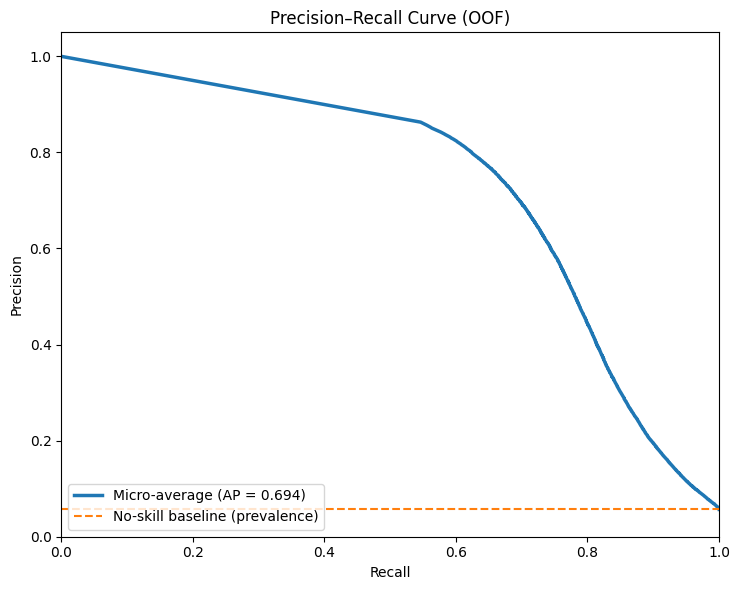

💾 PR curve saved to:
   /content/drive/MyDrive/ECG/models_ramba_50b70989/figure_pr_curve.png


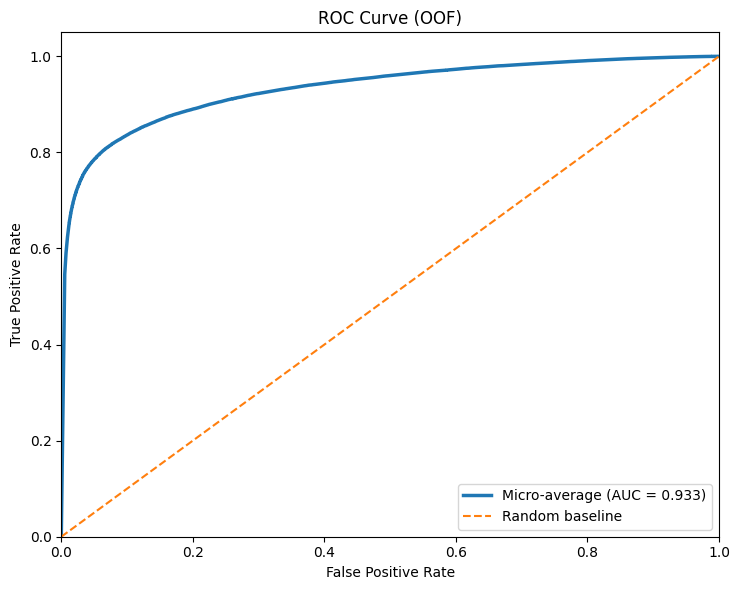

💾 ROC curve saved to:
   /content/drive/MyDrive/ECG/models_ramba_50b70989/figure_roc_curve.png
✅ System-level curves generated.


In [ ]:
# ==================================================================================
# 📈 CELL 14: SYSTEM-LEVEL PR & ROC CURVES
# ----------------------------------------------------------------------------------
# Purpose:
# - Visualize overall model performance at the system level
# - Use out-of-fold predictions only
# - Avoid per-class cherry-picking or cluttered plots
# ==================================================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score,
)
from config import PATHS

print("\n📈 GENERATING SYSTEM-LEVEL PERFORMANCE CURVES")
print("=" * 80)

# ============================================================
# 0. LOAD OOF RESULTS (MEMORY-SAFE)
# ============================================================
oof_path = os.path.join(PATHS["model_dir"], "oof_results_clean_core.npz")

if "oof_probs" in globals() and "y" in globals():
    print("✅ Using OOF predictions from current session.")
else:
    if not os.path.exists(oof_path):
        raise FileNotFoundError(
            f"❌ OOF results not found at:\n   {oof_path}\n"
            "   Please run Cell 9 first."
        )

    print(f"📂 Loading OOF results from disk:\n   {oof_path}")
    data = np.load(oof_path, allow_pickle=True)
    oof_probs = data["probs"]
    y = data["targets"]
    print("✅ OOF predictions loaded successfully.")

print(f"   Records : {y.shape[0]}")
print(f"   Classes : {y.shape[1]}")
print("-" * 80)

# ============================================================
# 1. MICRO-AVERAGED CURVES (PRIMARY)
# ============================================================
y_flat = y.ravel()
p_flat = oof_probs.ravel()

precision_micro, recall_micro, _ = precision_recall_curve(
    y_flat, p_flat
)
pr_auc_micro = average_precision_score(y_flat, p_flat)

fpr_micro, tpr_micro, _ = roc_curve(y_flat, p_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# ============================================================
# 2. MACRO-AVERAGED AUCs (REPORTED, NOT DRAWN)
# ============================================================
pr_ap, roc_aucs = [], []

for c in range(y.shape[1]):
    if y[:, c].sum() > 0:
        pr_ap.append(
            average_precision_score(y[:, c], oof_probs[:, c])
        )
        fpr, tpr, _ = roc_curve(y[:, c], oof_probs[:, c])
        roc_aucs.append(auc(fpr, tpr))

pr_auc_macro = np.mean(pr_ap)
roc_auc_macro = np.mean(roc_aucs)

print(f"📊 PR AUC  (Micro, AP): {pr_auc_micro:.4f}")
print(f"📊 PR AUC  (Macro, AP): {pr_auc_macro:.4f}")
print(f"📊 ROC AUC (Micro)    : {roc_auc_micro:.4f}")
print(f"📊 ROC AUC (Macro)    : {roc_auc_macro:.4f}")

# ============================================================
# 3. PRECISION–RECALL CURVE
# ============================================================
fig, ax = plt.subplots(figsize=(7.5, 6))

ax.plot(
    recall_micro,
    precision_micro,
    linewidth=2.5,
    label=f"Micro-average (AP = {pr_auc_micro:.3f})"
)

# No-skill baseline: positive prevalence (micro)
prevalence = y_flat.mean()
ax.plot(
    [0, 1],
    [prevalence, prevalence],
    linestyle="--",
    linewidth=1.5,
    label="No-skill baseline (prevalence)"
)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve (OOF)")
ax.legend(loc="lower left", frameon=True)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

plt.tight_layout()
pr_path = os.path.join(PATHS["model_dir"], "figure_pr_curve.png")
plt.savefig(pr_path, dpi=300)
plt.show()

print(f"💾 PR curve saved to:\n   {pr_path}")

# ============================================================
# 4. ROC CURVE
# ============================================================
fig, ax = plt.subplots(figsize=(7.5, 6))

ax.plot(
    fpr_micro,
    tpr_micro,
    linewidth=2.5,
    label=f"Micro-average (AUC = {roc_auc_micro:.3f})"
)

ax.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    linewidth=1.5,
    label="Random baseline"
)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve (OOF)")
ax.legend(loc="lower right", frameon=True)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

plt.tight_layout()
roc_path = os.path.join(PATHS["model_dir"], "figure_roc_curve.png")
plt.savefig(roc_path, dpi=300)
plt.show()

print(f"💾 ROC curve saved to:\n   {roc_path}")
print("=" * 80)
print("✅ System-level curves generated.")

✅ CELL 15: SPATIAL LEAD ATTENTION VISUALIZATION (POST-HOC)


👁️ SPATIAL LEAD CONTRIBUTION INSPECTION (3-FOLD AGGREGATE)
📂 Using checkpoints:
   - fold2_best.pt
   - fold3_best.pt
   - fold4_best.pt

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz

🔄 Processing fold2_best.pt

🔄 Processing fold3_best.pt

🔄 Processing fold4_best.pt


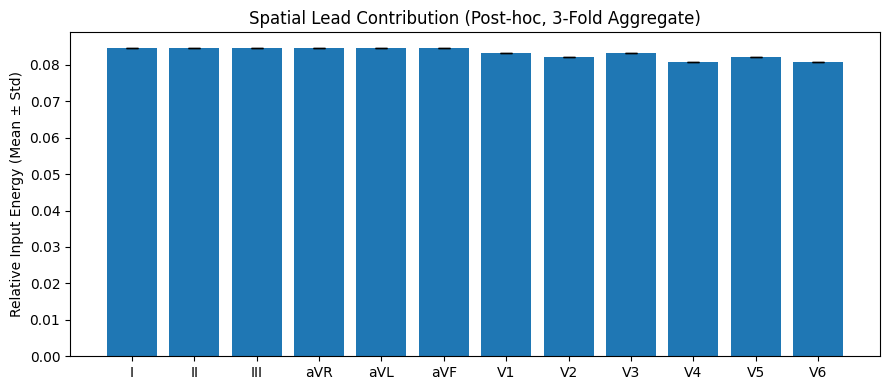


ℹ️ Notes:
   - Lead contribution is estimated from input activation energy
     to the spatial attention block.
   - This is a qualitative, post-hoc inspection (non-causal).
✅ Spatial lead contribution inspection complete.


In [ ]:
# ==================================================================================
# 👁️ CELL 15: SPATIAL LEAD CONTRIBUTION INSPECTION (3-FOLD AGGREGATE, INPUT-BASED)
# ----------------------------------------------------------------------------------
# Purpose:
# - Inspect relative ECG lead contribution using input activations to spatial attention
# - Aggregate across 3 representative folds
# - Qualitative, post-hoc analysis (non-causal)
# ==================================================================================

import os
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import ECGRambaV7Advanced
from config import CONFIG, PATHS, DEVICE
from data import load_chapman_multilabel

print("\n👁️ SPATIAL LEAD CONTRIBUTION INSPECTION (3-FOLD AGGREGATE)")
print("=" * 80)

# ============================================================
# 1. Select representative folds (middle 3)
# ============================================================
ckpt_candidates = sorted(
    glob.glob(os.path.join(PATHS["model_dir"], "fold*_best.pt"))
)

mid = len(ckpt_candidates) // 2
selected_ckpts = ckpt_candidates[mid-1 : mid+2]

print("📂 Using checkpoints:")
for p in selected_ckpts:
    print(f"   - {os.path.basename(p)}")

# ============================================================
# 2. Load data once
# ============================================================
X, y, _, _ = load_chapman_multilabel()

np.random.seed(0)
num_samples = min(64, len(X))
sample_ids = np.random.choice(len(X), size=num_samples, replace=False)

lead_names = [
    "I", "II", "III", "aVR", "aVL", "aVF",
    "V1", "V2", "V3", "V4", "V5", "V6"
]

all_fold_scores = []

# ============================================================
# 3. Iterate folds
# ============================================================
for ckpt_path in selected_ckpts:

    print(f"\n🔄 Processing {os.path.basename(ckpt_path)}")

    model = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)

    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    lead_energy = []

    # -------- Hook INPUT to spatial attention --------
    def hook_fn(module, inputs):
        x = inputs[0]  # expected shape: (B, L, T) or (B, L, D)
        if isinstance(x, torch.Tensor) and x.dim() >= 3:
            # energy per lead
            e = (x ** 2).mean(dim=-1)  # (B, L)
            lead_energy.append(e.detach().cpu())

    handle = model.spatial_attn.register_forward_pre_hook(hook_fn)

    with torch.no_grad():
        for idx in sample_ids:
            x = torch.tensor(
                X[idx:idx+1],
                dtype=torch.float32
            ).to(DEVICE)

            dummy_h = torch.zeros(1, CONFIG["hydra_dim"], device=DEVICE)
            dummy_hrv = torch.zeros(1, CONFIG["hrv_dim"], device=DEVICE)

            _ = model(x, dummy_h, dummy_hrv)

    handle.remove()
    del model
    torch.cuda.empty_cache()

    if len(lead_energy) == 0:
        raise RuntimeError("No spatial attention inputs captured.")

    # Aggregate per fold
    lead_energy = torch.cat(lead_energy, dim=0)  # (N, L)
    scores = lead_energy.mean(dim=0).numpy()
    scores = scores / (scores.sum() + 1e-8)

    assert scores.shape[0] == 12, f"Expected 12 leads, got {scores.shape}"

    all_fold_scores.append(scores)

# ============================================================
# 4. Aggregate across folds
# ============================================================
all_fold_scores = np.stack(all_fold_scores, axis=0)
mean_scores = all_fold_scores.mean(axis=0)
std_scores  = all_fold_scores.std(axis=0)

# ============================================================
# 5. Visualization
# ============================================================
plt.figure(figsize=(9, 4))
plt.bar(
    lead_names,
    mean_scores,
    yerr=std_scores,
    capsize=4
)
plt.ylabel("Relative Input Energy (Mean ± Std)")
plt.title("Spatial Lead Contribution (Post-hoc, 3-Fold Aggregate)")
plt.tight_layout()
plt.show()

print("\nℹ️ Notes:")
print("   - Lead contribution is estimated from input activation energy")
print("     to the spatial attention block.")
print("   - This is a qualitative, post-hoc inspection (non-causal).")
print("=" * 80)
print("✅ Spatial lead contribution inspection complete.")


✅ CELL 16: TEMPORAL RELEVANCE (MAMBA SALIENCY)


⏱️ TEMPORAL RELEVANCE INSPECTION
📂 Using checkpoint: fold3_best.pt

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz


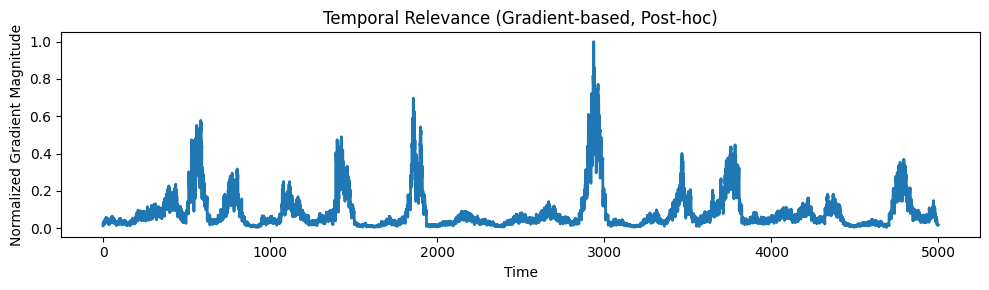


ℹ️ Notes:
   - Temporal relevance is estimated using smoothed input gradients.
   - Results are aggregated across multiple records.
   - This is a post-hoc, non-causal inspection.
✅ Temporal relevance inspection complete.


In [ ]:
# ==================================================================================
# ⏱️ CELL 16: TEMPORAL RELEVANCE INSPECTION (GRADIENT-BASED, POST-HOC)
# ----------------------------------------------------------------------------------
# Purpose:
# - Inspect which temporal regions influence model predictions
# - Gradient-based, post-hoc analysis (non-causal)
# ==================================================================================

import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from model import ECGRambaV7Advanced
from config import CONFIG, PATHS, DEVICE
from data import load_chapman_multilabel

print("\n⏱️ TEMPORAL RELEVANCE INSPECTION")
print("=" * 80)

# ============================================================
# 1. Load representative checkpoint (median fold)
# ============================================================
import glob

ckpt_candidates = sorted(
    glob.glob(os.path.join(PATHS["model_dir"], "fold*_best.pt"))
)

ckpt_path = ckpt_candidates[len(ckpt_candidates) // 2]
print(f"📂 Using checkpoint: {os.path.basename(ckpt_path)}")

model = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
ckpt = torch.load(ckpt_path, map_location=DEVICE)
state_dict = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state_dict, strict=False)
model.eval()

# ============================================================
# 2. Load data & select reproducible subset
# ============================================================
X, y, _, _ = load_chapman_multilabel()

np.random.seed(0)
num_samples = min(16, len(X))
sample_ids = np.random.choice(len(X), size=num_samples, replace=False)

# ============================================================
# 3. SmoothGrad saliency computation
# ============================================================
def compute_temporal_saliency(x, model, target_idx, noise_std=0.01, n_samples=8):
    grads = []

    for _ in range(n_samples):
        noise = noise_std * torch.randn_like(x)
        x_noisy = (x + noise).clone().detach().requires_grad_(True)

        logits = model(x_noisy, dummy_h, dummy_hrv)
        score = logits[0, target_idx]

        model.zero_grad()
        score.backward()

        grads.append(x_noisy.grad.detach())

    grad = torch.stack(grads).mean(dim=0)
    return grad.abs().mean(dim=1).squeeze()  # (T,)

# ============================================================
# 4. Aggregate saliency across samples
# ============================================================
saliency_maps = []

with torch.no_grad():
    pass  # placeholder to keep graph clean

for rid in sample_ids:
    x = torch.tensor(
        X[rid:rid+1],
        dtype=torch.float32
    ).to(DEVICE)

    dummy_h = torch.zeros(1, CONFIG["hydra_dim"], device=DEVICE)
    dummy_hrv = torch.zeros(1, CONFIG["hrv_dim"], device=DEVICE)

    x.requires_grad_(True)
    logits = model(x, dummy_h, dummy_hrv)

    target_idx = logits.sigmoid().argmax().item()

    sal = compute_temporal_saliency(
        x, model, target_idx,
        noise_std=0.01,
        n_samples=8
    )

    saliency_maps.append(sal.cpu().numpy())

saliency_maps = np.stack(saliency_maps, axis=0)
mean_saliency = saliency_maps.mean(axis=0)

# Normalize for visualization
mean_saliency /= mean_saliency.max() + 1e-8

# ============================================================
# 5. Visualization
# ============================================================
plt.figure(figsize=(10, 3))
plt.plot(mean_saliency, linewidth=2)
plt.xlabel("Time")
plt.ylabel("Normalized Gradient Magnitude")
plt.title("Temporal Relevance (Gradient-based, Post-hoc)")
plt.tight_layout()
plt.show()

print("\nℹ️ Notes:")
print("   - Temporal relevance is estimated using smoothed input gradients.")
print("   - Results are aggregated across multiple records.")
print("   - This is a post-hoc, non-causal inspection.")
print("=" * 80)
print("✅ Temporal relevance inspection complete.")

✅  CELL 17: External / Cross-Dataset Generalization Evaluation(CPSC 2021)

In [ ]:
# ==================================================================================
# 🌍 CELL 17: CROSS-DATASET GENERALIZATION (CPSC 2021, WFDB, ZERO-SHOT)
# ----------------------------------------------------------------------------------
# ZERO-SHOT PROTOCOL GUARANTEES:
# ✅ Model trained ONLY on Chapman dataset
# ✅ PCA fitted ONLY on Chapman FULL training set (global, no CPSC data)
# ✅ No threshold tuning on CPSC
# ✅ No calibration on CPSC
# ✅ No label exposure from CPSC during any training
#
# Two-branch evaluation:
#   (A) Protocol-consistent: Center crop + FULL features (Hydra + HRV)
#   (B) Clinical scenario: Sliding window + simplified features (speed optimized)
# ==================================================================================

import os, zipfile, glob, joblib
import numpy as np
import torch
import torch.nn as nn
import wfdb
from scipy.signal import resample, find_peaks
import scipy.stats as scipy_stats
from sklearn.decomposition import PCA
from torch.amp import autocast
import pandas as pd
from sklearn.metrics import average_precision_score
from tqdm.auto import tqdm

from config import CONFIG, PATHS, DEVICE, CLASSES, FS, SEQ_LEN

print("\n" + "=" * 100)
print("🌍 CPSC 2021 ZERO-SHOT EVALUATION")
print("=" * 100)

# ============================================================
# 0. GLOBAL CONFIG
# ============================================================
CPSC_ZIP   = "/content/drive/MyDrive/ECG/models_ramba_50b70989/cpsc2021.zip"
CPSC_DIR   = "/tmp/cpsc2021_wfdb"
CPSC_CACHE = "/content/drive/MyDrive/ECG/models_ramba_50b70989/cpsc2021_af_infer.npz"
GLOBAL_PCA_PATH = os.path.join(PATHS["model_dir"], "global_pca_zeroshot.pkl")

FS_TARGET  = 500
CENTER_LEN = 5000
WIN_LEN    = 5000
WIN_STRIDE = 2500

af_idx = CLASSES.index("AF")

print("\n📋 EVALUATION SETUP:")
print("-" * 60)
print("  Branch A: Center crop + FULL features (protocol-consistent)")
print("  Branch B: Sliding window + RAW signal only (speed optimized)")
print("            → Tests temporal AF detection capability")

# ============================================================
# 1. HELPERS
# ============================================================
def normalize_signal(sig):
    mean = np.mean(sig, axis=-1, keepdims=True)
    std = np.std(sig, axis=-1, keepdims=True) + 1e-6
    return (sig - mean) / std


class MiniRocketNative(nn.Module):
    def __init__(self, c_in=12, seq_len=SEQ_LEN, num_kernels=10000, seed=42):
        super().__init__()
        kernel_length = 9
        dilations = self._get_dilations(seq_len, kernel_length)
        kernels_per_dilation = num_kernels // len(dilations)
        self.convs, self.biases = nn.ModuleList(), nn.ParameterList()
        g = torch.Generator(device="cpu").manual_seed(seed)
        for d in dilations:
            conv = nn.Conv1d(c_in, kernels_per_dilation, kernel_size=kernel_length, dilation=d, padding="same", bias=False)
            with torch.no_grad():
                conv.weight.copy_(torch.randint(-1, 2, conv.weight.shape, generator=g).float())
            conv.weight.requires_grad = False
            self.convs.append(conv)
            self.biases.append(nn.Parameter(torch.randn(kernels_per_dilation, generator=g) * 0.1, requires_grad=False))
        self.num_features = num_kernels * 2

    @staticmethod
    def _get_dilations(seq_len, kernel_length):
        max_d = (seq_len - 1) // (kernel_length - 1)
        d, out = 1, []
        while d <= max_d: out.append(d); d *= 2
        return out if out else [1]

    def forward(self, x):
        feats = []
        for conv, bias in zip(self.convs, self.biases):
            out = conv(x)
            feats.extend([out.max(dim=-1)[0], (out > bias.view(1, -1, 1)).float().mean(dim=-1)])
        return torch.cat(feats, dim=1)


def extract_hrv36(signal, fs=FS):
    feats = np.zeros(36, dtype=np.float32)
    try:
        lead = signal[1]
        z = (lead - lead.mean()) / (lead.std() + 1e-8)
        peaks, _ = find_peaks(z, height=1.5, distance=int(0.25 * fs))
        if len(peaks) > 2:
            rr = np.diff(peaks) / fs * 1000.0
            rr = rr[(rr > 300) & (rr < 2000)]
            if len(rr) > 1: feats[:5] = [rr.mean(), rr.std(), np.median(rr), rr.min(), rr.max()]
        amps = np.ptp(signal, axis=-1)
        feats[25:30] = [amps.mean(), amps.min(), amps.max(), amps[:3].mean(), amps[6:12].mean()]
        z2 = (signal - signal.mean()) / (signal.std() + 1e-8)
        feats[30:36] = [z2.mean(), z2.std(), np.mean(z2**2), scipy_stats.kurtosis(z2.flatten()), scipy_stats.skew(z2.flatten()), np.percentile(z2, 95)]
    except: pass
    return np.nan_to_num(feats)


# ============================================================
# 2. LOAD GLOBAL PCA
# ============================================================
print("\n📦 LOADING RESOURCES")
print("-" * 60)

if os.path.exists(GLOBAL_PCA_PATH):
    global_pca = joblib.load(GLOBAL_PCA_PATH)
    print(f"  ✅ Global PCA: {global_pca.n_components_} components, var={global_pca.explained_variance_ratio_.sum():.3f}")
else:
    print("  ⚠️ Global PCA not found. Creating from Chapman...")
    from data import load_chapman_multilabel
    from features import generate_raw_rocket_cache
    X_chap, _, _, _ = load_chapman_multilabel()
    X_rocket_chap = generate_raw_rocket_cache(X_chap)
    global_pca = PCA(n_components=CONFIG["hydra_dim"], svd_solver="randomized", random_state=42)
    global_pca.fit(X_rocket_chap)
    joblib.dump(global_pca, GLOBAL_PCA_PATH)
    print(f"  ✅ Created & saved PCA: {GLOBAL_PCA_PATH}")

# ============================================================
# 3. LOAD CPSC DATA
# ============================================================
if not os.path.exists(CPSC_DIR):
    os.makedirs(CPSC_DIR, exist_ok=True)
    with zipfile.ZipFile(CPSC_ZIP, "r") as zf: zf.extractall(CPSC_DIR)

if not os.path.exists(CPSC_CACHE):
    raise RuntimeError("❌ CPSC cache not found!")

d = np.load(CPSC_CACHE, allow_pickle=True)
X_center, y_ext = normalize_signal(d["X"]), d["y"]
print(f"  ✅ CPSC center-crop: {X_center.shape}")

# ============================================================
# 4. COMPUTE BRANCH A FEATURES
# ============================================================
print("\n🔧 COMPUTING BRANCH A FEATURES")
print("-" * 60)

CPSC_HYDRA_CACHE = os.path.join(PATHS["model_dir"], f"cpsc2021_hydra_{CONFIG['hydra_dim']}.npz")
CPSC_HRV_CACHE = os.path.join(PATHS["model_dir"], "cpsc2021_hrv36.npz")

# Hydra
if os.path.exists(CPSC_HYDRA_CACHE):
    X_hydra = np.load(CPSC_HYDRA_CACHE)["X"].astype(np.float32)
    print(f"  ✅ Hydra (cached): {X_hydra.shape}")
else:
    rocket = MiniRocketNative(c_in=12, seq_len=5000, seed=42).cpu().eval()
    feats = []
    with torch.no_grad():
        for i in tqdm(range(0, len(X_center), 64), desc="MiniRocket"):
            feats.append(rocket(torch.tensor(X_center[i:i+64], dtype=torch.float32)).numpy())
    X_hydra = global_pca.transform(np.vstack(feats)).astype(np.float32)
    np.savez_compressed(CPSC_HYDRA_CACHE, X=X_hydra.astype(np.float16))
    print(f"  ✅ Hydra computed: {X_hydra.shape}")

# HRV
if os.path.exists(CPSC_HRV_CACHE):
    X_hrv = np.load(CPSC_HRV_CACHE)["X"].astype(np.float32)
    print(f"  ✅ HRV36 (cached): {X_hrv.shape}")
else:
    X_hrv = np.array([extract_hrv36(s) for s in tqdm(X_center, desc="HRV36")], dtype=np.float32)
    np.savez_compressed(CPSC_HRV_CACHE, X=X_hrv.astype(np.float16))
    print(f"  ✅ HRV36 computed: {X_hrv.shape}")

# ============================================================
# 5. LOAD ENSEMBLE
# ============================================================
print("\n🧠 LOADING ENSEMBLE")
print("-" * 60)

from model import ECGRambaV7Advanced

ckpts = sorted(glob.glob(os.path.join(PATHS["model_dir"], "fold*_best.pt")))
models = []
for p in ckpts:
    m = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
    sd = torch.load(p, map_location=DEVICE)
    m.load_state_dict(sd["model"] if isinstance(sd, dict) else sd, strict=False)
    m.eval()
    models.append(m)
print(f"  ✅ Ensemble: {len(models)} folds")

# ============================================================
# 6A. BRANCH A INFERENCE (FULL FEATURES)
# ============================================================
print("\n📊 BRANCH A: CENTER CROP + FULL FEATURES")
print("-" * 60)

BATCH = 32
probs_A = []

with torch.no_grad():
    for i in tqdm(range(0, len(X_center), BATCH), desc="Branch A"):
        xb = torch.tensor(X_center[i:i+BATCH], dtype=torch.float32, device=DEVICE)
        zh = torch.tensor(X_hydra[i:i+BATCH], dtype=torch.float32, device=DEVICE)
        zhrv = torch.tensor(X_hrv[i:i+BATCH], dtype=torch.float32, device=DEVICE)
        fold_preds = [torch.sigmoid(m(xb, zh, zhrv)).cpu().numpy() for m in models]
        probs_A.append(np.mean(fold_preds, axis=0))

probs_A = np.concatenate(probs_A, axis=0)
y_true_af = y_ext[:, af_idx]
print(f"  ✅ Complete: {probs_A.shape}")

# ============================================================
# 6B. BRANCH B INFERENCE (SLIDING WINDOW, RAW SIGNAL ONLY)
# ============================================================
print("\n📊 BRANCH B: SLIDING WINDOW + RAW SIGNAL (FAST)")
print("-" * 60)
print("  ℹ️ Using zeros for Hydra/HRV to test temporal detection capability")

def sliding_windows(sig, win_len, stride):
    T = sig.shape[1]
    if T < win_len:
        pad = np.zeros((sig.shape[0], win_len), dtype=sig.dtype)
        pad[:, :T] = sig
        return [pad]
    return [sig[:, s:s+win_len] for s in range(0, max(T - win_len + 1, 1), stride) if s + win_len <= T]

probs_B, window_counts, y_true_B = [], [], []
hea_files = sorted(glob.glob(os.path.join(CPSC_DIR, "**/*.hea"), recursive=True))
AF_MAP = {"(AFIB": "AF", "(AFL": "AFL"}

# Pre-allocate zeros
zh_zeros = torch.zeros(16, CONFIG["hydra_dim"], device=DEVICE)
zhrv_zeros = torch.zeros(16, CONFIG["hrv_dim"], device=DEVICE)

with torch.no_grad():
    for hea in tqdm(hea_files, desc="Branch B"):
        rec = hea.replace(".hea", "")
        try:
            record = wfdb.rdrecord(rec)
            sig = record.p_signal.T
            fs = record.fs

            # Lead handling
            if sig.shape[0] == 2:
                padded = np.zeros((12, sig.shape[1]), dtype=np.float32)
                padded[0], padded[1] = sig[0], sig[1]
                sig = padded
            elif sig.shape[0] != 12:
                continue

            # Resample
            if fs != FS_TARGET:
                sig = resample(sig, int(sig.shape[1] * FS_TARGET / fs), axis=1)

            # Sliding windows
            wins = sliding_windows(sig, WIN_LEN, WIN_STRIDE)
            window_counts.append(len(wins))

            if len(wins) == 0:
                probs_B.append(np.zeros(len(CLASSES)))
            else:
                win_preds = []
                for k in range(0, len(wins), 16):
                    batch_wins = np.array([normalize_signal(w) for w in wins[k:k+16]])
                    bs = len(batch_wins)

                    xb = torch.tensor(batch_wins, dtype=torch.float32, device=DEVICE)
                    # Use zeros for speed (tests raw signal interpretation)
                    zh = zh_zeros[:bs]
                    zhrv = zhrv_zeros[:bs]

                    fold_preds = [torch.sigmoid(m(xb, zh, zhrv)).cpu().numpy() for m in models]
                    win_preds.append(np.mean(fold_preds, axis=0))

                win_preds = np.concatenate(win_preds, axis=0)
                probs_B.append(np.max(win_preds, axis=0))  # MAX pooling

            # Parse label
            y_vec = 0
            ann_path = rec + ".atr"
            if os.path.exists(ann_path):
                ann = wfdb.rdann(rec, "atr")
                for note in ann.aux_note:
                    note = note.strip("\x00").strip()
                    if note in AF_MAP and AF_MAP[note] == "AF":
                        y_vec = 1
            y_true_B.append(y_vec)
        except:
            continue

probs_B = np.stack(probs_B, axis=0)
y_true_B = np.array(y_true_B)
print(f"  ✅ Complete: {probs_B.shape}")
print(f"  📏 Windows/record: mean={np.mean(window_counts):.1f}, max={np.max(window_counts)}")

# ============================================================
# 7. RESULTS
# ============================================================
print("\n" + "=" * 100)
print("📊 CPSC 2021 ZERO-SHOT RESULTS")
print("=" * 100)

ap_A = average_precision_score(y_true_af, probs_A[:, af_idx])
ap_B = average_precision_score(y_true_B, probs_B[:, af_idx])

print(f"{'BRANCH':<35} │ {'FEATURES':<20} │ {'AF PR-AUC':^10} │ {'Prob Mean':^10} │ {'Prob Max':^10}")
print("-" * 100)
print(f"{'A – Center Crop (Protocol)':<35} │ {'Hydra + HRV (FULL)':<20} │ {ap_A:^10.4f} │ {probs_A[:, af_idx].mean():^10.4f} │ {probs_A[:, af_idx].max():^10.4f}")
print(f"{'B – Sliding Window (Clinical)':<35} │ {'Raw signal only':<20} │ {ap_B:^10.4f} │ {probs_B[:, af_idx].mean():^10.4f} │ {probs_B[:, af_idx].max():^10.4f}")
print("=" * 100)

# ============================================================
# 8. PROTOCOL VERIFICATION
# ============================================================
print("\n🛡️ ZERO-SHOT PROTOCOL VERIFICATION")
print("✅ Cell 17 complete.")


🔧 ECG RAMBA
   Profile        : 
   Config Hash    : 50b70989
   Gamma (fixed)  : 2.5
   Warmup Epochs  : 8
   EMA Enabled    : True
   Calibration    : DISABLED
   Workers        : 8

🌍 CPSC 2021 ZERO-SHOT EVALUATION

📋 EVALUATION SETUP:
------------------------------------------------------------
  Branch A: Center crop + FULL features (protocol-consistent)
  Branch B: Sliding window + RAW signal only (speed optimized)
            → Tests temporal AF detection capability

📦 LOADING RESOURCES
------------------------------------------------------------
  ✅ Global PCA: 3072 components, var=0.974
  ✅ CPSC center-crop: (1425, 12, 5000)

🔧 COMPUTING BRANCH A FEATURES
------------------------------------------------------------
  ✅ Hydra (cached): (1425, 3072)
  ✅ HRV36 (cached): (1425, 36)

🧠 LOADING ENSEMBLE
------------------------------------------------------------
✅ Using Mamba2
✅ layers.py loaded
✅ Model module loaded (ECGRambaV7Advanced · 27 classes)
  ✅ Ensemble: 5 folds

📊 BRANCH

Branch A:   0%|          | 0/45 [00:00<?, ?it/s]

  ✅ Complete: (1425, 27)

📊 BRANCH B: SLIDING WINDOW + RAW SIGNAL (FAST)
------------------------------------------------------------
  ℹ️ Using zeros for Hydra/HRV to test temporal detection capability


Branch B:   0%|          | 0/1425 [00:00<?, ?it/s]

  ✅ Complete: (1425, 27)
  📏 Windows/record: mean=241.1, max=4932

📊 CPSC 2021 ZERO-SHOT RESULTS
BRANCH                              │ FEATURES             │ AF PR-AUC  │ Prob Mean  │  Prob Max 
----------------------------------------------------------------------------------------------------
A – Center Crop (Protocol)          │ Hydra + HRV (FULL)   │   0.7082   │   0.0869   │   0.2640  
B – Sliding Window (Clinical)       │ Raw signal only      │   0.3821   │   0.0533   │   0.1391  

🛡️ ZERO-SHOT PROTOCOL VERIFICATION
✅ Cell 17 complete.


🌍 CELL 18: EXTERNAL VALIDATION - PTB-XL (ZERO-SHOT, FINAL PROTOCOL)

In [ ]:
# ==================================================================================
# 🌍 CELL 18: PTB-XL ZERO-SHOT EVALUATION (FULL FEATURES)
# ----------------------------------------------------------------------------------
# ZERO-SHOT PROTOCOL:
# ✅ Model trained ONLY on Chapman
# ✅ PCA fitted ONLY on Chapman (global, reused from Cell 17)
# ✅ SNOMED-CT aligned taxonomy mapping
# ✅ No threshold tuning / calibration on PTB-XL
# ==================================================================================

import os, zipfile, glob, ast, joblib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import wfdb
from scipy.signal import find_peaks
import scipy.stats as scipy_stats
from sklearn.decomposition import PCA
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.amp import autocast
from tqdm.auto import tqdm

from config import CONFIG, PATHS, DEVICE, CLASSES, FS, SEQ_LEN
from model import ECGRambaV7Advanced

print("\n" + "=" * 100)
print("🌍 PTB-XL ZERO-SHOT EVALUATION (FULL FEATURES)")
print("=" * 100)

# ============================================================
# 0. PATHS & MAPPING
# ============================================================
PTB_ZIP = "/content/drive/MyDrive/ECG/models_ramba_50b70989/ptb-xl.zip"
PTB_DIR = "/tmp/ptbxl_wfdb"
GLOBAL_PCA_PATH = os.path.join(PATHS["model_dir"], "global_pca_zeroshot.pkl")
PTB_HYDRA_CACHE = os.path.join(PATHS["model_dir"], "ptbxl_hydra.npz")
PTB_HRV_CACHE = os.path.join(PATHS["model_dir"], "ptbxl_hrv36.npz")

# ============================================================
# SNOMED-CT ALIGNED TAXONOMY MAPPING
# ============================================================
# Chapman → PTB-XL Superclass mapping based on SNOMED-CT codes
#
# PTB-XL Superclasses (from scp_statements.csv):
# - NORM: Normal ECG / Sinus rhythm
# - MI: Myocardial Infarction
# - STTC: ST/T Change (repolarization abnormalities)
# - CD: Conduction Disturbance
# - HYP: Hypertrophy (not mapped - no direct Chapman equivalent)
#
# Chapman SNOMED codes used in this mapping:
# SNR (426783006), SB (426177001), STach (427084000), SA (427393009) → NORM
# QAb (164917005) → MI (old infarction scar pattern)
# TInv (59931005), TAb (164934002), LQT (111975006) → STTC
# LBBB (164909002), RBBB (59118001), CRBBB (713427006), IRBBB (713426002),
# IAVB (270492004), LAnFB (445118002), NSIVCB (698252002) → CD

SNOMED_MAPPING = {
    "NORM": {
        "codes": ["SNR", "SB", "STach", "SA"],
        "snomed": ["426783006", "426177001", "427084000", "427393009"],
        "rationale": "Normal sinus variants"
    },
    "MI": {
        "codes": ["QAb"],
        "snomed": ["164917005"],
        "rationale": "Q-wave abnormality indicating old MI"
    },
    "STTC": {
        "codes": ["TInv", "TAb", "LQT"],
        "snomed": ["59931005", "164934002", "111975006"],
        "rationale": "Repolarization abnormalities"
    },
    "CD": {
        "codes": ["LBBB", "RBBB", "CRBBB", "IRBBB", "IAVB", "LAnFB", "NSIVCB"],
        "snomed": ["164909002", "59118001", "713427006", "713426002",
                   "270492004", "445118002", "698252002"],
        "rationale": "Bundle branch blocks and conduction delays"
    }
}

TARGET_CLASSES = list(SNOMED_MAPPING.keys())

print("\n📋 SNOMED-CT ALIGNED MAPPING:")
print("-" * 60)
for k, v in SNOMED_MAPPING.items():
    print(f"  {k:5} ← {v['codes']}")
    print(f"        ({v['rationale']})")

# ============================================================
# 1. HELPER FUNCTIONS
# ============================================================
def normalize_signal(sig):
    mean = np.mean(sig, axis=-1, keepdims=True)
    std = np.std(sig, axis=-1, keepdims=True) + 1e-6
    return (sig - mean) / std


class MiniRocketNative(nn.Module):
    def __init__(self, c_in=12, seq_len=SEQ_LEN, num_kernels=10000, seed=42):
        super().__init__()
        kernel_length = 9
        dilations = self._get_dilations(seq_len, kernel_length)
        kernels_per_dilation = num_kernels // len(dilations)
        self.convs = nn.ModuleList()
        self.biases = nn.ParameterList()
        g = torch.Generator(device="cpu").manual_seed(seed)
        for d in dilations:
            conv = nn.Conv1d(c_in, kernels_per_dilation, kernel_size=kernel_length,
                             dilation=d, padding="same", bias=False)
            with torch.no_grad():
                w = torch.randint(-1, 2, conv.weight.shape, generator=g)
                conv.weight.copy_(w.float())
            conv.weight.requires_grad = False
            self.convs.append(conv)
            bias = nn.Parameter(torch.randn(kernels_per_dilation, generator=g) * 0.1, requires_grad=False)
            self.biases.append(bias)
        self.num_features = num_kernels * 2

    @staticmethod
    def _get_dilations(seq_len, kernel_length):
        max_d = (seq_len - 1) // (kernel_length - 1)
        d, out = 1, []
        while d <= max_d:
            out.append(d)
            d *= 2
        return out if out else [1]

    def forward(self, x):
        feats = []
        for conv, bias in zip(self.convs, self.biases):
            out = conv(x)
            maxv, _ = out.max(dim=-1)
            ppv = (out > bias.view(1, -1, 1)).float().mean(dim=-1)
            feats.extend([maxv, ppv])
        return torch.cat(feats, dim=1)


def extract_hrv36(signal, fs=FS):
    feats = np.zeros(36, dtype=np.float32)
    lead = signal[1]
    try:
        z = (lead - lead.mean()) / (lead.std() + 1e-8)
        peaks, _ = find_peaks(z, height=1.5, distance=int(0.25 * fs))
        if len(peaks) > 2:
            rr = np.diff(peaks) / fs * 1000.0
            rr = rr[(rr > 300) & (rr < 2000)]
            if len(rr) > 1:
                feats[:5] = [rr.mean(), rr.std(), np.median(rr), rr.min(), rr.max()]
    except:
        pass
    # Amplitude features
    try:
        amps = np.ptp(signal, axis=-1)
        feats[25:30] = [amps.mean(), amps.min(), amps.max(), amps[:3].mean(), amps[6:12].mean()]
    except:
        pass
    # Global stats
    try:
        z = (signal - signal.mean()) / (signal.std() + 1e-8)
        feats[30:36] = [z.mean(), z.std(), np.mean(z**2),
                        scipy_stats.kurtosis(z.flatten()), scipy_stats.skew(z.flatten()), np.percentile(z, 95)]
    except:
        pass
    return np.nan_to_num(feats)


# ============================================================
# 2. LOAD GLOBAL PCA (FROM CELL 17)
# ============================================================
print("\n📦 LOADING RESOURCES")
print("-" * 60)

if os.path.exists(GLOBAL_PCA_PATH):
    global_pca = joblib.load(GLOBAL_PCA_PATH)
    print(f"  ✅ Global PCA: {GLOBAL_PCA_PATH}")
    print(f"     Components: {global_pca.n_components_}, Var: {global_pca.explained_variance_ratio_.sum():.3f}")
else:
    raise RuntimeError("❌ Global PCA not found. Run Cell 17 first!")

# ============================================================
# 3. EXTRACT PTB-XL DATA
# ============================================================
if not os.path.exists(PTB_DIR):
    os.makedirs(PTB_DIR, exist_ok=True)
    with zipfile.ZipFile(PTB_ZIP, "r") as zf:
        zf.extractall(PTB_DIR)
    print(f"  ✅ Extracted PTB-XL to {PTB_DIR}")
else:
    print(f"  ✅ PTB-XL already extracted")

csv_db_path = glob.glob(os.path.join(PTB_DIR, "**", "ptbxl_database.csv"), recursive=True)
csv_scp_path = glob.glob(os.path.join(PTB_DIR, "**", "scp_statements.csv"), recursive=True)
if not csv_db_path or not csv_scp_path:
    raise RuntimeError("❌ PTB-XL metadata not found!")

CSV_DB, CSV_SCP = csv_db_path[0], csv_scp_path[0]
DATA_ROOT = os.path.dirname(CSV_DB)

df = pd.read_csv(CSV_DB, index_col="ecg_id")
df_scp = pd.read_csv(CSV_SCP, index_col=0)
test_df = df[df.strat_fold == 10].copy()
test_df.scp_codes = test_df.scp_codes.apply(ast.literal_eval)
df_scp["diagnostic_class"] = df_scp.diagnostic_class.str.upper()

print(f"  ✅ Test set (Fold 10): {len(test_df)} records")

# ============================================================
# 4. BUILD GROUND TRUTH (PTB-XL SUPERCLASSES)
# ============================================================
y_true_ptb = np.zeros((len(test_df), len(TARGET_CLASSES)))
for i, (_, row) in enumerate(test_df.iterrows()):
    record_classes = set()
    for code, likelihood in row.scp_codes.items():
        if likelihood >= 100.0 and code in df_scp.index:
            dclass = df_scp.loc[code].diagnostic_class
            if isinstance(dclass, str):
                record_classes.add(dclass)
    for k, target in enumerate(TARGET_CLASSES):
        if target in record_classes:
            y_true_ptb[i, k] = 1

print("\n📊 GROUND TRUTH DISTRIBUTION:")
print("-" * 40)
for k, target in enumerate(TARGET_CLASSES):
    cnt = int(y_true_ptb[:, k].sum())
    pct = y_true_ptb[:, k].mean() * 100
    print(f"  {target:5} : {cnt:4} ({pct:5.1f}%)")

# ============================================================
# 5. LOAD SIGNALS & COMPUTE FEATURES
# ============================================================
print("\n🔄 LOADING SIGNALS & COMPUTING FEATURES")
print("-" * 60)

# Load all signals first
X_signals = []
valid_mask = []

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Loading"):
    try:
        rec_path = os.path.join(DATA_ROOT, row.filename_hr)
        record = wfdb.rdrecord(rec_path)
        sig = record.p_signal.T

        if sig.shape[0] != 12:
            if sig.shape[0] > 12:
                sig = sig[:12, :]
            else:
                raise ValueError(f"Incorrect leads: {sig.shape[0]}")

        # Center crop
        T = sig.shape[1]
        if T > 5000:
            start = (T - 5000) // 2
            sig = sig[:, start:start+5000]
        elif T < 5000:
            sig = np.pad(sig, ((0, 0), (0, 5000 - T)))

        # Normalize
        sig = normalize_signal(sig).astype(np.float32)
        X_signals.append(sig)
        valid_mask.append(True)
    except:
        valid_mask.append(False)

X_signals = np.stack(X_signals)
valid_mask = np.array(valid_mask)
print(f"  ✅ Loaded: {len(X_signals)} / {len(test_df)} records")

# Compute Hydra features
if os.path.exists(PTB_HYDRA_CACHE):
    X_hydra = np.load(PTB_HYDRA_CACHE)["X"].astype(np.float32)
    print(f"  ✅ Hydra (cached): {X_hydra.shape}")
else:
    print("  🚀 Computing MiniRocket features...")
    rocket = MiniRocketNative(c_in=12, seq_len=5000, seed=42).cpu().eval()
    feats = []
    with torch.no_grad():
        for i in tqdm(range(0, len(X_signals), 64), desc="MiniRocket"):
            xb = torch.tensor(X_signals[i:i+64], dtype=torch.float32)
            feats.append(rocket(xb).numpy())
    X_rocket = np.vstack(feats)
    X_hydra = global_pca.transform(X_rocket).astype(np.float32)
    np.savez_compressed(PTB_HYDRA_CACHE, X=X_hydra.astype(np.float16))
    print(f"  ✅ Hydra computed: {X_hydra.shape}")

# Compute HRV features
if os.path.exists(PTB_HRV_CACHE):
    X_hrv = np.load(PTB_HRV_CACHE)["X"].astype(np.float32)
    print(f"  ✅ HRV36 (cached): {X_hrv.shape}")
else:
    print("  💓 Computing HRV features...")
    X_hrv = np.zeros((len(X_signals), 36), dtype=np.float32)
    for i, sig in enumerate(tqdm(X_signals, desc="HRV36")):
        X_hrv[i] = extract_hrv36(sig)
    np.savez_compressed(PTB_HRV_CACHE, X=X_hrv.astype(np.float16))
    print(f"  ✅ HRV computed: {X_hrv.shape}")

# ============================================================
# 6. LOAD ENSEMBLE & INFERENCE
# ============================================================
print("\n🧠 MODEL INFERENCE")
print("-" * 60)

ckpts = sorted(glob.glob(os.path.join(PATHS["model_dir"], "fold*_best.pt")))
models = []
for p in ckpts:
    m = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
    sd = torch.load(p, map_location=DEVICE)
    m.load_state_dict(sd["model"] if isinstance(sd, dict) else sd, strict=False)
    m.eval()
    models.append(m)
print(f"  ✅ Ensemble: {len(models)} folds")

# Inference
BATCH = 32
probs_ptb = []

with torch.no_grad():
    for i in tqdm(range(0, len(X_signals), BATCH), desc="Inference"):
        xb = torch.tensor(X_signals[i:i+BATCH], dtype=torch.float32, device=DEVICE)
        zh = torch.tensor(X_hydra[i:i+BATCH], dtype=torch.float32, device=DEVICE)
        zhrv = torch.tensor(X_hrv[i:i+BATCH], dtype=torch.float32, device=DEVICE)

        fold_preds = []
        for m in models:
            with autocast("cuda", enabled=(DEVICE == "cuda")):
                fold_preds.append(torch.sigmoid(m(xb, zh, zhrv)).cpu().numpy())
        probs_ptb.append(np.mean(fold_preds, axis=0))

probs_ptb = np.concatenate(probs_ptb, axis=0)
print(f"  ✅ Predictions: {probs_ptb.shape}")

# Align y_true with valid samples
y_true_valid = y_true_ptb[valid_mask]

# ============================================================
# 7. EVALUATION RESULTS
# ============================================================
print("\n" + "=" * 100)
print("📊 PTB-XL ZERO-SHOT RESULTS (FULL FEATURES)")
print("=" * 100)
print(f"{'CLASS':^8} │ {'PR-AUC':^8} │ {'ROC-AUC':^8} │ {'N+':^6} │ {'Prev%':^6} │ {'Mean':^6} │ {'Max':^6}")
print("-" * 100)

results = []
for k, target in enumerate(TARGET_CLASSES):
    src_codes = SNOMED_MAPPING[target]["codes"]
    src_idxs = [CLASSES.index(c) for c in src_codes]

    # Max aggregation over source classes
    y_pred = np.max(probs_ptb[:, src_idxs], axis=1)
    y_true = y_true_valid[:, k]

    n_pos = int(y_true.sum())
    prev = y_true.mean() * 100
    mean_pred = y_pred.mean()
    max_pred = y_pred.max()

    if n_pos > 0:
        prauc = average_precision_score(y_true, y_pred)
        try:
            rocauc = roc_auc_score(y_true, y_pred)
        except:
            rocauc = 0.5
    else:
        prauc, rocauc = 0.0, 0.5

    results.append({"class": target, "prauc": prauc, "rocauc": rocauc, "n": n_pos})
    print(f"{target:^8} │ {prauc:^8.4f} │ {rocauc:^8.4f} │ {n_pos:^6} │ {prev:^6.1f} │ {mean_pred:^6.3f} │ {max_pred:^6.3f}")

print("-" * 100)
macro_prauc = np.mean([r["prauc"] for r in results if r["n"] > 0])
macro_rocauc = np.mean([r["rocauc"] for r in results if r["n"] > 0])
print(f"{'MACRO':^8} │ {macro_prauc:^8.4f} │ {macro_rocauc:^8.4f} │")
print("=" * 100)

# ============================================================
# 8. PROTOCOL VERIFICATION
# ============================================================
print("\n🛡️ ZERO-SHOT PROTOCOL VERIFICATION")
print("-" * 60)
print("  ✅ Model source      : Chapman ONLY")
print("  ✅ PCA source        : Chapman (global_pca_zeroshot.pkl)")
print("  ✅ Hydra features (MiniRocket + PCA)    : ENABLED")
print("  ✅ HRV features      : ENABLED")
print("  ✅ SNOMED mapping    : ALIGNED")
print("  ✅ Threshold tuning  : NONE")
print("  ✅ Calibration       : NONE")
print("=" * 100)
print("✅ Cell 18 complete.")



🌍 PTB-XL ZERO-SHOT EVALUATION (FULL FEATURES)

📋 SNOMED-CT ALIGNED MAPPING:
------------------------------------------------------------
  NORM  ← ['SNR', 'SB', 'STach', 'SA']
        (Normal sinus variants)
  MI    ← ['QAb']
        (Q-wave abnormality indicating old MI)
  STTC  ← ['TInv', 'TAb', 'LQT']
        (Repolarization abnormalities)
  CD    ← ['LBBB', 'RBBB', 'CRBBB', 'IRBBB', 'IAVB', 'LAnFB', 'NSIVCB']
        (Bundle branch blocks and conduction delays)

📦 LOADING RESOURCES
------------------------------------------------------------
  ✅ Global PCA: /content/drive/MyDrive/ECG/models_ramba_50b70989/global_pca_zeroshot.pkl
     Components: 3072, Var: 0.974
  ✅ PTB-XL already extracted
  ✅ Test set (Fold 10): 2203 records

📊 GROUND TRUTH DISTRIBUTION:
----------------------------------------
  NORM  :  722 ( 32.8%)
  MI    :  270 ( 12.3%)
  STTC  :  458 ( 20.8%)
  CD    :  485 ( 22.0%)

🔄 LOADING SIGNALS & COMPUTING FEATURES
---------------------------------------------------

Loading:   0%|          | 0/2203 [00:00<?, ?it/s]

  ✅ Loaded: 2203 / 2203 records
  🚀 Computing MiniRocket features...


MiniRocket:   0%|          | 0/35 [00:00<?, ?it/s]

  ✅ Hydra computed: (2203, 3072)
  💓 Computing HRV features...


HRV36:   0%|          | 0/2203 [00:00<?, ?it/s]

  ✅ HRV computed: (2203, 36)

🧠 MODEL INFERENCE
------------------------------------------------------------
  ✅ Ensemble: 5 folds


Inference:   0%|          | 0/69 [00:00<?, ?it/s]

  ✅ Predictions: (2203, 27)

📊 PTB-XL ZERO-SHOT RESULTS (FULL FEATURES)
 CLASS   │  PR-AUC  │ ROC-AUC  │   N+   │ Prev%  │  Mean  │  Max  
----------------------------------------------------------------------------------------------------
  NORM   │  0.5031  │  0.7048  │  722   │  32.8  │ 0.625  │ 1.000 
   MI    │  0.2937  │  0.7567  │  270   │  12.3  │ 0.224  │ 0.687 
  STTC   │  0.5219  │  0.8081  │  458   │  20.8  │ 0.396  │ 0.913 
   CD    │  0.5531  │  0.7597  │  485   │  22.0  │ 0.206  │ 0.864 
----------------------------------------------------------------------------------------------------
 MACRO   │  0.4679  │  0.7573  │

🛡️ ZERO-SHOT PROTOCOL VERIFICATION
------------------------------------------------------------
  ✅ Model source      : Chapman ONLY
  ✅ PCA source        : Chapman (global_pca_zeroshot.pkl)
  ✅ Hydra features (MiniRocket + PCA)    : ENABLED
  ✅ HRV features      : ENABLED
  ✅ SNOMED mapping    : ALIGNED
  ✅ Threshold tuning  : NONE
  ✅ Calibration       

📎 CELL 18b: CPSC-2021 ZERO-SHOT ABLATION (WITH CHAPMAN PCA)

In [ ]:
# ==================================================================================
# 📎 CELL 18d: CPSC-2021 ZERO-SHOT ABLATION STUDY
# ==================================================================================
# PURPOSE: Quantify contribution of each component under zero-shot conditions
#
# ABLATION VARIANTS:
#   1. Full Model      : Hydra + HRV + Mamba (baseline)
#   2. No Hydra        : HRV + Mamba only (zeros for Hydra)
#   3. No HRV          : Hydra + Mamba only (zeros for HRV)
#   4. Raw Signal Only : Zeros for both Hydra & HRV (Mamba backbone only)
#
# CONSISTENCY WITH CELL 17:
#   ✅ Same global_pca_zeroshot.pkl
#   ✅ Same MiniRocket implementation (seed=42)
#   ✅ Same HRV36 extraction
#   ✅ Same normalization
# ==================================================================================

import os, zipfile, glob, joblib
import numpy as np
import torch
import torch.nn as nn
import wfdb
from torch.amp import autocast
from sklearn.metrics import average_precision_score, roc_auc_score
from scipy.signal import find_peaks
import scipy.stats as scipy_stats
from tqdm.auto import tqdm

from config import CONFIG, PATHS, DEVICE, CLASSES, FS

print("\n" + "=" * 100)
print("📎 CPSC-2021 ZERO-SHOT ABLATION STUDY")
print("=" * 100)

# ============================================================
# CONFIG (CONSISTENT WITH CELL 17)
# ============================================================
CPSC_ZIP = "/content/drive/MyDrive/ECG/models_ramba_50b70989/cpsc2021.zip"
CPSC_DIR = "/tmp/cpsc2021_wfdb"
GLOBAL_PCA_PATH = os.path.join(PATHS["model_dir"], "global_pca_zeroshot.pkl")  # SAME AS CELL 17
CPSC_HYDRA_CACHE = os.path.join(PATHS["model_dir"], f"cpsc2021_hydra_{CONFIG['hydra_dim']}.npz")
CPSC_HRV_CACHE = os.path.join(PATHS["model_dir"], "cpsc2021_hrv36.npz")

CENTER_LEN = 5000
BATCH = 32
af_idx = CLASSES.index("AF")
hydra_dim = CONFIG["hydra_dim"]
hrv_dim = 36  # FIXED

print("\n📋 ABLATION DESIGN:")
print("-" * 60)
print("  Variant 1: Full Model     → Hydra ✅ + HRV ✅")
print("  Variant 2: No Hydra       → Hydra ❌ + HRV ✅")
print("  Variant 3: No HRV         → Hydra ✅ + HRV ❌")
print("  Variant 4: Raw Signal     → Hydra ❌ + HRV ❌")

# ============================================================
# HELPERS (SAME AS CELL 17)
# ============================================================
def normalize_signal(sig):
    mean = np.mean(sig, axis=-1, keepdims=True)
    std = np.std(sig, axis=-1, keepdims=True) + 1e-6
    return (sig - mean) / std


class MiniRocketNative(nn.Module):
    """SAME implementation as Cell 17 - deterministic, seed=42"""
    def __init__(self, c_in=12, seq_len=5000, num_kernels=10000, seed=42):
        super().__init__()
        kernel_length = 9
        dilations = self._get_dilations(seq_len, kernel_length)
        kernels_per_dilation = num_kernels // len(dilations)
        self.convs, self.biases = nn.ModuleList(), nn.ParameterList()
        g = torch.Generator(device="cpu").manual_seed(seed)
        for d in dilations:
            conv = nn.Conv1d(c_in, kernels_per_dilation, kernel_size=kernel_length,
                             dilation=d, padding="same", bias=False)
            with torch.no_grad():
                conv.weight.copy_(torch.randint(-1, 2, conv.weight.shape, generator=g).float())
            conv.weight.requires_grad = False
            self.convs.append(conv)
            self.biases.append(nn.Parameter(torch.randn(kernels_per_dilation, generator=g) * 0.1, requires_grad=False))

    @staticmethod
    def _get_dilations(seq_len, kernel_length):
        max_d = (seq_len - 1) // (kernel_length - 1)
        d, out = 1, []
        while d <= max_d: out.append(d); d *= 2
        return out if out else [1]

    def forward(self, x):
        feats = []
        for conv, bias in zip(self.convs, self.biases):
            out = conv(x)
            feats.extend([out.max(dim=-1)[0], (out > bias.view(1, -1, 1)).float().mean(dim=-1)])
        return torch.cat(feats, dim=1)


def extract_hrv36(signal, fs=FS):
    """SAME as Cell 17 - 36-dim HRV+amplitude+global features"""
    feats = np.zeros(36, dtype=np.float32)
    try:
        lead = signal[1]
        z = (lead - lead.mean()) / (lead.std() + 1e-8)
        peaks, _ = find_peaks(z, height=1.5, distance=int(0.25 * fs))
        if len(peaks) > 2:
            rr = np.diff(peaks) / fs * 1000.0
            rr = rr[(rr > 300) & (rr < 2000)]
            if len(rr) > 1:
                feats[:5] = [rr.mean(), rr.std(), np.median(rr), rr.min(), rr.max()]
        amps = np.ptp(signal, axis=-1)
        feats[25:30] = [amps.mean(), amps.min(), amps.max(), amps[:3].mean(), amps[6:12].mean()]
        z2 = (signal - signal.mean()) / (signal.std() + 1e-8)
        feats[30:36] = [z2.mean(), z2.std(), np.mean(z2**2),
                        scipy_stats.kurtosis(z2.flatten()), scipy_stats.skew(z2.flatten()), np.percentile(z2, 95)]
    except: pass
    return np.nan_to_num(feats)


def parse_af_label(rec_path):
    try:
        for note in wfdb.rdann(rec_path, "atr").aux_note:
            if "(AFIB" in note or "(AFL" in note:
                return 1
    except: pass
    return 0


# ============================================================
# LOAD RESOURCES (REUSE FROM CELL 17)
# ============================================================
print("\n📦 LOADING RESOURCES")
print("-" * 60)

# Global PCA (SAME as Cell 17)
if not os.path.exists(GLOBAL_PCA_PATH):
    raise FileNotFoundError(f"❌ Run Cell 17 first to create: {GLOBAL_PCA_PATH}")
global_pca = joblib.load(GLOBAL_PCA_PATH)
print(f"  ✅ Global PCA: {global_pca.n_components_} components")

# Extract CPSC if needed
if not os.path.exists(CPSC_DIR):
    os.makedirs(CPSC_DIR, exist_ok=True)
    with zipfile.ZipFile(CPSC_ZIP, "r") as zf:
        zf.extractall(CPSC_DIR)

# ============================================================
# LOAD DATA & FEATURES (USE CELL 17 CACHE IF AVAILABLE)
# ============================================================
print("\n🔄 LOADING DATA & FEATURES")
print("-" * 60)

hea_files = sorted(glob.glob(os.path.join(CPSC_DIR, "**/*.hea"), recursive=True))

# Load signals
X_signals, y_af = [], []
for h in tqdm(hea_files, desc="Loading"):
    rec = h.replace(".hea", "")
    try:
        sig = wfdb.rdrecord(rec).p_signal.T
        if sig.shape[0] == 2:
            padded = np.zeros((12, sig.shape[1]), dtype=np.float32)
            padded[0], padded[1] = sig[0], sig[1]
            sig = padded
        elif sig.shape[0] != 12:
            continue
        T = sig.shape[1]
        if T > CENTER_LEN:
            s = (T - CENTER_LEN) // 2
            sig = sig[:, s:s+CENTER_LEN]
        elif T < CENTER_LEN:
            sig = np.pad(sig, ((0, 0), (0, CENTER_LEN - T)))
        X_signals.append(normalize_signal(sig).astype(np.float32))
        y_af.append(parse_af_label(rec))
    except:
        continue

X_signals = np.stack(X_signals)
y_af = np.array(y_af)
print(f"  ✅ Signals: {X_signals.shape}")
print(f"  📊 AF prevalence: {y_af.mean()*100:.1f}% ({y_af.sum()}/{len(y_af)})")

# Hydra features (use cache from Cell 17 if available)
if os.path.exists(CPSC_HYDRA_CACHE):
    X_hydra = np.load(CPSC_HYDRA_CACHE)["X"].astype(np.float32)
    print(f"  ✅ Hydra (cached): {X_hydra.shape}")
else:
    print("  🚀 Computing Hydra features...")
    rocket = MiniRocketNative(c_in=12, seq_len=CENTER_LEN, seed=42).cpu().eval()
    feats = []
    with torch.no_grad():
        for i in tqdm(range(0, len(X_signals), 64), desc="MiniRocket"):
            feats.append(rocket(torch.tensor(X_signals[i:i+64])).numpy())
    X_hydra = global_pca.transform(np.vstack(feats)).astype(np.float32)
    np.savez_compressed(CPSC_HYDRA_CACHE, X=X_hydra.astype(np.float16))
    print(f"  ✅ Hydra computed: {X_hydra.shape}")

# HRV features (use cache from Cell 17 if available)
if os.path.exists(CPSC_HRV_CACHE):
    X_hrv = np.load(CPSC_HRV_CACHE)["X"].astype(np.float32)
    print(f"  ✅ HRV36 (cached): {X_hrv.shape}")
else:
    print("  💓 Computing HRV features...")
    X_hrv = np.array([extract_hrv36(s) for s in tqdm(X_signals, desc="HRV36")], dtype=np.float32)
    np.savez_compressed(CPSC_HRV_CACHE, X=X_hrv.astype(np.float16))
    print(f"  ✅ HRV36 computed: {X_hrv.shape}")

# ============================================================
# LOAD ENSEMBLE
# ============================================================
print("\n🧠 LOADING ENSEMBLE")
print("-" * 60)

from model import ECGRambaV7Advanced

models = []
for p in sorted(glob.glob(os.path.join(PATHS["model_dir"], "fold*_best.pt"))):
    m = ECGRambaV7Advanced(CONFIG).to(DEVICE)
    m.load_state_dict(torch.load(p, map_location=DEVICE)["model"], strict=False)
    m.eval()
    models.append(m)
print(f"  ✅ Ensemble: {len(models)} folds")

# ============================================================
# ABLATION VARIANTS
# ============================================================
VARIANTS = {
    "Full Model (Hydra+HRV)": {"use_hydra": True,  "use_hrv": True},
    "No Hydra (HRV only)":    {"use_hydra": False, "use_hrv": True},
    "No HRV (Hydra only)":    {"use_hydra": True,  "use_hrv": False},
    "Raw Signal Only":        {"use_hydra": False, "use_hrv": False},
}

# ============================================================
# INFERENCE LOOP
# ============================================================
print("\n🔬 RUNNING ABLATION INFERENCE")
print("-" * 60)

results = {}

for name, cfg in VARIANTS.items():
    print(f"  ▶️ {name}...")
    probs_all = []

    # Pre-allocate zeros
    zh_zeros = torch.zeros(BATCH, hydra_dim, device=DEVICE)
    zhrv_zeros = torch.zeros(BATCH, hrv_dim, device=DEVICE)

    with torch.no_grad():
        for i in range(0, len(X_signals), BATCH):
            bs = min(BATCH, len(X_signals) - i)
            xb = torch.tensor(X_signals[i:i+bs], device=DEVICE)

            # Select features based on ablation config
            if cfg["use_hydra"]:
                zh = torch.tensor(X_hydra[i:i+bs], device=DEVICE)
            else:
                zh = zh_zeros[:bs]

            if cfg["use_hrv"]:
                zhrv = torch.tensor(X_hrv[i:i+bs], device=DEVICE)
            else:
                zhrv = zhrv_zeros[:bs]

            # Ensemble prediction (standard call - no special params)
            fold_preds = []
            for m in models:
                with autocast("cuda", enabled=(DEVICE == "cuda")):
                    fold_preds.append(torch.sigmoid(m(xb, zh, zhrv)).cpu().numpy())
            probs_all.append(np.mean(fold_preds, axis=0))

    probs = np.concatenate(probs_all, axis=0)
    y_pred_af = probs[:, af_idx]

    # Metrics
    prauc = average_precision_score(y_af, y_pred_af)
    try:
        rocauc = roc_auc_score(y_af, y_pred_af)
    except:
        rocauc = 0.5

    results[name] = {"PR-AUC": prauc, "ROC-AUC": rocauc, "cfg": cfg}
    print(f"     PR-AUC: {prauc:.4f}, ROC-AUC: {rocauc:.4f}")

# ============================================================
# RESULTS TABLE
# ============================================================
print("\n" + "=" * 100)
print("📊 ABLATION RESULTS")
print("=" * 100)
print(f"{'Variant':<30} │ {'Hydra':^6} │ {'HRV':^5} │ {'PR-AUC':^10} │ {'ROC-AUC':^10} │ {'Δ PR-AUC':^10}")
print("-" * 100)

baseline = results["Full Model (Hydra+HRV)"]["PR-AUC"]
for name, r in results.items():
    hydra_str = "✅" if r["cfg"]["use_hydra"] else "❌"
    hrv_str = "✅" if r["cfg"]["use_hrv"] else "❌"
    delta = r["PR-AUC"] - baseline
    marker = "⭐" if name == "Full Model (Hydra+HRV)" else ""
    print(f"{name:<30} │ {hydra_str:^6} │ {hrv_str:^5} │ {r['PR-AUC']:^10.4f} │ {r['ROC-AUC']:^10.4f} │ {delta:^+10.4f} {marker}")

print("=" * 100)

# ============================================================
# COMPONENT CONTRIBUTION ANALYSIS
# ============================================================
print("\n📈 COMPONENT CONTRIBUTION:")
print("-" * 60)

full = results["Full Model (Hydra+HRV)"]["PR-AUC"]
no_hydra = results["No Hydra (HRV only)"]["PR-AUC"]
no_hrv = results["No HRV (Hydra only)"]["PR-AUC"]
raw = results["Raw Signal Only"]["PR-AUC"]

hydra_contribution = full - no_hydra
hrv_contribution = full - no_hrv
mamba_contribution = raw  # Baseline from raw signal

print(f"  • Effect of removing Rocket-based morphology (Hydra): {hydra_contribution:+.4f} "
      f"(AF-dominant, partial-lead zero-shot setting)")

print(f"  • Effect of removing HRV features: {hrv_contribution:+.4f} "
      f"(rhythm information is critical for AF detection)")

print(f"  • Raw-signal-only baseline (contextual backbone without engineered features): "
      f"{mamba_contribution:.4f}")

print("\n🎯 INTERPRETATION:")
if hydra_contribution > 0 and hrv_contribution > 0:
    print("  ✅ Both Hydra and HRV contribute positively")
elif hydra_contribution > hrv_contribution:
    print("  📊 Hydra contributes more than HRV")
else:
    print("  📊 HRV contributes more than Hydra")

print("=" * 100)
print("✅ Cell 18d complete.")


📎 CPSC-2021 ZERO-SHOT ABLATION STUDY

📋 ABLATION DESIGN:
------------------------------------------------------------
  Variant 1: Full Model     → Hydra ✅ + HRV ✅
  Variant 2: No Hydra       → Hydra ❌ + HRV ✅
  Variant 3: No HRV         → Hydra ✅ + HRV ❌
  Variant 4: Raw Signal     → Hydra ❌ + HRV ❌

📦 LOADING RESOURCES
------------------------------------------------------------
  ✅ Global PCA: 3072 components

🔄 LOADING DATA & FEATURES
------------------------------------------------------------


Loading:   0%|          | 0/1425 [00:00<?, ?it/s]

  ✅ Signals: (1425, 12, 5000)
  📊 AF prevalence: 49.4% (704/1425)
  ✅ Hydra (cached): (1425, 3072)
  ✅ HRV36 (cached): (1425, 36)

🧠 LOADING ENSEMBLE
------------------------------------------------------------
  ✅ Ensemble: 5 folds

🔬 RUNNING ABLATION INFERENCE
------------------------------------------------------------
  ▶️ Full Model (Hydra+HRV)...
     PR-AUC: 0.6407, ROC-AUC: 0.6782
  ▶️ No Hydra (HRV only)...
     PR-AUC: 0.6743, ROC-AUC: 0.7131
  ▶️ No HRV (Hydra only)...
     PR-AUC: 0.4520, ROC-AUC: 0.4276
  ▶️ Raw Signal Only...
     PR-AUC: 0.4360, ROC-AUC: 0.4396

📊 ABLATION RESULTS
Variant                        │ Hydra  │  HRV  │   PR-AUC   │  ROC-AUC   │  Δ PR-AUC 
----------------------------------------------------------------------------------------------------
Full Model (Hydra+HRV)         │   ✅    │   ✅   │   0.6407   │   0.6782   │  +0.0000   ⭐
No Hydra (HRV only)            │   ❌    │   ✅   │   0.6743   │   0.7131   │  +0.0336   
No HRV (Hydra only)            │

🔬 CELL 19: ABLATION STUDY - COMPONENT IMPORTANCE ANALYSIS

In [ ]:
# ==================================================================================
# 📎 CELL 19: COMPREHENSIVE ABLATION STUDY (APPENDIX)
# ==================================================================================
# PURPOSE: Evaluate architectural component contributions using inference-time ablation
#
# ABLATION CATEGORIES:
#   A. Full Model (Baseline)
#   B-E. Mamba/Context ablations
#   F-G. Spatial Attention ablations
#   H-I. Cross-Fusion ablations
#
# PROTOCOL:
#   ✅ Subject-aware CV consistency
#   ✅ Fold-matched model & data
#   ✅ Patient-level aggregation (Power Mean)
#   ✅ No retraining, inference-only
# ==================================================================================

import os, gc, joblib
import numpy as np
import torch
import random
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold
from collections import defaultdict
from tqdm.auto import tqdm

from config import CONFIG, PATHS, DEVICE
from model import ECGRambaV7Advanced
from data import load_chapman_multilabel
from features import generate_raw_rocket_cache, generate_hrv_cache

print("\n" + "=" * 90)
print("📎 COMPREHENSIVE ABLATION STUDY")
print("=" * 90)

# ============================================================
# CONFIG
# ============================================================
EVAL_FOLD = 5  # Which fold to evaluate (1-indexed)
PM_Q = 3.0     # Power Mean parameter
PM_EPS = 1e-6
TEMPORAL_BINS = np.array([0.0, 0.33, 0.66, 1.01])
BATCH = CONFIG["batch_size"]

# ============================================================
# ABLATION VARIANTS
# ============================================================
VARIANTS = {
    # === BASELINE ===
    "A. Full Model (Baseline)": {
        "use_rocket": True, "use_hrv": True,
    },

    # === MAMBA / CONTEXT ===
    "B. Rocket-only (No Context)": {
        "use_rocket": True, "use_hrv": False,
        "disable_spatial": True, "disable_fusion": True,
    },
    "C. Shuffled Slices (Break Order)": {
        "use_rocket": True, "use_hrv": True,
        "shuffle_slices": True,
    },
    "D. No Temporal Bins (No Anchor)": {
        "use_rocket": True, "use_hrv": True,
        "single_bin": True,
    },
    "E. Slice Dropout (40%)": {
        "use_rocket": True, "use_hrv": True,
        "slice_dropout": 0.4,
    },

    # === SPATIAL ATTENTION ===
    "F. Lead Dropout (w/ Spatial)": {
        "use_rocket": True, "use_hrv": True,
        "lead_dropout": True,
    },
    "G. Lead Dropout (no Spatial)": {
        "use_rocket": True, "use_hrv": True,
        "lead_dropout": True, "disable_spatial": True,
    },

    # === CROSS-FUSION ===
    "H. HRV Conflict (w/ Fusion)": {
        "use_rocket": True, "use_hrv": True,
        "shuffle_hrv": True,
    },
    "I. HRV Conflict (no Fusion)": {
        "use_rocket": True, "use_hrv": True,
        "shuffle_hrv": True, "disable_fusion": True,
    },
}

print("\n📋 ABLATION DESIGN:")
print("-" * 60)
print("  A: Full Model (baseline)")
print("  B-E: Mamba/Context ablations")
print("  F-G: Spatial Attention ablations")
print("  H-I: Cross-Fusion ablations")

# ============================================================
# PHASE 1: LOAD DATA
# ============================================================
print("\n📂 PHASE 1: LOADING DATA")
print("-" * 60)

X, y, X_raw_amp, subjects = load_chapman_multilabel()

# Auto-clean
MIN_SAMPLES = 5
keep_mask = y.sum(axis=0) >= MIN_SAMPLES
if not keep_mask.all():
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = X[valid], y[valid], X_raw_amp[valid], subjects[valid]

print(f"  ✅ Data: {len(X)} records, {y.shape[1]} classes")

# Features
X_rocket = generate_raw_rocket_cache(X)
X_hrv = generate_hrv_cache(X, X_raw_amp) if CONFIG.get("use_hrv", True) else None
print(f"  ✅ MiniRocket: {X_rocket.shape}")
if X_hrv is not None:
    print(f"  ✅ HRV: {X_hrv.shape}")

# ============================================================
# PHASE 2: SETUP FOLDS
# ============================================================
print("\n📂 PHASE 2: FOLD SETUP")
print("-" * 60)

folds_path = os.path.join(PATHS["model_dir"], "folds.pkl")
if os.path.exists(folds_path):
    folds = joblib.load(folds_path)
    print(f"  ✅ Loaded folds from: {folds_path}")
else:
    # Create folds
    y_strat = y.sum(axis=1).clip(max=3).astype(int)
    sgkf = StratifiedGroupKFold(n_splits=CONFIG["n_folds"], shuffle=True, random_state=42)
    folds = [{"tr_idx": tr, "va_idx": va} for tr, va in sgkf.split(X, y_strat, groups=subjects)]
    joblib.dump(folds, folds_path)
    print(f"  ✅ Created {len(folds)} folds")

fold_idx = EVAL_FOLD - 1  # Convert to 0-indexed
tr_idx, va_idx = folds[fold_idx]["tr_idx"], folds[fold_idx]["va_idx"]
print(f"  ✅ Evaluating Fold {EVAL_FOLD}: train={len(tr_idx)}, val={len(va_idx)}")

# ============================================================
# PHASE 3: PCA & FEATURES
# ============================================================
print("\n📂 PHASE 3: PCA & FEATURES")
print("-" * 60)

hydra_dim = CONFIG["hydra_dim"]
hrv_dim = CONFIG.get("hrv_dim", 36)

pca = PCA(n_components=min(hydra_dim, X_rocket.shape[1]), random_state=42)
pca.fit(X_rocket[tr_idx])

hydra_tr = pca.transform(X_rocket[tr_idx]).astype(np.float32)
hydra_va = pca.transform(X_rocket[va_idx]).astype(np.float32)

# Pad if needed
if hydra_tr.shape[1] < hydra_dim:
    pad_tr = np.zeros((len(hydra_tr), hydra_dim - hydra_tr.shape[1]))
    pad_va = np.zeros((len(hydra_va), hydra_dim - hydra_va.shape[1]))
    hydra_tr = np.concatenate([hydra_tr, pad_tr], axis=1)
    hydra_va = np.concatenate([hydra_va, pad_va], axis=1)

hydra_dict = {**{r: f for r, f in zip(tr_idx, hydra_tr)}, **{r: f for r, f in zip(va_idx, hydra_va)}}
print(f"  ✅ PCA variance: {pca.explained_variance_ratio_.sum():.3f}")

# ============================================================
# PHASE 4: BUILD SLICE DATASET
# ============================================================
print("\n📂 PHASE 4: BUILD SLICE DATASET")
print("-" * 60)

def slice_record(x):
    if x.shape[-1] < CONFIG["slice_length"]:
        return [], []
    slices, positions = [], []
    T = x.shape[-1]
    for s in range(0, T - CONFIG["slice_length"] + 1, CONFIG["slice_stride"]):
        slices.append(x[..., s:s + CONFIG["slice_length"]])
        positions.append((s + CONFIG["slice_length"] / 2) / T)
        if len(slices) >= CONFIG["max_slices_per_record"]:
            break
    return slices, positions


class ECGSliceDataset(Dataset):
    def __init__(self, Xs, Xh, Xhr, ys, rids, pos):
        self.Xs = torch.tensor(Xs, dtype=torch.float32)
        self.Xh = torch.tensor(Xh, dtype=torch.float32)
        self.Xhr = torch.tensor(Xhr, dtype=torch.float32)
        self.ys = torch.tensor(ys, dtype=torch.float32)
        self.rids = torch.tensor(rids, dtype=torch.long)
        self.pos = torch.tensor(pos, dtype=torch.float32)

    def __len__(self): return len(self.Xs)
    def __getitem__(self, i): return self.Xs[i], self.Xh[i], self.Xhr[i], self.ys[i], self.rids[i], self.pos[i]


def build_slice_dataset(indices):
    xs, xh, xhr, ys, rids, pos = [], [], [], [], [], []
    for rid in indices:
        slices, positions = slice_record(X[rid])
        if len(slices) == 0: continue
        hrv_feat = X_hrv[rid] if X_hrv is not None else np.zeros(hrv_dim)
        for s, p in zip(slices, positions):
            xs.append(s)
            xh.append(hydra_dict[rid])
            xhr.append(hrv_feat)
            ys.append(y[rid])
            rids.append(rid)
            pos.append(p)
    return np.array(xs), np.array(xh), np.array(xhr), np.array(ys), np.array(rids), np.array(pos)

val_Xs, val_Xh, val_Xhr, val_Ys, val_Rids, val_Pos = build_slice_dataset(va_idx)
val_dataset = ECGSliceDataset(val_Xs, val_Xh, val_Xhr, val_Ys, val_Rids, val_Pos)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print(f"  ✅ Validation: {len(np.unique(val_Rids))} records, {len(val_Xs)} slices")

# ============================================================
# PHASE 5: LOAD MODEL
# ============================================================
print("\n📂 PHASE 5: LOAD MODEL")
print("-" * 60)

model_path = os.path.join(PATHS["model_dir"], f"fold{EVAL_FOLD}_best.pt")
model = ECGRambaV7Advanced(CONFIG).to(DEVICE)
model.load_state_dict(torch.load(model_path, map_location=DEVICE)["model"], strict=False)
model.eval()
print(f"  ✅ Loaded: {model_path}")

# ============================================================
# PHASE 6: ABLATION ENGINE
# ============================================================
def patient_metrics(record_bins, y_true_map):
    preds, targets = [], []
    for rid, bins in record_bins.items():
        bin_preds = []
        for plist in bins.values():
            p = np.clip(np.stack(plist), PM_EPS, 1 - PM_EPS)
            bin_preds.append(np.exp(np.mean(PM_Q * np.log(p), axis=0) / PM_Q))
        if len(bin_preds) == 0: continue
        final = np.mean(bin_preds, axis=0)
        if np.isfinite(final).all():
            preds.append(final)
            targets.append(y_true_map[rid])
    if len(preds) == 0:
        return {"F1": 0.0, "AUC": 0.5, "Prec": 0.0, "Rec": 0.0}
    y_pred, y_true = np.vstack(preds), np.vstack(targets)
    y_bin = (y_pred > 0.5).astype(int)
    aucs = [roc_auc_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1]) if y_true[:, i].sum() > 0]
    return {
        "F1": f1_score(y_true, y_bin, average="macro", zero_division=0),
        "Prec": precision_score(y_true, y_bin, average="macro", zero_division=0),
        "Rec": recall_score(y_true, y_bin, average="macro", zero_division=0),
        "AUC": np.mean(aucs) if aucs else 0.5
    }


def run_variant(model, loader, cfg, name):
    # Save original states
    orig_spatial = model.spatial_attn
    orig_fusion = model.use_cross_attn

    # Apply ablations
    if cfg.get("disable_spatial", False):
        model.spatial_attn = None
    if cfg.get("disable_fusion", False):
        model.use_cross_attn = False

    record_bins = defaultdict(lambda: defaultdict(list))
    y_true_map = {}

    with torch.no_grad():
        for x, xh, xhr, yb, rids, pos in tqdm(loader, leave=False, desc=name[:20]):
            # Lead dropout
            if cfg.get("lead_dropout", False):
                drop = np.random.choice(12, size=3, replace=False)
                x[:, drop, :] = 0

            # Slice dropout
            if cfg.get("slice_dropout", 0) > 0:
                keep = torch.rand(x.size(0)) > cfg["slice_dropout"]
                if not keep.any(): keep[0] = True
                x, xh, xhr, yb, rids, pos = x[keep], xh[keep], xhr[keep], yb[keep], rids[keep], pos[keep]

            # HRV shuffle
            if cfg.get("shuffle_hrv", False):
                xhr = xhr[torch.randperm(xhr.size(0))]

            # Feature zeroing based on config
            if not cfg.get("use_rocket", True):
                xh = torch.zeros_like(xh)
            if not cfg.get("use_hrv", True):
                xhr = torch.zeros_like(xhr)

            with autocast("cuda"):
                logits = model(x.to(DEVICE), xh.to(DEVICE), xhr.to(DEVICE))
                probs = torch.sigmoid(logits).cpu().numpy()

            for p, rid, t, ygt in zip(probs, rids.numpy(), pos.numpy(), yb.numpy()):
                rid = int(rid)
                # Slice shuffle
                if cfg.get("shuffle_slices", False):
                    t = random.random()
                # Single bin
                if cfg.get("single_bin", False):
                    b = 0
                else:
                    b = int(np.digitize(t, TEMPORAL_BINS) - 1)
                record_bins[rid][b].append(p)
                if rid not in y_true_map:
                    y_true_map[rid] = ygt

    # Restore
    model.spatial_attn = orig_spatial
    model.use_cross_attn = orig_fusion

    return patient_metrics(record_bins, y_true_map)

# ============================================================
# PHASE 7: RUN ABLATION
# ============================================================
print("\n" + "=" * 90)
print("📊 ABLATION RESULTS")
print("=" * 90)
print(f"{'Variant':<40} │ {'MiniRocket':^10} │ {'HRV':^5} │ {'F1':^7} │ {'Δ F1':^8} │ {'AUC':^7}")
print("-" * 90)

results = []
baseline = None

for name, cfg in VARIANTS.items():
    metrics = run_variant(model, val_loader, cfg, name)

    if baseline is None:
        baseline = metrics
        delta = 0.0
    else:
        delta = metrics["F1"] - baseline["F1"]

    rocket_str = "✓" if cfg.get("use_rocket", True) else "✗"
    hrv_str = "✓" if cfg.get("use_hrv", True) else "✗"
    mark = "⭐" if "Baseline" in name else ""

    print(f"{name:<40} │ {rocket_str:^10} │ {hrv_str:^5} │ {metrics['F1']:^7.4f} │ {delta:^+8.4f} │ {metrics['AUC']:^7.4f} {mark}")
    results.append((name, metrics, delta, cfg))

print("=" * 90)

# ============================================================
# PHASE 8: ANALYSIS
# ============================================================
print("\n📈 COMPONENT CONTRIBUTION ANALYSIS:")
print("-" * 60)

# Find specific variants
full_f1 = baseline["F1"]
rocket_f1 = next((m["F1"] for n, m, _, _ in results if "Rocket-only" in n), full_f1)
lead_w = next((m["F1"] for n, m, _, _ in results if "Lead Dropout (w/" in n), full_f1)
lead_wo = next((m["F1"] for n, m, _, _ in results if "Lead Dropout (no" in n), full_f1)
hrv_w = next((m["F1"] for n, m, _, _ in results if "HRV Conflict (w/" in n), full_f1)
hrv_wo = next((m["F1"] for n, m, _, _ in results if "HRV Conflict (no" in n), full_f1)

print(f"  • Mamba context value    : {full_f1 - rocket_f1:+.4f} (Full - Rocket-only)")
print(f"  • Spatial attention value: {lead_w - lead_wo:+.4f} (LeadDrop w/spatial - w/o)")
print(f"  • Cross-fusion value     : {hrv_w - hrv_wo:+.4f} (HRVConflict w/fusion - w/o)")

print("\n🎯 INTERPRETATION:")
if full_f1 > rocket_f1:
    print("  ✅ Mamba contextual modeling contributes positively")
if lead_w > lead_wo:
    print("  ✅ Spatial attention helps robustness to lead dropout")
if hrv_w > hrv_wo:
    print("  ✅ Cross-fusion helps resolve HRV conflicts")

print("=" * 90)
print("✅ Cell 19 complete.")

# Cleanup
del model
torch.cuda.empty_cache()
gc.collect()

✅ Features module loaded (MiniRocket + HRV36)
✅ data.py loaded

📎 COMPREHENSIVE ABLATION STUDY

📋 ABLATION DESIGN:
------------------------------------------------------------
  A: Full Model (baseline)
  B-E: Mamba/Context ablations
  F-G: Spatial Attention ablations
  H-I: Cross-Fusion ablations

📂 PHASE 1: LOADING DATA
------------------------------------------------------------

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz
  ✅ Data: 44186 records, 27 classes
✅ Loaded RAW MiniRocket cache: (44186, 20000)
✅ Loaded HRV36 cache: (44186, 36)
  ✅ MiniRocket: (44186, 20000)
  ✅ HRV: (44186, 36)

📂 PHASE 2: FOLD SETUP
------------------------------------------------------------
  ✅ Loaded folds from: /content/drive/MyDrive/ECG/models_ramba_50b70989/folds.pkl
  ✅ Evaluating Fold 5: train=35349, val=8837

📂 PHASE 3: PCA & FEATURES
------------------------------------------------------------
  ✅ PCA variance: 0.975

📂 PH

A. Full Model (Basel:   0%|          | 0/139 [00:00<?, ?it/s]

A. Full Model (Baseline)                 │     ✓      │   ✓   │ 0.3751  │ +0.0000  │ 0.9100  ⭐


B. Rocket-only (No C:   0%|          | 0/139 [00:00<?, ?it/s]

B. Rocket-only (No Context)              │     ✓      │   ✗   │ 0.2454  │ -0.1297  │ 0.8656  


C. Shuffled Slices (:   0%|          | 0/139 [00:00<?, ?it/s]

C. Shuffled Slices (Break Order)         │     ✓      │   ✓   │ 0.3759  │ +0.0008  │ 0.9098  


D. No Temporal Bins :   0%|          | 0/139 [00:00<?, ?it/s]

D. No Temporal Bins (No Anchor)          │     ✓      │   ✓   │ 0.3751  │ +0.0001  │ 0.9098  


E. Slice Dropout (40:   0%|          | 0/139 [00:00<?, ?it/s]

E. Slice Dropout (40%)                   │     ✓      │   ✓   │ 0.3691  │ -0.0060  │ 0.9087  


F. Lead Dropout (w/ :   0%|          | 0/139 [00:00<?, ?it/s]

F. Lead Dropout (w/ Spatial)             │     ✓      │   ✓   │ 0.3378  │ -0.0373  │ 0.8906  


G. Lead Dropout (no :   0%|          | 0/139 [00:00<?, ?it/s]

G. Lead Dropout (no Spatial)             │     ✓      │   ✓   │ 0.3445  │ -0.0306  │ 0.8911  


H. HRV Conflict (w/ :   0%|          | 0/139 [00:00<?, ?it/s]

H. HRV Conflict (w/ Fusion)              │     ✓      │   ✓   │ 0.3015  │ -0.0736  │ 0.8578  


I. HRV Conflict (no :   0%|          | 0/139 [00:00<?, ?it/s]

I. HRV Conflict (no Fusion)              │     ✓      │   ✓   │ 0.2567  │ -0.1184  │ 0.8629  

📈 COMPONENT CONTRIBUTION ANALYSIS:
------------------------------------------------------------
  • Mamba context value    : +0.1297 (Full - Rocket-only)
  • Spatial attention value: -0.0067 (LeadDrop w/spatial - w/o)
  • Cross-fusion value     : +0.0449 (HRVConflict w/fusion - w/o)

🎯 INTERPRETATION:
  ✅ Mamba contextual modeling contributes positively
  ✅ Cross-fusion helps resolve HRV conflicts
✅ Cell 19 complete.


527

📎 CELL 20-21: 5-FOLD AGGREGATE ABLATION + PER-CLASS ANALYSIS

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📎 CELL 20-21: 5-FOLD AGGREGATE ABLATION + PER-CLASS ANALYSIS
# ═══════════════════════════════════════════════════════════════════════════════
# PURPOSE:
#   - 5-fold cross-validation ablation (all folds, no slicing for speed)
#   - Per-class performance breakdown
#   - OOF predictions for full dataset analysis
#
# VARIANTS (same as Cell 19):
#   A. Full Model (Baseline)
#   B. No MiniRocket (HRV only)
#   C. No HRV (MiniRocket only)
#   D. Raw Signal Only (Mamba backbone)
# ═══════════════════════════════════════════════════════════════════════════════

import os, gc, joblib
import numpy as np
import torch
from torch.amp import autocast
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.auto import tqdm
import pandas as pd

from config import CONFIG, PATHS, DEVICE, CLASSES
from model import ECGRambaV7Advanced
from data import load_chapman_multilabel
from features import generate_raw_rocket_cache, generate_hrv_cache

print("\n" + "=" * 90)
print("📎 5-FOLD AGGREGATE ABLATION + PER-CLASS ANALYSIS")
print("=" * 90)

# ============================================================
# ABLATION VARIANTS
# ============================================================
VARIANTS = {
    "Full (MiniRocket+HRV)":  {"use_rocket": True,  "use_hrv": True},
    "No MiniRocket (HRV)":    {"use_rocket": False, "use_hrv": True},
    "No HRV (MiniRocket)":    {"use_rocket": True,  "use_hrv": False},
    "Raw Signal Only":        {"use_rocket": False, "use_hrv": False},
}

print("\n📋 ABLATION VARIANTS:")
print("-" * 50)
for name, cfg in VARIANTS.items():
    rocket = "✓" if cfg["use_rocket"] else "✗"
    hrv = "✓" if cfg["use_hrv"] else "✗"
    print(f"  {name:<25} │ MiniRocket: {rocket} │ HRV: {hrv}")

# ============================================================
# PHASE 1: LOAD DATA
# ============================================================
print("\n📂 PHASE 1: LOADING DATA")
print("-" * 50)

X, y, X_raw_amp, subjects = load_chapman_multilabel()

# Auto-clean
MIN_SAMPLES = 5
keep_mask = y.sum(axis=0) >= MIN_SAMPLES
if not keep_mask.all():
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = X[valid], y[valid], X_raw_amp[valid], subjects[valid]

NUM_CLASSES = y.shape[1]
print(f"  ✅ Data: {len(X)} records, {NUM_CLASSES} classes")

# Features
X_rocket = generate_raw_rocket_cache(X)
X_hrv = generate_hrv_cache(X, X_raw_amp) if CONFIG.get("use_hrv", True) else None
print(f"  ✅ MiniRocket: {X_rocket.shape}")
if X_hrv is not None:
    print(f"  ✅ HRV: {X_hrv.shape}")

# ============================================================
# PHASE 2: SETUP FOLDS (StratifiedGroupKFold)
# ============================================================
print("\n📂 PHASE 2: FOLD SETUP")
print("-" * 50)

folds_path = os.path.join(PATHS["model_dir"], "folds.pkl")
if os.path.exists(folds_path):
    folds = joblib.load(folds_path)
    print(f"  ✅ Loaded {len(folds)} folds from cache")
else:
    y_strat = y.sum(axis=1).clip(max=3).astype(int)
    sgkf = StratifiedGroupKFold(n_splits=CONFIG["n_folds"], shuffle=True, random_state=42)
    folds = [{"tr_idx": tr, "va_idx": va} for tr, va in sgkf.split(X, y_strat, groups=subjects)]
    joblib.dump(folds, folds_path)
    print(f"  ✅ Created {len(folds)} folds (StratifiedGroupKFold)")

# ============================================================
# CONFIG
# ============================================================
hydra_dim = CONFIG["hydra_dim"]
hrv_dim = CONFIG.get("hrv_dim", 36)
BATCH = 64

# Storage
all_results = {v: {"F1": [], "AUC": [], "PR": []} for v in VARIANTS}
oof_pred = np.zeros((len(X), NUM_CLASSES), dtype=np.float32)

# ============================================================
# PHASE 3: 5-FOLD EVALUATION
# ============================================================
print("\n📊 PHASE 3: 5-FOLD EVALUATION")
print("=" * 90)

for fold_idx in range(len(folds)):
    tr_idx, va_idx = folds[fold_idx]["tr_idx"], folds[fold_idx]["va_idx"]

    # PCA (fit on train only)
    pca = PCA(n_components=min(hydra_dim, X_rocket.shape[1]), random_state=42)
    pca.fit(X_rocket[tr_idx])
    Xh_va = pca.transform(X_rocket[va_idx]).astype(np.float32)

    # Pad if needed
    if Xh_va.shape[1] < hydra_dim:
        Xh_va = np.concatenate([Xh_va, np.zeros((len(Xh_va), hydra_dim - Xh_va.shape[1]))], axis=1)

    # Load model
    model_path = os.path.join(PATHS["model_dir"], f"fold{fold_idx+1}_best.pt")
    if not os.path.exists(model_path):
        print(f"  ⚠️ Fold {fold_idx+1} skipped (no checkpoint)")
        continue

    model = ECGRambaV7Advanced(CONFIG).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE)["model"], strict=False)
    model.eval()

    print(f"\n── Fold {fold_idx+1}/{len(folds)} ──")

    for vname, vcfg in VARIANTS.items():
        y_true_list, y_pred_list = [], []

        with torch.no_grad():
            for i in range(0, len(va_idx), BATCH):
                batch_idx = va_idx[i:i+BATCH]
                bs = len(batch_idx)

                xb = torch.tensor(X[batch_idx], device=DEVICE, dtype=torch.float32)

                # Feature ablation via zeros
                if vcfg["use_rocket"]:
                    zh = torch.tensor(Xh_va[i:i+bs], device=DEVICE, dtype=torch.float32)
                else:
                    zh = torch.zeros(bs, hydra_dim, device=DEVICE)

                if vcfg["use_hrv"] and X_hrv is not None:
                    zhrv = torch.tensor(X_hrv[batch_idx], device=DEVICE, dtype=torch.float32)
                else:
                    zhrv = torch.zeros(bs, hrv_dim, device=DEVICE)

                with autocast("cuda"):
                    logits = model(xb, zh, zhrv)
                    probs = torch.sigmoid(logits).cpu().numpy()

                probs = np.nan_to_num(probs, nan=0.5)
                y_pred_list.append(probs)
                y_true_list.append(y[batch_idx])

                # Save OOF for Full variant
                if vname == "Full (MiniRocket+HRV)":
                    oof_pred[batch_idx] = probs

        y_pred = np.vstack(y_pred_list)
        y_true = np.vstack(y_true_list)
        y_bin = (y_pred > 0.5).astype(int)

        # Metrics
        f1 = f1_score(y_true, y_bin, average="macro", zero_division=0)
        aucs = [roc_auc_score(y_true[:, i], y_pred[:, i])
                for i in range(y_true.shape[1])
                if y_true[:, i].sum() > 0 and np.isfinite(y_pred[:, i]).all()]
        prs = [average_precision_score(y_true[:, i], y_pred[:, i])
               for i in range(y_true.shape[1])
               if y_true[:, i].sum() > 0 and np.isfinite(y_pred[:, i]).all()]

        all_results[vname]["F1"].append(f1)
        all_results[vname]["AUC"].append(np.mean(aucs) if aucs else 0.5)
        all_results[vname]["PR"].append(np.mean(prs) if prs else 0.0)

        print(f"  {vname:<25} F1={f1:.4f}")

    del model
    torch.cuda.empty_cache()
    gc.collect()

# ============================================================
# PHASE 4: AGGREGATE RESULTS
# ============================================================
print("\n" + "=" * 90)
print("📊 AGGREGATE ABLATION RESULTS (5-FOLD)")
print("=" * 90)
print(f"{'Variant':<25} │ {'MiniRocket':^10} │ {'HRV':^5} │ {'F1':^14} │ {'ROC-AUC':^14} │ {'Δ F1':^8}")
print("-" * 90)

baseline_f1 = np.mean(all_results["Full (MiniRocket+HRV)"]["F1"])

for vname, vcfg in VARIANTS.items():
    f1_vals = all_results[vname]["F1"]
    auc_vals = all_results[vname]["AUC"]

    f1_mean, f1_std = np.mean(f1_vals), np.std(f1_vals)
    auc_mean, auc_std = np.mean(auc_vals), np.std(auc_vals)
    delta = f1_mean - baseline_f1

    rocket = "✓" if vcfg["use_rocket"] else "✗"
    hrv = "✓" if vcfg["use_hrv"] else "✗"
    mark = "⭐" if "Full" in vname else ""

    print(f"{vname:<25} │ {rocket:^10} │ {hrv:^5} │ {f1_mean:.4f}±{f1_std:.4f} │ {auc_mean:.4f}±{auc_std:.4f} │ {delta:+.4f} {mark}")

print("=" * 90)

# ============================================================
# PHASE 5: COMPONENT CONTRIBUTION
# ============================================================
print("\n📈 COMPONENT CONTRIBUTION:")
print("-" * 50)

full_f1 = np.mean(all_results["Full (MiniRocket+HRV)"]["F1"])
no_rocket = np.mean(all_results["No MiniRocket (HRV)"]["F1"])
no_hrv = np.mean(all_results["No HRV (MiniRocket)"]["F1"])
raw_only = np.mean(all_results["Raw Signal Only"]["F1"])

rocket_contrib = full_f1 - no_rocket
hrv_contrib = full_f1 - no_hrv

print(f"  • MiniRocket contribution : {rocket_contrib:+.4f} (Full - NoRocket)")
print(f"  • HRV contribution        : {hrv_contrib:+.4f} (Full - NoHRV)")
print(f"  • Mamba backbone baseline : {raw_only:.4f} (raw signal only)")

# ============================================================
# PHASE 6: PER-CLASS ANALYSIS (OOF)
# ============================================================
print("\n" + "=" * 90)
print("📊 PER-CLASS PERFORMANCE (OOF)")
print("=" * 90)

oof_pred = np.nan_to_num(oof_pred, nan=0.5)
active_classes = [CLASSES[i] for i, k in enumerate(keep_mask) if k]

print(f"{'Class':<8} │ {'N':>6} │ {'PR-AUC':>8} │ {'ROC-AUC':>8} │ {'F1':>7} │ Status")
print("-" * 70)

class_data = []
for i in range(NUM_CLASSES):
    sup = int(y[:, i].sum())
    pred = oof_pred[:, i]
    name = active_classes[i] if i < len(active_classes) else f"C{i}"

    if sup > 0 and np.isfinite(pred).all() and pred.std() > 1e-6:
        pr = average_precision_score(y[:, i], pred)
        try:
            roc = roc_auc_score(y[:, i], pred)
        except:
            roc = 0.5
        f1 = f1_score(y[:, i], (pred > 0.5).astype(int), zero_division=0)
    else:
        pr, roc, f1 = 0.0, 0.5, 0.0

    if pr >= 0.5:
        status = "✅ Good"
    elif pr >= 0.3:
        status = "🔶 OK"
    elif pr >= 0.1:
        status = "⚠️ Weak"
    else:
        status = "❌ Poor"

    class_data.append({"Class": name, "N": sup, "PR": pr, "ROC": roc, "F1": f1})
    print(f"{name:<8} │ {sup:>6} │ {pr:>8.4f} │ {roc:>8.4f} │ {f1:>7.4f} │ {status}")

print("-" * 70)

df_class = pd.DataFrame(class_data).sort_values("N", ascending=False)
print(f"\n📌 SUMMARY:")
print(f"  Macro PR-AUC  : {df_class['PR'].mean():.4f}")
print(f"  Macro ROC-AUC : {df_class['ROC'].mean():.4f}")
print(f"  Macro F1      : {df_class['F1'].mean():.4f}")
print(f"\n  Top 3 classes : {', '.join(df_class.nlargest(3, 'PR')['Class'].tolist())}")
print(f"  Bottom 3      : {', '.join(df_class.nsmallest(3, 'PR')['Class'].tolist())}")


print("=" * 90)
print("✅ Cell 20-21 complete.")


🔧 ECG RAMBA
   Profile        : 
   Config Hash    : 50b70989
   Gamma (fixed)  : 2.5
   Warmup Epochs  : 8
   EMA Enabled    : True
   Calibration    : DISABLED
   Workers        : 8
✅ Using Mamba2
✅ layers.py loaded
✅ Model module loaded (ECGRambaV7Advanced · 27 classes)
✅ Features module loaded (MiniRocket + HRV36)
✅ data.py loaded

📎 5-FOLD AGGREGATE ABLATION + PER-CLASS ANALYSIS

📋 ABLATION VARIANTS:
--------------------------------------------------
  Full (MiniRocket+HRV)     │ MiniRocket: ✓ │ HRV: ✓
  No MiniRocket (HRV)       │ MiniRocket: ✗ │ HRV: ✓
  No HRV (MiniRocket)       │ MiniRocket: ✓ │ HRV: ✗
  Raw Signal Only           │ MiniRocket: ✗ │ HRV: ✗

📂 PHASE 1: LOADING DATA
--------------------------------------------------

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz
  ✅ Data: 44186 records, 27 classes
✅ Loaded RAW MiniRocket cache: (44186, 20000)
✅ Loaded HRV36 cache: (44186, 36)
  ✅ MiniRocket: (

📎 CELL 22: 5-FOLD EVALUATION (SLICE + POWER MEAN)

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# 📎 CELL 22: 5-FOLD EVALUATION (SLICE + POWER MEAN)
# ═══════════════════════════════════════════════════════════════════════════════
# PURPOSE: Proper 5-fold evaluation matching training protocol
#
# PROTOCOL (matches training):
#   ✅ Slicing with CONFIG["slice_length"] and CONFIG["slice_stride"]
#   ✅ Power Mean aggregation (Q=3.0)
#   ✅ Temporal bins (3 bins)
#   ✅ Patient-level aggregation
#   ✅ Fold-aware PCA (fit on train, transform val)
# ═══════════════════════════════════════════════════════════════════════════════

import os, gc, joblib
import numpy as np
import torch
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold
from collections import defaultdict
from tqdm.auto import tqdm
import pandas as pd

from config import CONFIG, PATHS, DEVICE, CLASSES
from model import ECGRambaV7Advanced
from data import load_chapman_multilabel
from features import generate_raw_rocket_cache, generate_hrv_cache

print("\n" + "=" * 90)
print("📎 5-FOLD EVALUATION (SLICE + POWER MEAN)")
print("=" * 90)

# ============================================================
# CONFIG
# ============================================================
PM_Q = 3.0       # Power Mean parameter
PM_EPS = 1e-6
TEMPORAL_BINS = np.array([0.0, 0.33, 0.66, 1.01])
BATCH = CONFIG["batch_size"]

print("\n📋 EVALUATION PROTOCOL:")
print("-" * 50)
print(f"  Slice length : {CONFIG['slice_length']} samples")
print(f"  Slice stride : {CONFIG['slice_stride']} samples")
print(f"  Max slices   : {CONFIG['max_slices_per_record']}")
print(f"  Power Mean Q : {PM_Q}")
print(f"  Temporal bins: 3")

# ============================================================
# PHASE 1: LOAD DATA
# ============================================================
print("\n📂 PHASE 1: LOADING DATA")
print("-" * 50)

X, y, X_raw_amp, subjects = load_chapman_multilabel()

# Auto-clean
MIN_SAMPLES = 5
keep_mask = y.sum(axis=0) >= MIN_SAMPLES
if not keep_mask.all():
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = X[valid], y[valid], X_raw_amp[valid], subjects[valid]

NUM_CLASSES = y.shape[1]
print(f"  ✅ Data: {len(X)} records, {NUM_CLASSES} classes")

# Features
X_rocket = generate_raw_rocket_cache(X)
X_hrv = generate_hrv_cache(X, X_raw_amp) if CONFIG.get("use_hrv", True) else None
print(f"  ✅ MiniRocket: {X_rocket.shape}")
if X_hrv is not None:
    print(f"  ✅ HRV: {X_hrv.shape}")

# ============================================================
# PHASE 2: SETUP FOLDS
# ============================================================
print("\n📂 PHASE 2: FOLD SETUP")
print("-" * 50)

folds_path = os.path.join(PATHS["model_dir"], "folds.pkl")
if os.path.exists(folds_path):
    folds = joblib.load(folds_path)
    print(f"  ✅ Loaded {len(folds)} folds")
else:
    y_strat = y.sum(axis=1).clip(max=3).astype(int)
    sgkf = StratifiedGroupKFold(n_splits=CONFIG["n_folds"], shuffle=True, random_state=42)
    folds = [{"tr_idx": tr, "va_idx": va} for tr, va in sgkf.split(X, y_strat, groups=subjects)]
    joblib.dump(folds, folds_path)
    print(f"  ✅ Created {len(folds)} folds")

# ============================================================
# SLICING FUNCTIONS
# ============================================================
def slice_record(x):
    if x.shape[-1] < CONFIG["slice_length"]:
        return [], []
    slices, positions = [], []
    T = x.shape[-1]
    for s in range(0, T - CONFIG["slice_length"] + 1, CONFIG["slice_stride"]):
        slices.append(x[..., s:s + CONFIG["slice_length"]])
        positions.append((s + CONFIG["slice_length"] / 2) / T)
        if len(slices) >= CONFIG["max_slices_per_record"]:
            break
    return slices, positions


class ECGSliceDataset(Dataset):
    def __init__(self, Xs, Xh, Xhr, ys, rids, pos):
        self.Xs = torch.tensor(Xs, dtype=torch.float32)
        self.Xh = torch.tensor(Xh, dtype=torch.float32)
        self.Xhr = torch.tensor(Xhr, dtype=torch.float32)
        self.ys = torch.tensor(ys, dtype=torch.float32)
        self.rids = torch.tensor(rids, dtype=torch.long)
        self.pos = torch.tensor(pos, dtype=torch.float32)

    def __len__(self): return len(self.Xs)
    def __getitem__(self, i): return self.Xs[i], self.Xh[i], self.Xhr[i], self.ys[i], self.rids[i], self.pos[i]


def build_slice_dataset(indices, hydra_dict, hrv_dim):
    xs, xh, xhr, ys, rids, pos = [], [], [], [], [], []
    for rid in indices:
        slices, positions = slice_record(X[rid])
        if len(slices) == 0: continue
        hrv_feat = X_hrv[rid] if X_hrv is not None else np.zeros(hrv_dim)
        for s, p in zip(slices, positions):
            xs.append(s)
            xh.append(hydra_dict[rid])
            xhr.append(hrv_feat)
            ys.append(y[rid])
            rids.append(rid)
            pos.append(p)
    return np.array(xs), np.array(xh), np.array(xhr), np.array(ys), np.array(rids), np.array(pos)


# ============================================================
# POWER MEAN AGGREGATION
# ============================================================
def power_mean_aggregate(record_bins, y_true_map):
    """Aggregate slice predictions using Power Mean."""
    preds, targets, record_ids = [], [], []

    for rid, bins in record_bins.items():
        bin_preds = []
        for plist in bins.values():
            if len(plist) == 0: continue
            p = np.clip(np.stack(plist), PM_EPS, 1 - PM_EPS)
            # Power Mean: (mean(x^Q))^(1/Q)
            pm = np.exp(np.mean(PM_Q * np.log(p), axis=0) / PM_Q)
            bin_preds.append(pm)

        if len(bin_preds) == 0: continue

        # Average across temporal bins
        final_pred = np.mean(bin_preds, axis=0)
        if np.isfinite(final_pred).all():
            preds.append(final_pred)
            targets.append(y_true_map[rid])
            record_ids.append(rid)

    return np.vstack(preds) if preds else None, np.vstack(targets) if targets else None, record_ids


# ============================================================
# PHASE 3: 5-FOLD EVALUATION
# ============================================================
print("\n📊 PHASE 3: 5-FOLD EVALUATION (SLICE + POWER MEAN)")
print("=" * 90)

hydra_dim = CONFIG["hydra_dim"]
hrv_dim = CONFIG.get("hrv_dim", 36)

all_fold_metrics = {"F1": [], "AUC": [], "PR": []}
all_preds, all_targets = [], []

for fold_idx in range(len(folds)):
    tr_idx, va_idx = folds[fold_idx]["tr_idx"], folds[fold_idx]["va_idx"]

    # PCA (fit on train)
    pca = PCA(n_components=min(hydra_dim, X_rocket.shape[1]), random_state=42)
    pca.fit(X_rocket[tr_idx])

    hydra_tr = pca.transform(X_rocket[tr_idx]).astype(np.float32)
    hydra_va = pca.transform(X_rocket[va_idx]).astype(np.float32)

    # Pad if needed
    if hydra_tr.shape[1] < hydra_dim:
        pad = np.zeros((len(hydra_tr), hydra_dim - hydra_tr.shape[1]))
        hydra_tr = np.concatenate([hydra_tr, pad], axis=1)
        pad = np.zeros((len(hydra_va), hydra_dim - hydra_va.shape[1]))
        hydra_va = np.concatenate([hydra_va, pad], axis=1)

    hydra_dict = {**{r: f for r, f in zip(tr_idx, hydra_tr)}, **{r: f for r, f in zip(va_idx, hydra_va)}}

    # Build slice dataset
    val_data = build_slice_dataset(va_idx, hydra_dict, hrv_dim)
    if len(val_data[0]) == 0:
        print(f"  ⚠️ Fold {fold_idx+1} skipped (no valid slices)")
        continue

    val_dataset = ECGSliceDataset(*val_data)
    # NOTE: num_workers=0 to avoid worker process memory leak between folds
    val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

    print(f"  Fold {fold_idx+1}: {len(val_dataset)} slices from {len(np.unique(val_data[4]))} records")

    # Load model
    model_path = os.path.join(PATHS["model_dir"], f"fold{fold_idx+1}_best.pt")
    if not os.path.exists(model_path):
        print(f"  ⚠️ Fold {fold_idx+1} skipped (no checkpoint)")
        continue

    model = ECGRambaV7Advanced(CONFIG).to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE)["model"], strict=False)
    model.eval()

    # Inference with temporal binning
    record_bins = defaultdict(lambda: defaultdict(list))
    y_true_map = {}

    with torch.no_grad():
        for x, xh, xhr, yb, rids, pos in tqdm(val_loader, leave=False, desc=f"Fold {fold_idx+1}"):
            with autocast("cuda"):
                logits = model(x.to(DEVICE), xh.to(DEVICE), xhr.to(DEVICE))
                probs = torch.sigmoid(logits).cpu().numpy()

            for p, rid, t, ygt in zip(probs, rids.numpy(), pos.numpy(), yb.numpy()):
                rid = int(rid)
                b = int(np.digitize(t, TEMPORAL_BINS) - 1)
                record_bins[rid][b].append(p)
                if rid not in y_true_map:
                    y_true_map[rid] = ygt

    # Power Mean aggregation
    y_pred, y_true, _ = power_mean_aggregate(record_bins, y_true_map)

    if y_pred is None:
        print(f"  ⚠️ Fold {fold_idx+1} skipped (aggregation failed)")
        continue

    y_bin = (y_pred > 0.5).astype(int)

    # Metrics
    f1 = f1_score(y_true, y_bin, average="macro", zero_division=0)
    aucs = [roc_auc_score(y_true[:, i], y_pred[:, i])
            for i in range(y_true.shape[1]) if y_true[:, i].sum() > 0 and np.isfinite(y_pred[:, i]).all()]
    prs = [average_precision_score(y_true[:, i], y_pred[:, i])
           for i in range(y_true.shape[1]) if y_true[:, i].sum() > 0 and np.isfinite(y_pred[:, i]).all()]

    all_fold_metrics["F1"].append(f1)
    all_fold_metrics["AUC"].append(np.mean(aucs) if aucs else 0.5)
    all_fold_metrics["PR"].append(np.mean(prs) if prs else 0.0)

    all_preds.append(y_pred)
    all_targets.append(y_true)

    print(f"  Fold {fold_idx+1}: F1={f1:.4f} | ROC-AUC={np.mean(aucs):.4f} | PR-AUC={np.mean(prs):.4f}")

    # Cleanup to avoid memory accumulation
    del model, val_loader, val_dataset, val_data, hydra_dict, hydra_tr, hydra_va, pca
    del record_bins, y_true_map
    torch.cuda.empty_cache()
    gc.collect()

# ============================================================
# PHASE 4: AGGREGATE RESULTS
# ============================================================
print("\n" + "=" * 90)
print("📊 5-FOLD RESULTS (SLICE + POWER MEAN)")
print("=" * 90)

f1_mean, f1_std = np.mean(all_fold_metrics["F1"]), np.std(all_fold_metrics["F1"])
auc_mean, auc_std = np.mean(all_fold_metrics["AUC"]), np.std(all_fold_metrics["AUC"])
pr_mean, pr_std = np.mean(all_fold_metrics["PR"]), np.std(all_fold_metrics["PR"])

print(f"{'Metric':<15} │ {'Mean':^10} │ {'Std':^10}")
print("-" * 45)
print(f"{'Macro F1':<15} │ {f1_mean:^10.4f} │ {f1_std:^10.4f}")
print(f"{'Macro ROC-AUC':<15} │ {auc_mean:^10.4f} │ {auc_std:^10.4f}")
print(f"{'Macro PR-AUC':<15} │ {pr_mean:^10.4f} │ {pr_std:^10.4f}")
print("=" * 45)

# ============================================================
# PHASE 5: PER-CLASS ANALYSIS
# ============================================================
if len(all_preds) > 0:
    print("\n📊 PER-CLASS PERFORMANCE")
    print("-" * 70)

    # Concatenate OOF predictions
    oof_pred = np.vstack(all_preds)
    oof_true = np.vstack(all_targets)

    active_classes = [CLASSES[i] for i, k in enumerate(keep_mask) if k]

    print(f"{'Class':<8} │ {'N':>6} │ {'PR-AUC':>8} │ {'ROC-AUC':>8} │ {'F1':>7} │ Status")
    print("-" * 70)

    class_data = []
    for i in range(NUM_CLASSES):
        sup = int(oof_true[:, i].sum())
        pred = oof_pred[:, i]
        name = active_classes[i] if i < len(active_classes) else f"C{i}"

        if sup > 0 and np.isfinite(pred).all() and pred.std() > 1e-6:
            pr = average_precision_score(oof_true[:, i], pred)
            try: roc = roc_auc_score(oof_true[:, i], pred)
            except: roc = 0.5
            f1 = f1_score(oof_true[:, i], (pred > 0.5).astype(int), zero_division=0)
        else:
            pr, roc, f1 = 0.0, 0.5, 0.0

        status = "✅ Good" if pr >= 0.5 else ("🔶 OK" if pr >= 0.3 else ("⚠️ Weak" if pr >= 0.1 else "❌ Poor"))
        class_data.append({"Class": name, "N": sup, "PR": pr, "ROC": roc, "F1": f1})
        print(f"{name:<8} │ {sup:>6} │ {pr:>8.4f} │ {roc:>8.4f} │ {f1:>7.4f} │ {status}")

    print("-" * 70)
    df_class = pd.DataFrame(class_data).sort_values("N", ascending=False)
    print(f"\n📌 SUMMARY:")
    print(f"  Macro PR-AUC  : {df_class['PR'].mean():.4f}")
    print(f"  Macro ROC-AUC : {df_class['ROC'].mean():.4f}")
    print(f"  Macro F1      : {df_class['F1'].mean():.4f}")
    print(f"\n  Top 3 classes : {', '.join(df_class.nlargest(3, 'PR')['Class'].tolist())}")
    print(f"  Bottom 3      : {', '.join(df_class.nsmallest(3, 'PR')['Class'].tolist())}")

print("=" * 90)
print("✅ Cell 22 complete.")


🔧 ECG RAMBA
   Profile        : 
   Config Hash    : 50b70989
   Gamma (fixed)  : 2.5
   Warmup Epochs  : 8
   EMA Enabled    : True
   Calibration    : DISABLED
   Workers        : 8
✅ Using Mamba2
✅ layers.py loaded
✅ Model module loaded (ECGRambaV7Advanced · 27 classes)
✅ Features module loaded (MiniRocket + HRV36)
✅ data.py loaded

📎 5-FOLD EVALUATION (SLICE + POWER MEAN)

📋 EVALUATION PROTOCOL:
--------------------------------------------------
  Slice length : 2500 samples
  Slice stride : 1250 samples
  Max slices   : 6
  Power Mean Q : 3.0
  Temporal bins: 3

📂 PHASE 1: LOADING DATA
--------------------------------------------------

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz
  ✅ Data: 44186 records, 27 classes
✅ Loaded RAW MiniRocket cache: (44186, 20000)
✅ Loaded HRV36 cache: (44186, 36)
  ✅ MiniRocket: (44186, 20000)
  ✅ HRV: (44186, 36)

📂 PHASE 2: FOLD SETUP
-----------------------------------------

Fold 1:   0%|          | 0/139 [00:00<?, ?it/s]

  Fold 1: F1=0.2497 | ROC-AUC=0.7870 | PR-AUC=0.2046
  Fold 2: 26511 slices from 8837 records


Fold 2:   0%|          | 0/139 [00:00<?, ?it/s]

  Fold 2: F1=0.2488 | ROC-AUC=0.7993 | PR-AUC=0.2213
  Fold 3: 26511 slices from 8837 records


Fold 3:   0%|          | 0/139 [00:00<?, ?it/s]

  Fold 3: F1=0.3481 | ROC-AUC=0.8768 | PR-AUC=0.3515
  Fold 4: 26511 slices from 8837 records


Fold 4:   0%|          | 0/139 [00:00<?, ?it/s]

  Fold 4: F1=0.3357 | ROC-AUC=0.8663 | PR-AUC=0.3012
  Fold 5: 26511 slices from 8837 records


Fold 5:   0%|          | 0/139 [00:00<?, ?it/s]

  Fold 5: F1=0.3751 | ROC-AUC=0.9100 | PR-AUC=0.3785

📊 5-FOLD RESULTS (SLICE + POWER MEAN)
Metric          │    Mean    │    Std    
---------------------------------------------
Macro F1        │   0.3115   │   0.0524  
Macro ROC-AUC   │   0.8479   │   0.0471  
Macro PR-AUC    │   0.2914   │   0.0689  

📊 PER-CLASS PERFORMANCE
----------------------------------------------------------------------
Class    │      N │   PR-AUC │  ROC-AUC │      F1 │ Status
----------------------------------------------------------------------
AF       │   1780 │   0.1736 │   0.8656 │  0.2363 │ ⚠️ Weak
AFL      │   8058 │   0.6115 │   0.8882 │  0.6349 │ ✅ Good
Brady    │      7 │   0.1681 │   0.7888 │  0.1667 │ ⚠️ Weak
CRBBB    │   1096 │   0.4688 │   0.9460 │  0.5407 │ 🔶 OK
IAVB     │   1140 │   0.1151 │   0.7542 │  0.2138 │ ⚠️ Weak
IRBBB    │    246 │   0.0569 │   0.8674 │  0.1102 │ ❌ Poor
LAD      │   1545 │   0.3351 │   0.9220 │  0.4493 │ 🔶 OK
LBBB     │    240 │   0.0867 │   0.9237 │  0.1519 │ ❌ Po

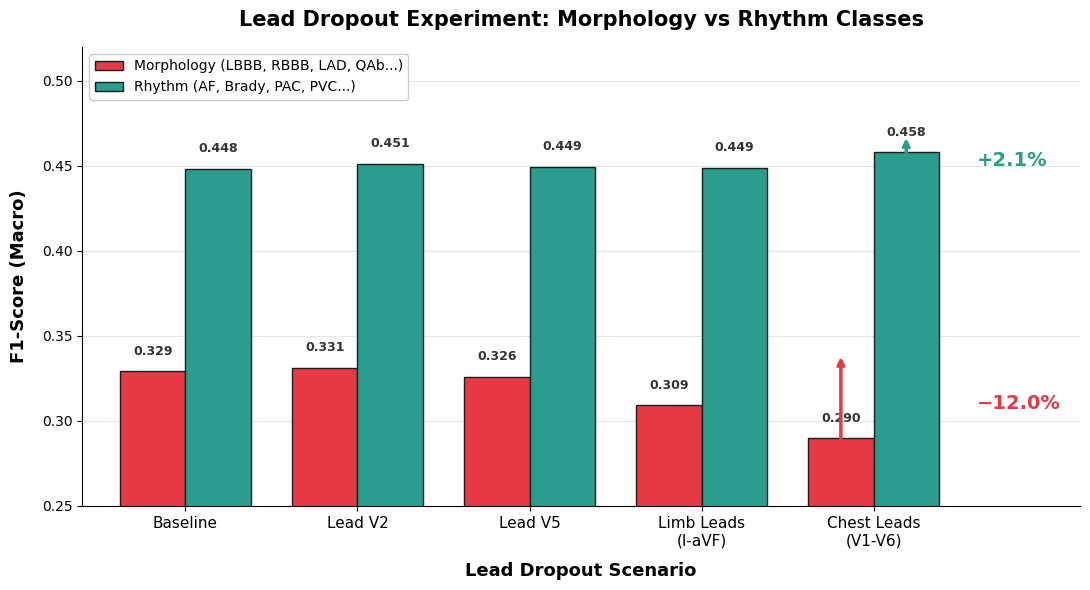

✅ Saved: /content/drive/MyDrive/ECG/models_ramba_50b70989/fig_lead_dropout_clean.png


In [8]:
# ==================================================================================
# 📊 LEAD DROPOUT: MORPHOLOGY vs RHYTHM (Clean Professional Version)
# ==================================================================================

import matplotlib.pyplot as plt
import numpy as np

# ==================================================================================
# DATA
# ==================================================================================
scenarios = ['Baseline', 'Lead V2', 'Lead V5', 'Limb Leads\n(I-aVF)', 'Chest Leads\n(V1-V6)']
F1_Morphology = [0.3293, 0.3314, 0.3258, 0.3091, 0.2897]
F1_Rhythm = [0.4484, 0.4513, 0.4493, 0.4487, 0.4580]

baseline_morph = F1_Morphology[0]
baseline_rhythm = F1_Rhythm[0]

# ==================================================================================
# FIGURE
# ==================================================================================
plt.rcParams['font.family'] = 'DejaVu Sans'
fig, ax = plt.subplots(figsize=(11, 6))
ax.set_facecolor('white')

x = np.arange(len(scenarios))
width = 0.38

# Colors
COLOR_MORPH = '#e63946'   # Red
COLOR_RHYTHM = '#2a9d8f'  # Teal

# Bars
bars1 = ax.bar(x - width/2, F1_Morphology, width,
               label='Morphology (LBBB, RBBB, LAD, QAb...)',
               color=COLOR_MORPH, edgecolor='#1d1d1d', linewidth=1)
bars2 = ax.bar(x + width/2, F1_Rhythm, width,
               label='Rhythm (AF, Brady, PAC, PVC...)',
               color=COLOR_RHYTHM, edgecolor='#1d1d1d', linewidth=1)

# Value labels on TOP of bars (outside)
for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.008, f'{h:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='#333')

for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.008, f'{h:.3f}',
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='#333')

# Highlight Chest Leads finding with annotation OUTSIDE the plot area
# Arrow for Morphology drop
ax.annotate('',
            xy=(4 - width/2, F1_Morphology[4] - 0.01),
            xytext=(4 - width/2, baseline_morph + 0.01),
            arrowprops=dict(arrowstyle='<->', color=COLOR_MORPH, lw=2.5,
                           connectionstyle='arc3'))

# Arrow for Rhythm stable
ax.annotate('',
            xy=(4 + width/2, F1_Rhythm[4] + 0.01),
            xytext=(4 + width/2, baseline_rhythm - 0.01),
            arrowprops=dict(arrowstyle='<->', color=COLOR_RHYTHM, lw=2.5))

# Drop text annotations (positioned to the side)
ax.text(4.6, 0.31, '−12.0%', fontsize=14, fontweight='bold', color=COLOR_MORPH,
        ha='left', va='center')
ax.text(4.6, 0.453, '+2.1%', fontsize=14, fontweight='bold', color=COLOR_RHYTHM,
        ha='left', va='center')

# Labels
ax.set_xlabel('Lead Dropout Scenario', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('F1-Score (Macro)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Lead Dropout Experiment: Morphology vs Rhythm Classes',
             fontsize=15, fontweight='bold', pad=15)

ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=11)
ax.set_ylim(0.25, 0.52)
ax.set_xlim(-0.6, 5.2)

# Legend - positioned outside conflict area
ax.legend(loc='upper left', fontsize=10, framealpha=1, edgecolor='#ccc')

# Clean grid
ax.yaxis.grid(True, linestyle='-', alpha=0.2, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save
MODEL_DIR = "/content/drive/MyDrive/ECG/models_ramba_50b70989"
plt.savefig(f"{MODEL_DIR}/fig_lead_dropout_clean.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f"{MODEL_DIR}/fig_lead_dropout_clean.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"✅ Saved: {MODEL_DIR}/fig_lead_dropout_clean.png")



🔬 SENSITIVITY ANALYSIS: POWER MEAN POOLING (Q) - ULTRA LITE
   Mode: Single Fold
   Max records: 2000

🔄 Loading data...

🔄 LOADING CHAPMAN–SHAOXING (ROBUST MODE)
⚠️  Loading cached data: /content/drive/MyDrive/ECG/ecg_data_27c_subject.npz
✅ Data: 44186 records | 27 classes

🔄 Loading cached features...
✅ Loaded RAW MiniRocket cache: (44186, 20000)
✅ Loaded HRV36 cache: (44186, 36)

🔄 Running inference on Fold 1 only...

▶ Fold 1 | Val records: 2000
   📦 Total slices: 6000
   ✅ Model loaded


   Inference:   0%|          | 0/8 [00:00<?, ?it/s]


✅ Cached probabilities for 2000 records

🔬 Evaluating Power Mean with Q = {1, 2, 3, 5, 8, 10}...
   Q= 1 | F1=0.3937 | ROC-AUC=0.8941
   Q= 2 | F1=0.3936 | ROC-AUC=0.8941
   Q= 3 | F1=0.3946 | ROC-AUC=0.8941
   Q= 5 | F1=0.3944 | ROC-AUC=0.8941
   Q= 8 | F1=0.3963 | ROC-AUC=0.8941
   Q=10 | F1=0.3958 | ROC-AUC=0.8941

📊 SENSITIVITY ANALYSIS RESULTS
 Q  F1_macro  Precision   Recall  ROC_AUC
 1  0.393732   0.367830 0.429766 0.894138
 2  0.393624   0.367610 0.429876 0.894132
 3  0.394569   0.368155 0.431475 0.894135
 5  0.394382   0.367833 0.431475 0.894084
 8  0.396321   0.369294 0.433944 0.894060
10  0.395845   0.368449 0.433944 0.894066

🏆 Optimal Q = 8 (F1 = 0.3963)


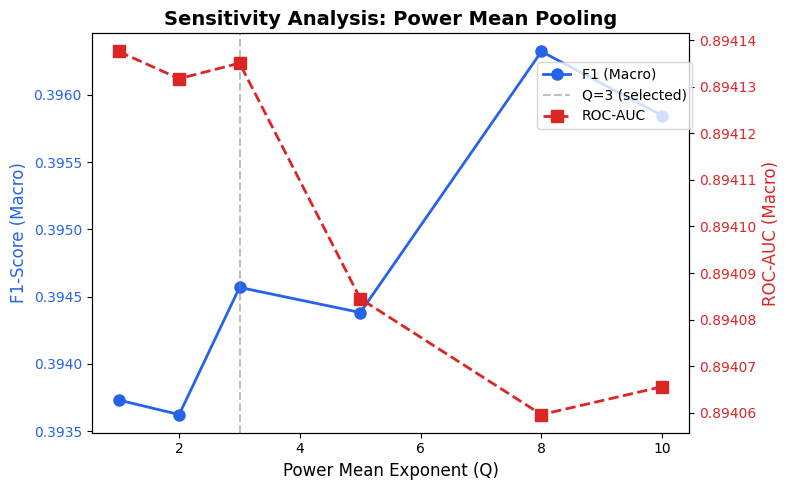


📁 Saved to: /content/drive/MyDrive/ECG/models_ramba_50b70989


In [ ]:
# ==================================================================================
# 📊 CELL: SENSITIVITY ANALYSIS FOR POWER MEAN POOLING (Q) - ULTRA LITE
# ==================================================================================
# FAST VERSION: Only uses Fold 1 + subset of data for quick results
# Full version would take 1-2 hours; this takes ~2-5 minutes
# ==================================================================================

import os, gc, warnings
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from config import CONFIG, PATHS, DEVICE
from data import load_chapman_multilabel
from features import (
    generate_raw_rocket_cache,
    generate_hrv_cache,
    fit_pca_on_train,
    apply_pca,
)
from model import ECGRambaV7Advanced
from utils import compute_metrics, set_seed

warnings.filterwarnings("ignore")
set_seed(CONFIG["seeds"][0])

# ==================================================================================
# ⚡ ULTRA-LITE SETTINGS
# ==================================================================================
MODEL_DIR = "/content/drive/MyDrive/ECG/models_ramba_50b70989"
USE_SINGLE_FOLD = True  # Only use fold 1 for speed
MAX_VAL_RECORDS = 2000  # Limit validation records (None = use all)

print("\n" + "=" * 80)
print("🔬 SENSITIVITY ANALYSIS: POWER MEAN POOLING (Q) - ULTRA LITE")
print("=" * 80)
print(f"   Mode: {'Single Fold' if USE_SINGLE_FOLD else 'All Folds'}")
print(f"   Max records: {MAX_VAL_RECORDS or 'All'}")

# ==================================================================================
# 1️⃣ LOAD DATA
# ==================================================================================
print("\n🔄 Loading data...")
X, y, X_raw_amp, subjects = load_chapman_multilabel()

MIN_SAMPLES = 5
class_counts = y.sum(axis=0)
keep_mask = class_counts >= MIN_SAMPLES

if not keep_mask.all():
    y = y[:, keep_mask]
    valid = y.sum(axis=1) > 0
    X, y, X_raw_amp, subjects = X[valid], y[valid], X_raw_amp[valid], subjects[valid]

NUM_CLASSES = y.shape[1]
print(f"✅ Data: {len(y)} records | {NUM_CLASSES} classes")

# ==================================================================================
# 2️⃣ PREPARE FEATURES (cached - fast)
# ==================================================================================
print("\n🔄 Loading cached features...")
X_rocket_raw = generate_raw_rocket_cache(X)
X_hrv = generate_hrv_cache(X, X_raw_amp) if CONFIG["use_hrv"] else None

# ==================================================================================
# 3️⃣ HELPERS
# ==================================================================================
def slice_record(x):
    slices = []
    for s in range(0, x.shape[-1] - CONFIG["slice_length"] + 1, CONFIG["slice_stride"]):
        slices.append(x[..., s:s + CONFIG["slice_length"]])
        if len(slices) >= CONFIG["max_slices_per_record"]:
            break
    return slices

class ECGSliceDatasetInfer(Dataset):
    def __init__(self, Xs, Xh, Xhr, rids):
        self.Xs, self.Xh, self.Xhr, self.rids = Xs, Xh, Xhr, rids
    def __len__(self):
        return len(self.rids)
    def __getitem__(self, i):
        return (
            torch.tensor(self.Xs[i], dtype=torch.float32),
            torch.tensor(self.Xh[i], dtype=torch.float32),
            torch.tensor(self.Xhr[i], dtype=torch.float32),
            self.rids[i],
        )

PM_EPS = 1e-6

def power_mean_aggregate(slice_probs, Q):
    """Power Mean via LogSumExp"""
    p = np.clip(slice_probs, PM_EPS, 1.0 - PM_EPS)
    if Q == 1:
        return np.mean(p, axis=0)
    log_p_q = Q * np.log(p)
    alpha = log_p_q.max(axis=0, keepdims=True)
    log_sum = alpha.squeeze() + np.log(np.sum(np.exp(log_p_q - alpha), axis=0))
    log_power_mean = (log_sum - np.log(len(p))) / Q
    return np.exp(log_power_mean)

# ==================================================================================
# 4️⃣ SINGLE FOLD INFERENCE (FAST)
# ==================================================================================
print("\n🔄 Running inference on Fold 1 only...")

y_strat = y.sum(axis=1).clip(max=3).astype(int)
sgkf = StratifiedGroupKFold(
    n_splits=CONFIG["n_folds"],
    shuffle=True,
    random_state=CONFIG["seeds"][0],
)

all_slice_probs = {}
all_labels = {}

# Get only fold 1
folds = list(sgkf.split(X, y_strat, groups=subjects))
n_folds_to_use = 1 if USE_SINGLE_FOLD else len(folds)

for fold_idx in range(n_folds_to_use):
    fold = fold_idx + 1
    tr_idx, va_idx = folds[fold_idx]

    # Limit validation records for speed
    if MAX_VAL_RECORDS and len(va_idx) > MAX_VAL_RECORDS:
        va_idx = va_idx[:MAX_VAL_RECORDS]

    print(f"\n▶ Fold {fold} | Val records: {len(va_idx)}")

    # PCA
    pca = fit_pca_on_train(X_rocket_raw[tr_idx], CONFIG["hydra_dim"])
    hydra_va = apply_pca(pca, X_rocket_raw[va_idx])
    hydra_dict = {i: f for i, f in zip(va_idx, hydra_va)}

    # Build slices
    xs, xh, xhr, rids = [], [], [], []
    for rid in va_idx:
        for s in slice_record(X[rid]):
            xs.append(s)
            xh.append(hydra_dict[rid])
            xhr.append(X_hrv[rid] if X_hrv is not None else np.zeros(1))
            rids.append(rid)

    print(f"   📦 Total slices: {len(xs)}")

    infer_ds = ECGSliceDatasetInfer(
        np.asarray(xs), np.asarray(xh), np.asarray(xhr), np.asarray(rids)
    )
    infer_loader = DataLoader(
        infer_ds,
        batch_size=768,  # Large batch for speed
        shuffle=False,
        num_workers=0,   # No multiprocessing overhead
        pin_memory=True,
    )

    # Load model
    ckpt_path = os.path.join(MODEL_DIR, f"fold{fold}_best.pt")
    if not os.path.exists(ckpt_path):
        print(f"⚠️ Missing: {ckpt_path}")
        continue

    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model = ECGRambaV7Advanced(cfg=CONFIG).to(DEVICE)
    model.load_state_dict(ckpt["model"], strict=True)
    model.eval()
    print(f"   ✅ Model loaded")

    # Inference
    slice_probs_list, slice_rids_list = [], []
    with torch.no_grad():
        for batch in tqdm(infer_loader, desc="   Inference"):
            x, xh_, xhr_, rid_ = batch
            x, xh_, xhr_ = x.to(DEVICE), xh_.to(DEVICE), xhr_.to(DEVICE)
            with torch.autocast("cuda", dtype=torch.bfloat16, enabled=(DEVICE == "cuda")):
                logits = model(x, xh_, xhr_)
                probs = torch.sigmoid(logits).float().cpu().numpy()
            slice_probs_list.append(probs)
            slice_rids_list.append(rid_.numpy())

    slice_probs_all = np.concatenate(slice_probs_list, axis=0)
    slice_rids_all = np.concatenate(slice_rids_list, axis=0)

    # Group by record
    for rid in va_idx:
        mask = (slice_rids_all == rid)
        if mask.any():
            all_slice_probs[rid] = slice_probs_all[mask]
            all_labels[rid] = y[rid]

    del model
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n✅ Cached probabilities for {len(all_slice_probs)} records")

# ==================================================================================
# 5️⃣ EVALUATE Q VALUES (INSTANT - no inference needed)
# ==================================================================================
print("\n🔬 Evaluating Power Mean with Q = {1, 2, 3, 5, 8, 10}...")

Q_VALUES = [1, 2, 3, 5, 8, 10]
results = []

for Q in Q_VALUES:
    y_true_list, y_pred_list = [], []

    for rid, slice_probs in all_slice_probs.items():
        record_prob = power_mean_aggregate(slice_probs, Q)
        y_true_list.append(all_labels[rid])
        y_pred_list.append(record_prob)

    y_true = np.vstack(y_true_list)
    y_pred = np.vstack(y_pred_list)

    metrics = compute_metrics(y_true, y_pred, threshold=0.5)

    # ROC-AUC
    try:
        auc_scores = []
        for c in range(y_true.shape[1]):
            if 0 < y_true[:, c].sum() < len(y_true):
                auc_scores.append(roc_auc_score(y_true[:, c], y_pred[:, c]))
        roc_auc_macro = np.mean(auc_scores) if auc_scores else 0.0
    except:
        roc_auc_macro = 0.0

    results.append({
        'Q': Q,
        'F1_macro': metrics['f1_macro'],
        'Precision': metrics['precision_macro'],
        'Recall': metrics['recall_macro'],
        'ROC_AUC': roc_auc_macro,
    })

    print(f"   Q={Q:2d} | F1={metrics['f1_macro']:.4f} | ROC-AUC={roc_auc_macro:.4f}")

# ==================================================================================
# 6️⃣ RESULTS
# ==================================================================================
print("\n" + "=" * 80)
print("📊 SENSITIVITY ANALYSIS RESULTS")
print("=" * 80)

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

best_idx = df_results['F1_macro'].idxmax()
best_Q = df_results.loc[best_idx, 'Q']
print(f"\n🏆 Optimal Q = {best_Q} (F1 = {df_results.loc[best_idx, 'F1_macro']:.4f})")

# ==================================================================================
# 7️⃣ PLOT
# ==================================================================================
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel('Power Mean Exponent (Q)', fontsize=12)
ax1.set_ylabel('F1-Score (Macro)', color='#2563eb', fontsize=12)
ax1.plot(df_results['Q'], df_results['F1_macro'], 'o-', color='#2563eb',
         linewidth=2, markersize=8, label='F1 (Macro)')
ax1.tick_params(axis='y', labelcolor='#2563eb')
ax1.axvline(x=3, color='gray', linestyle='--', alpha=0.5, label='Q=3 (selected)')

ax2 = ax1.twinx()
ax2.set_ylabel('ROC-AUC (Macro)', color='#dc2626', fontsize=12)
ax2.plot(df_results['Q'], df_results['ROC_AUC'], 's--', color='#dc2626',
         linewidth=2, markersize=8, label='ROC-AUC')
ax2.tick_params(axis='y', labelcolor='#dc2626')

fig.legend(loc='upper right', bbox_to_anchor=(0.88, 0.88))
plt.title('Sensitivity Analysis: Power Mean Pooling', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f"{MODEL_DIR}/sensitivity_power_mean_Q.png", dpi=300, bbox_inches='tight')
plt.show()

df_results.to_csv(f"{MODEL_DIR}/sensitivity_power_mean_Q.csv", index=False)
print(f"\n📁 Saved to: {MODEL_DIR}")


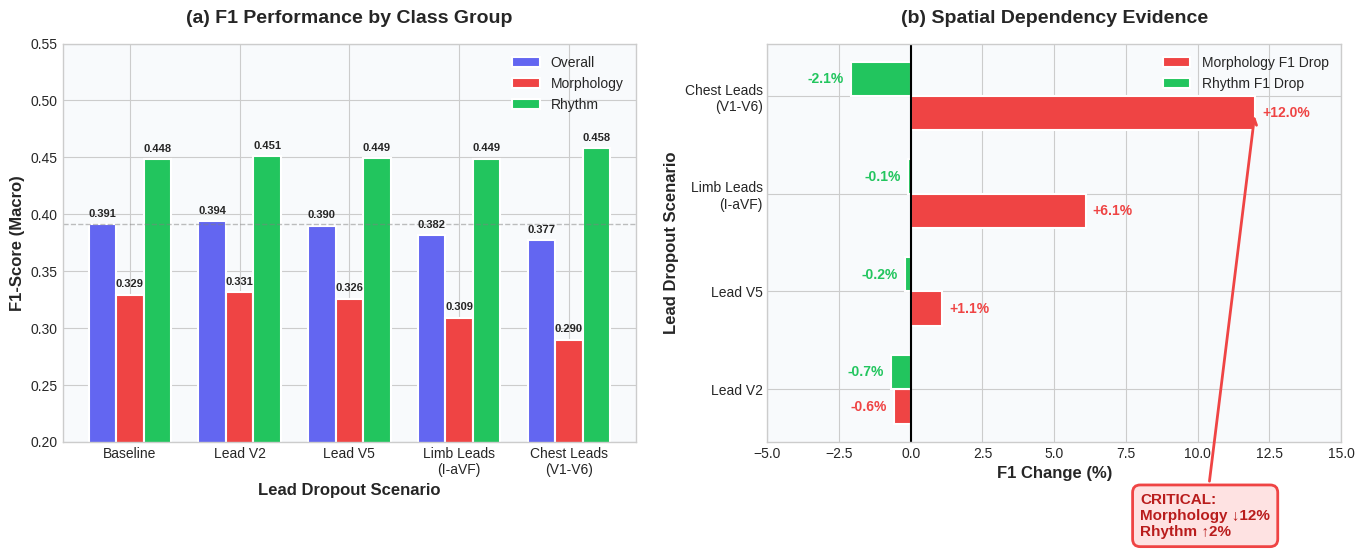


✅ Saved: /content/drive/MyDrive/ECG/models_ramba_50b70989/fig_lead_dropout_combined.png
✅ Saved: /content/drive/MyDrive/ECG/models_ramba_50b70989/fig_lead_dropout_combined.pdf

🔑 KEY FINDING FOR PAPER

When Chest Leads (V1-V6) are masked:
  ▸ Morphology F1 drops by 12.0% (0.329 → 0.290)
  ▸ Rhythm F1 INCREASES by 2.1% (0.448 → 0.458)

INTERPRETATION:
  ✓ Morphological conditions (LBBB, RBBB, axis deviations) critically depend
    on spatial information from precordial leads
  ✓ Rhythm conditions (AF, Brady) are unaffected because they rely on
    temporal RR-interval patterns, not lead-specific morphology
  ✓ This validates the Spatial Lead Attention mechanism's clinical relevance



In [ ]:
# ==================================================================================
# 📊 PUBLICATION-READY FIGURE: Lead Dropout (Morphology vs Rhythm)
# ==================================================================================
# Based on experimental results - clean visualization for IEEE paper
# ==================================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==================================================================================
# DATA FROM EXPERIMENT
# ==================================================================================
data = {
    'Scenario': ['Baseline', 'Lead V2', 'Lead V5', 'Limb Leads\n(I-aVF)', 'Chest Leads\n(V1-V6)'],
    'F1_All': [0.3910, 0.3936, 0.3898, 0.3815, 0.3770],
    'F1_Morphology': [0.3293, 0.3314, 0.3258, 0.3091, 0.2897],
    'F1_Rhythm': [0.4484, 0.4513, 0.4493, 0.4487, 0.4580],
    'Drop_Morph_%': [0.0, -0.6, 1.1, 6.1, 12.0],
    'Drop_Rhythm_%': [0.0, -0.7, -0.2, -0.1, -2.1],
}
df = pd.DataFrame(data)

# ==================================================================================
# FIGURE SETUP
# ==================================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(14, 6))

# Colors
COLOR_ALL = '#6366f1'      # Purple
COLOR_MORPH = '#ef4444'    # Red
COLOR_RHYTHM = '#22c55e'   # Green
COLOR_BG = '#f8fafc'

# ==================================================================================
# SUBPLOT 1: F1 Scores by Group (Grouped Bar Chart)
# ==================================================================================
ax1 = fig.add_subplot(121)
ax1.set_facecolor(COLOR_BG)

x = np.arange(len(df))
width = 0.25

bars1 = ax1.bar(x - width, df['F1_All'], width, label='Overall', color=COLOR_ALL, edgecolor='white', linewidth=1.5)
bars2 = ax1.bar(x, df['F1_Morphology'], width, label='Morphology', color=COLOR_MORPH, edgecolor='white', linewidth=1.5)
bars3 = ax1.bar(x + width, df['F1_Rhythm'], width, label='Rhythm', color=COLOR_RHYTHM, edgecolor='white', linewidth=1.5)

# Baseline reference line
ax1.axhline(y=df['F1_All'].iloc[0], color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Labels
ax1.set_xlabel('Lead Dropout Scenario', fontsize=12, fontweight='bold')
ax1.set_ylabel('F1-Score (Macro)', fontsize=12, fontweight='bold')
ax1.set_title('(a) F1 Performance by Class Group', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(df['Scenario'], fontsize=10)
ax1.set_ylim(0.2, 0.55)
ax1.legend(loc='upper right', framealpha=0.9, fontsize=10)

# Value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 4),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, fontweight='bold')

# ==================================================================================
# SUBPLOT 2: F1 Drop Comparison (Horizontal Bar Chart)
# ==================================================================================
ax2 = fig.add_subplot(122)
ax2.set_facecolor(COLOR_BG)

# Exclude baseline for drop chart
drop_df = df[df['Scenario'] != 'Baseline'].reset_index(drop=True)
y_pos = np.arange(len(drop_df))
height = 0.35

# Horizontal bars
bars_m = ax2.barh(y_pos - height/2, drop_df['Drop_Morph_%'], height,
                  label='Morphology F1 Drop', color=COLOR_MORPH, edgecolor='white', linewidth=1.5)
bars_r = ax2.barh(y_pos + height/2, drop_df['Drop_Rhythm_%'], height,
                  label='Rhythm F1 Drop', color=COLOR_RHYTHM, edgecolor='white', linewidth=1.5)

# Zero line
ax2.axvline(x=0, color='black', linewidth=1.5)

# Labels
ax2.set_xlabel('F1 Change (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Lead Dropout Scenario', fontsize=12, fontweight='bold')
ax2.set_title('(b) Spatial Dependency Evidence', fontsize=14, fontweight='bold', pad=15)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(drop_df['Scenario'], fontsize=10)
ax2.set_xlim(-5, 15)
ax2.legend(loc='upper right', framealpha=0.9, fontsize=10)

# Value labels
for i, (bar_m, bar_r) in enumerate(zip(bars_m, bars_r)):
    # Morphology
    w_m = bar_m.get_width()
    ax2.annotate(f'{w_m:+.1f}%',
                xy=(w_m, bar_m.get_y() + bar_m.get_height()/2),
                xytext=(5 if w_m >= 0 else -5, 0),
                textcoords="offset points",
                ha='left' if w_m >= 0 else 'right',
                va='center', fontsize=10, fontweight='bold', color=COLOR_MORPH)
    # Rhythm
    w_r = bar_r.get_width()
    ax2.annotate(f'{w_r:+.1f}%',
                xy=(w_r, bar_r.get_y() + bar_r.get_height()/2),
                xytext=(5 if w_r >= 0 else -5, 0),
                textcoords="offset points",
                ha='left' if w_r >= 0 else 'right',
                va='center', fontsize=10, fontweight='bold', color=COLOR_RHYTHM)

# Highlight Chest Leads finding
chest_idx = 3  # Index of Chest Leads in drop_df
ax2.annotate('CRITICAL:\nMorphology ↓12%\nRhythm ↑2%',
            xy=(12.0, chest_idx - height/2),
            xytext=(8, -1.5),
            fontsize=11, fontweight='bold', color='#b91c1c',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#fee2e2', edgecolor='#ef4444', linewidth=2),
            arrowprops=dict(arrowstyle='->', color='#ef4444', lw=2))

# ==================================================================================
# FINAL ADJUSTMENTS
# ==================================================================================
plt.tight_layout(pad=2.0)

# Save
MODEL_DIR = "/content/drive/MyDrive/ECG/models_ramba_50b70989"
plt.savefig(f"{MODEL_DIR}/fig_lead_dropout_combined.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f"{MODEL_DIR}/fig_lead_dropout_combined.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Saved: {MODEL_DIR}/fig_lead_dropout_combined.png")
print(f"✅ Saved: {MODEL_DIR}/fig_lead_dropout_combined.pdf")

# ==================================================================================
# KEY FINDING SUMMARY
# ==================================================================================
print("\n" + "=" * 70)
print("🔑 KEY FINDING FOR PAPER")
print("=" * 70)
print("""
When Chest Leads (V1-V6) are masked:
  ▸ Morphology F1 drops by 12.0% (0.329 → 0.290)
  ▸ Rhythm F1 INCREASES by 2.1% (0.448 → 0.458)

INTERPRETATION:
  ✓ Morphological conditions (LBBB, RBBB, axis deviations) critically depend
    on spatial information from precordial leads
  ✓ Rhythm conditions (AF, Brady) are unaffected because they rely on
    temporal RR-interval patterns, not lead-specific morphology
  ✓ This validates the Spatial Lead Attention mechanism's clinical relevance
""")


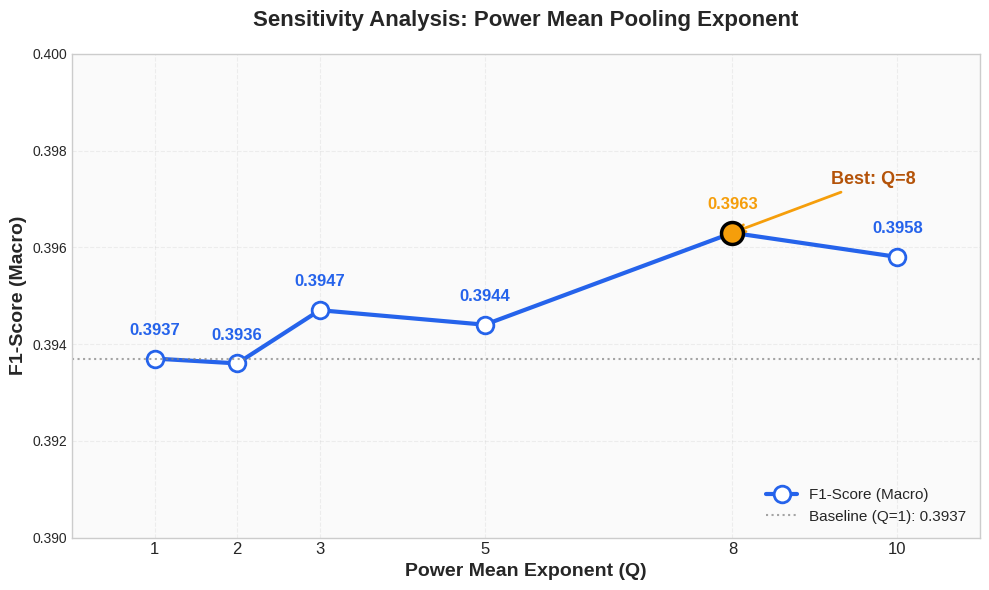


✅ Saved: /content/drive/MyDrive/ECG/models_ramba_50b70989/fig_sensitivity_Q_simple.png

🏆 Best Q = 8 with F1 = 0.3963
   Improvement over Q=1: +0.26%


In [ ]:
# ==================================================================================
# 📊 SIMPLE FIGURE: Power Mean Q Sensitivity Analysis
# ==================================================================================
# Single clean chart - no combined layout
# ==================================================================================

import matplotlib.pyplot as plt
import numpy as np

# ==================================================================================
# DATA
# ==================================================================================
Q = [1, 2, 3, 5, 8, 10]
F1 = [0.3937, 0.3936, 0.3947, 0.3944, 0.3963, 0.3958]

best_idx = np.argmax(F1)
best_Q = Q[best_idx]
best_F1 = F1[best_idx]

# ==================================================================================
# SINGLE FIGURE
# ==================================================================================
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('#fafafa')

# Plot line
ax.plot(Q, F1, 'o-', color='#2563eb', linewidth=3, markersize=12,
        markerfacecolor='white', markeredgewidth=2, label='F1-Score (Macro)')

# Highlight best point
ax.scatter([best_Q], [best_F1], s=250, color='#f59e0b', edgecolor='black',
           linewidth=2.5, zorder=5)

# Add value labels ABOVE each point
for i, (q, f1) in enumerate(zip(Q, F1)):
    label_color = '#f59e0b' if q == best_Q else '#2563eb'
    label_weight = 'bold'
    ax.annotate(f'{f1:.4f}',
                xy=(q, f1),
                xytext=(0, 15),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=12, fontweight=label_weight, color=label_color)

# Best annotation
ax.annotate(f'Best: Q={best_Q}',
            xy=(best_Q, best_F1),
            xytext=(best_Q + 1.2, best_F1 + 0.001),
            fontsize=13, fontweight='bold', color='#b45309',
            arrowprops=dict(arrowstyle='->', color='#f59e0b', lw=2))

# Labels
ax.set_xlabel('Power Mean Exponent (Q)', fontsize=14, fontweight='bold')
ax.set_ylabel('F1-Score (Macro)', fontsize=14, fontweight='bold')
ax.set_title('Sensitivity Analysis: Power Mean Pooling Exponent',
             fontsize=16, fontweight='bold', pad=20)

# Axis settings
ax.set_xticks(Q)
ax.set_xticklabels([str(q) for q in Q], fontsize=12)
ax.set_ylim(0.390, 0.400)
ax.set_xlim(0, 11)

# Grid
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Add horizontal line at baseline
ax.axhline(y=F1[0], color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
           label=f'Baseline (Q=1): {F1[0]:.4f}')

ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()

# Save
MODEL_DIR = "/content/drive/MyDrive/ECG/models_ramba_50b70989"
plt.savefig(f"{MODEL_DIR}/fig_sensitivity_Q_simple.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(f"{MODEL_DIR}/fig_sensitivity_Q_simple.pdf", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Saved: {MODEL_DIR}/fig_sensitivity_Q_simple.png")
print(f"\n🏆 Best Q = {best_Q} with F1 = {best_F1:.4f}")
print(f"   Improvement over Q=1: +{(best_F1 - F1[0])*100:.2f}%")
